In [15]:
import sqlite3
db = sqlite3.connect('./database')
db.isolation_level = None
cursor = db.cursor()

In [259]:
cursor.execute('''
    CREATE TABLE IF NOT EXISTS gene_features_all(id TEXT, trans_id TEXT, prot_id TEXT, chrom INTEGER, start INTEGER, end INTEGER, gLength INTEGER, cds INTEGER, name TEXT, exp REAL, ess REAL, evolRate REAL, dup_type TEXT)
''')
with open('lens_locs_2.txt') as source:
    source.readline()
    for line in source:
        line = line.strip().split('\t')
        gene_id, transcript_id, prot_id, chrom, start, end, CDS, name = line
        gLen = (abs(int(end)-int(start))) +1 #start and end bases are both within the gene
        cursor.execute(
                '''INSERT INTO gene_features_all(id, trans_id, prot_id, chrom, start, end, gLength, cds, name) VALUES(?,?,?,?,?,?,?,?,?)''', 
                (gene_id, transcript_id, prot_id, chrom, start, end, gLen, CDS, name))
        db.commit()

In [260]:
#essentiality
with open('Downloads/Wang_CRISPR.csv', 'r') as file:
    file.readline()
    for line in file:
        l = line.strip().split(',')
        geneName, KBM7, K562, Jiyoye, Raji = l[0], float(l[2]), float(l[4]), float(l[6]), float(l[8])
        scoreList = [KBM7, K562, Jiyoye, Raji]
        ess = min(scoreList)
        cursor.execute('''UPDATE gene_features_all SET ess = ? WHERE name == ?''', 
                       (ess, geneName))
        db.commit()

In [261]:
#evolutionary rate
count = 0
with open('Downloads/dn_ds_chimp.txt','r') as evol_file_chimp:
    evol_file_chimp.readline()
    for line in evol_file_chimp:
        count += 1
        line = line.strip().split('\t')
        if len(line) == 4:
            gene_id_ev, trans_id_ev, dn, ds = line
            if float(ds) == 0:
                rate = 0
            else:
                rate = float(dn)/float(ds)
        else:
            gene_id_ev, trans_id_ev = line
            dn = '-'
            ds = '-'
            rate = '-'
        cursor.execute('''UPDATE gene_features_all SET evolRate = ? WHERE 
                        (id == ?)''', 
                       (rate, gene_id_ev))
    db.commit()

In [ ]:
#id to tissue
cursor.execute('CREATE TABLE IF NOT EXISTS sample_att(Gtex_id TEXT, tissue TEXT)')
with open('Downloads/GTex_sample_data.txt') as sample_att_file:
    sample_att_file.readline()
    for line in sample_att_file:
        line = line.strip().split('\t')
        GTex_id, tissue = line[0], line[5]
        cursor.execute('INSERT INTO sample_att(Gtex_id, tissue) VALUES(?,?)', (GTex_id, tissue))
    db.commit()

In [29]:
#gene expression
count = 0
pcount = 0
import re
import numpy as np

cursor.execute('CREATE TABLE IF NOT EXISTS Gene_expression_data(id TEXT, name TEXT, tissue TEXT, avg_exp REAL)')

with open('Downloads/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.txt') as expression_file:
    for i in range(2):
        expression_file.readline()
    sample_ids = expression_file.readline().strip().split('\t')[2:]
    #gets where each tissue starts and ends in the sample ids
    tissue_index = {}
    old_tissue = ''
    for i in range(0,len(sample_ids)):
        cursor.execute('''SELECT tissue FROM sample_att WHERE GTex_id == ?''', (sample_ids[i],))
        tissue = cursor.fetchall()[0][0]
        if tissue == old_tissue:
            tissue_index[tissue].append(i)
        else:
            tissue_index[tissue] = [i]
            old_tissue = tissue
    #each line is a gene
    print('starting')
    for line in expression_file:
        count += 1
        av_dict = {}
        count += 1
        line = line.strip().split('\t')
        #gives the gene id without the version number
        gene = re.search(r'(.*)\.(.*)', line[0]).group(1)
        name = line[1]
        exp_values = line[2:]
        for i in range(0,len(exp_values)):
             exp_values[i] = float(exp_values[i])
        for tissue in tissue_index:
            mini = min(tissue_index[tissue])
            maxi = max(tissue_index[tissue]) + 1
            #get the average expression for each tissue
            av_dict[tissue] = np.median(exp_values[mini:maxi])
            cursor.execute('''INSERT INTO Gene_expression_data(id, name, tissue, avg_exp) VALUES (?,?,?,?)''',
                          (gene, name, tissue, av_dict[tissue]))
        if count % 2810 == 0:
            pcount += 5
            print(str(pcount) + '%')
        #need to add the expression data from other sources 
db.commit()

starting


OperationalError: near "(": syntax error

In [ ]:
#transcript expression
count = 0
pcount = 0
cursor.execute('CREATE TABLE IF NOT EXISTS Transcript_expression_data(id TEXT, trans_id TEXT, tissue TEXT, avg_exp REAL)')

with open('Downloads/GTEx_Analysis_2016-01-15_v7_RSEMv1.2.22_transcript_tpm.txt') as t_exp_file:
    #the first two items aren't ids
    sample_ids_2 = t_exp_file.readline().strip().split('\t')[2:]
    tissue_index = {}
    old_tissue = ''
    for i in range(0,len(sample_ids_2)):
        cursor.execute('''SELECT tissue FROM sample_att WHERE GTex_id == ?''', (sample_ids[i],))
        tissue = cursor.fetchall()[0][0]
        if tissue == old_tissue:
            tissue_index[tissue].append(i)
        else:
            tissue_index[tissue] = [i]
            old_tissue = tissue
    for line in t_exp_file:
        av_dict = {}
        count += 1
        line = line.strip().split('\t')        
        transcript = re.search(r'(.*)\.(.*)', line[0]).group(1)
        gene = re.search(r'(.*)\.(.*)', line[1]).group(1)
        t_exp_values = line[2:]
        for i in range(0,len(t_exp_values)):
             t_exp_values[i] = float(t_exp_values[i])
        for tissue in tissue_index:
            mini = min(tissue_index[tissue])
            maxi = max(tissue_index[tissue]) + 1
            #get the average expression for each tissue
            av_dict[tissue] = np.mean(t_exp_values[mini:maxi])
            cursor.execute('''INSERT INTO Transcript_expression_data(id, trans_id, tissue, avg_exp) VALUES (?,?,?,?)''',
                          (gene, transcript, tissue, av_dict[tissue])) 
        if count%9826 == 0:
            pcount += 5
            print(str(pcount) + '%')
db.commit()

In [270]:
from statistics import mode, StatisticsError
import time
cursor.execute('''CREATE TABLE IF NOT EXISTS gene_features(id TEXT, chrom INTEGER, start INTEGER, end INTEGER, 
                gLength INTEGER, cds_len INTEGER, cds_exp INTEGER, name TEXT, 
                exp REAL, ess REAL, evolRate REAL, dup_type TEXT, dev TEXT)''')
cursor.execute('''SELECT DISTINCT id FROM gene_features_all''')
count = 0
pcount = 0
id_list = []
[id_list.append(y[0]) for y in cursor.fetchall()]
query_list = []
print('starting')
t1 = time.time()
for gene_id in id_list:
    count += 1
    row_list = []
    cursor.execute('''SELECT * FROM gene_features_all WHERE id == ?''', (gene_id,))
    [row_list.append(x) for x in cursor.fetchall()]
    row1 = row_list[0]
    i,c,s,e,gL,n,es,eR,dT = row1[0], row1[3], row1[4], row1[5], row1[6], row1[8], row1[10], row1[11], row1[12]
    #cds by length
    cds_list = []
    [cds_list.append(row[7]) for row in row_list]
    cds = max(cds_list)
    cursor.execute('''SELECT avg_exp FROM Gene_expression_data WHERE id == ?''', (gene_id,))
    exp_list = []
    [exp_list.append(x[0]) for x in cursor.fetchall()]
    try:
        ex = max(exp_list)
    except ValueError:
        ex = -1
    #CDS by expression
    tList = []
    cursor.execute('''SELECT id, tissue, trans_id, MAX(avg_exp) 
                    FROM Transcript_expression_data
                    WHERE id = ?
                    GROUP BY id,tissue''',
                    (gene_id,))
    [tList.append(y[2]) for y in cursor.fetchall()]
    try:
        tt = mode(tList)
        cursor.execute('''SELECT cds FROM gene_features_all WHERE trans_id = ?''', (tt,))
        cds_e = cursor.fetchall()[0][0]
    except (IndexError, StatisticsError) as error:
        cds_e = -1
    query_list.append((i,c,s,e,gL,cds,cds_e,n,ex,es,eR,dT))
    if (count%250 == 0) or (count == len(id_list)):
        cursor.executemany('''INSERT INTO gene_features(id,chrom,start,end,gLength,cds_len,cds_exp,name,exp,ess,evolRate,dup_type) 
                    VALUES (?,?,?,?,?,?,?,?,?,?,?,?)''', query_list)
        query_list.clear()
        print(time.time()-t1)
    if count%1014 == 0:
        pcount += 5
        print(str(pcount) + '%' + ' done')
db.commit()

starting
635.4381759166718
1262.0247631072998
1884.391834974289
2505.430620908737
5% done
3124.3054060935974
3742.8106050491333
4361.413789987564
4979.523952960968
10% done
5621.419725894928
6321.52587389946
7014.365797996521
7715.520747900009
15% done
8397.515458106995
9095.19866490364
9793.084975004196
10447.31580901146
20% done
11076.027450084686
11703.624747037888
12331.253510951996
12959.032908916473
25% done
13585.660911083221
14212.110119104385
14838.145415067673
15463.204093933105
30% done
16088.090156078339
16712.52544593811
17336.91012096405
17964.470082998276
35% done
18600.17510008812
19242.171489953995
19877.183581113815
20542.92020010948
40% done
21156.398781061172
21785.615838050842
22448.54932999611
23090.75127005577
45% done
23723.3496260643
24332.68085002899
24935.235861063004
25536.698832035065
50% done
26137.39456510544
26737.58636689186
27336.265707969666
27933.643132925034
55% done
28530.880835056305
29127.561028003693
29723.399254083633
30319.195180892944
60% don

In [272]:
cursor.execute('''ALTER TABLE gene_features ADD COLUMN dev_exp REAL''')

In [273]:
# updating exp column with brain dev data
count = 0
qList = []
t1 = time.time()
with open('Downloads/brain_dev_exp.tsv', 'r') as brain_file:
    for i in range(0,4):
        brain_file.readline()
    tissues = brain_file.readline().strip().split('\t')[2:]
    old_max = 0
    for line in brain_file:
        count += 1
        values = []
        line = line.strip().split('\t')
        gene_id = line[0]
        name = line[1]
        for x in line[2:]:
            try:
                values.append(float(x)) 
            except ValueError:
                [values.append(None)]
        max_dev = max(x for x in values if x is not None)
        qList.append((max_dev, gene_id))
        if count % 500 == 0:
            print(count)
            print((time.time()-t1)/60)
            t1 = time.time()
            cursor.executemany('''UPDATE gene_features SET dev_exp = ? 
                                WHERE (id == ?) ''', qList)
            qList.clear()
    cursor.executemany('''UPDATE gene_features SET dev_exp = ? 
                        WHERE (id == ?)''', qList)
db.commit()

500
0.0011044661204020181
1000
0.05184411605199178
1500
0.048823233445485434
2000
0.048802681763966876
2500
0.047989384333292646
3000
0.047914516925811765
3500
0.04811926682790121
4000
0.04789576530456543
4500
0.047833800315856934
5000
0.04774726629257202
5500
0.04774381717046102
6000
0.048572699228922524
6500
0.04834776719411214
7000
0.04783725341161092
7500
0.04757406711578369
8000
0.04847033421198527
8500
0.048020180066426596
9000
0.04819468259811401
9500
0.04792136748631795
10000
0.04921886920928955
10500
0.04798630078633626
11000
0.04842958052953084
11500
0.04829626480738322
12000
0.048191781838734946
12500
0.04849486748377482
13000
0.047908631960550944
13500
0.04809266726175944
14000
0.04816731611887614
14500
0.047990016142527264
15000
0.04824965000152588
15500
0.04818271398544312
16000
0.04872804880142212
16500
0.048387197653452556
17000
0.051161948839823404
17500
0.04892956813176473
18000
0.04781428575515747
18500
0.0482727845509847
19000
0.048763434092203774
19500
0.0489410360

In [274]:
#fetal data (FANTOM5)
i_list = []
values = []
q_list = []
count = 0
with open('Downloads/fetal_exp.tsv', 'r') as ffile:
    for i in range(0,4):
        ffile.readline()
    header = ffile.readline().strip().split('\t')
    for i in range(0, len(header)):
        if 'fetal' in header[i]:
             i_list.append(i)
    for line in ffile:
        count += 1
        values = []
        line = line.strip().split('\t')
        gene_id = line[0]
        for n in i_list:
            try:
                values.append(line[n])
            except IndexError:
                values.append(None)
        max_val = max(x for x in values if x is not None)
        q_list.append((max_val, gene_id, max_val))
        if count % 500 == 0:
            cursor.executemany('''UPDATE gene_features 
                                SET dev_exp = ? 
                                WHERE (id ==?) AND (dev_exp < ?)''', q_list)
            q_list.clear()
            print(count)
    cursor.executemany('''UPDATE gene_features 
                        SET dev_exp = ? 
                        WHERE (id ==?) AND (dev_exp < ?)''', q_list) 

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000


In [49]:
cursor.execute('''DROP TABLE ohnologs''')
cursor.execute('''CREATE TABLE IF NOT EXISTS ohnologs(id TEXT, ohnos TEXT)''')
o_dict = {}
with open('Desktop/human_ohnologs_EnsV86.txt', 'r') as o_file:
    for line in o_file:
        line = line.strip().split('\t')
        gene, ohno = line[0], line[1]
        if gene in o_dict.keys():
            o_dict[gene].append(ohno)
        else:
            o_dict[gene] = [ohno]
for key in o_dict:
    ohnos = ' '.join(o_dict[key])
    cursor.execute('INSERT INTO ohnologs(id,ohnos) VALUES(?,?)', (key,ohnos))
# for key in o_dict:
#     try:
#         cursor.execute('SELECT id FROM gene_features_all WHERE prot_id == ?', (key,))
#         gene = cursor.fetchall()[0][0]
#     except IndexError:
#         next
#     cursor.execute('SELECT ohnos FROM ohnologs WHERE id ==?', (key,))
#     no = len(cursor.fetchall()[0][0].split(' '))
#     if no > 4:
#         print(gene, key, ' WGD:', no)

In [50]:
cursor.execute('''ALTER TABLE ohnologs ADD COLUMN g_id TEXT''')
cursor.execute('''UPDATE ohnologs SET g_id = 
                (SELECT id FROM gene_features_all WHERE prot_id == ohnologs.id)''')

In [133]:
cursor.execute('UPDATE gene_features SET dup_type = "singleton" WHERE id NOT IN (SELECT id FROM paralogs_id)')
ids = []
cursor.execute('''SELECT id FROM gene_features WHERE dup_type != "singleton"''')
[ids.append(x[0]) for x in cursor.fetchall()]
count = 0
count_d = 0
count_check = 0
for i in ids:
    WGD = 'No'
    SSD = 'No'
    para_count = 0
    WGD_count = 0
    SSD_count = 0
    cursor.execute('SELECT paralogs_p FROM paralogs_id WHERE id ==?', (i,))
    paras = cursor.fetchall()[0][0].split(' ')
    cursor.execute('SELECT ohnos FROM ohnologs WHERE g_id == ?', (i,))
    try:
        ohnos = cursor.fetchall()[0][0].split(' ')
        for p in paras:
            para_count += 1
            if p in ohnos:
                WGD = 'Yes'
                WGD_count += 1
            elif p not in ohnos:
                SSD = 'Yes'
                SSD_count += 1
    except IndexError:
        WGD = 'No'
        SSD = 'Yes'
    if (WGD == 'Yes') and (SSD == 'Yes'):
        count += 1
        cursor.execute('''UPDATE gene_features SET dup_type = "WGD/SSD" WHERE id ==?''', (i,))
    elif WGD == 'Yes':
        cursor.execute('''UPDATE gene_features SET dup_type = "WGD" WHERE id == ?''', (i,))
    elif SSD == 'Yes':
        cursor.execute('''UPDATE gene_features SET dup_type = "SSD" WHERE id == ?''', (i,))
    else:
        print(i)
        print('Problem!')
    count_check +=1
    if count_check % 500 == 0:
        print(count_check * 100 /len(ids))
db.commit()
#             print(i)
#             print(para_count, WGD_count, SSD_count)
#         if SSD_count == 1:
#             count_d += 1
    
    
# print(count)
# print(count_d)

5.963740458015267
11.927480916030534
17.891221374045802
23.85496183206107
29.818702290076335
35.782442748091604
41.74618320610687
47.70992366412214
53.6736641221374
59.63740458015267
65.60114503816794
71.56488549618321
77.52862595419847
83.49236641221374
89.45610687022901
95.41984732824427


In [316]:
cursor.execute('''SELECT  COUNT (DISTINCT id) FROM paralogs WHERE vertebrate = "Yes"''')
print(cursor.fetchall())

[(12164,)]


In [286]:
cursor.execute('''DROP TABLE paralogs_id''')

In [131]:
ids = []
cursor.execute('''SELECT id FROM gene_features WHERE id IN (SELECT id FROM paralogs_id)''')
[ids.append(x[0]) for x in cursor.fetchall()]
count = 0
both_count = 0
WGD_count = 0
SSD_count = 0
for i in ids:
    count += 1
    WGD = 'No'
    SSD = 'No'
    para_count = 0

    cursor.execute('SELECT paralogs_p FROM paralogs_id WHERE id ==?', (i,))
    paras = cursor.fetchall()[0][0].split(' ')    
    cursor.execute('SELECT ohnos FROM ohnologs WHERE g_id == ?', (i,))
    try:
        ohnos = cursor.fetchall()[0][0].split(' ')
        for p in paras:
            para_count += 1
            if p in ohnos:
                WGD = 'Yes'
            elif p not in ohnos:
                SSD = 'Yes'
    except IndexError:
        WGD = 'No'
        SSD = 'Yes'
    if (WGD == 'Yes') and (SSD == 'Yes'):
        both_count += 1
    elif WGD == 'Yes':
        WGD_count += 1
    elif SSD == 'Yes':
        SSD_count += 1
    if count % 500 == 0:
        print(count*100/14218)
print(both_count)
print(WGD_count)
print(SSD_count)

3.516669011112674
7.033338022225348
10.550007033338023
14.066676044450697
17.58334505556337
21.100014066676046
24.616683077788718
28.133352088901393
31.650021100014065
35.16669011112674
38.683359122239416
42.20002813335209
45.71669714446476
49.233366155577436
52.75003516669011
56.26670417780279
656
3159
4569


In [11]:
names = []
e_names = []
cursor.execute('''SELECT name FROM gene_features''')
[names.append(x[0]) for x in cursor.fetchall()]
with open('Downloads/Wang_CRISPR.csv', 'r') as file:
    file.readline()
    for line in file:
        l = line.strip().split(',')
        geneName = l[0]
        e_names.append(geneName)
for n in names:
    if n not in e_names:
        cursor.execute('''UPDATE gene_features SET ess = -10 WHERE name == ?''', (n,))


In [ ]:
#check differences in IDs across GrCH37/GrCH38
with open('Downloads/Results-Homo_sapiens_Tools_IDMapper_.csv', 'r') as file1:
    file1.readline()
    count = 0
    not_exists = []
    not_exists2 = []
    for line in file1:
        line = line.strip().split(',')
        if line[0] != line[1]:
            count += 1
            not_exists.append(line[0])
            not_exists2.append(line[1])
            print('found one!')
            print(line[0], line[1])
    print('Old IDs: ' + str(len(set(not_exists))))
    print('New IDs: ' + str(len(set(not_exists2))))
with open('Downloads/Results-Homo_sapiens_Tools_IDMapper_-2.csv', 'r') as file2:
    file2.readline()
    not_exists2 = []
    not_exists = []
    for line in file2:
        line = line.strip().split(',')
        if line[0] != line[1]:
            count += 1
            not_exists.append(line[0])
            not_exists2.append(line[1])
            print('found one!')
            print(line[0], line[1])
    print('Old IDs: ' + str(len(set(not_exists))))
    print('New IDs: ' + str(len(set(not_exists2))))

In [124]:
# FIXED!!!
import json
import time
import requests
start_time = time.time()
cursor.execute('''DROP TABLE paralogs''')
cursor.execute('''CREATE TABLE IF NOT EXISTS paralogs(id TEXT, para TEXT, tax_group TEXT, vertebrate TEXT)''')
old_tax_list = ['Opisthokonta','Animalia','Bilateria', 'Chordata'] 
new_tax_list = ['Vertebrata', 'Sarcopterygii','Euteleostomi', 'Tetrapoda', 
                'Amniota', 'Mammalia', 'Theria', 'Eutheria','Boreoeutheria',  
                'Euarchontoglires', 'Primates', 'Haplorrhini', 'Simiiformes',
                'Catarrhini', 'Hominoidea', 'Hominidae','Homininae', 'Homo sapiens']
# euarchontoglires contains rodents
cursor.execute('''SELECT DISTINCT id FROM gene_features''')
id_list = [e[0] for e in cursor.fetchall()]
t1 = time.time()
act_count = 0
act_time = time.time()
count = 0
arg_list = []

for i in id_list:
    f_count = 0
    act_count += 1
#     while True:
#         try:
    if (time.time() - t1 <= 1) and (count == 10):
        time.sleep(2)
        t1 = time.time()
        count = 0
        url = 'http://rest.ensembl.org/homology/id/' + i + '?type=paralogues;target_species=human;sequence=none;'
        headers = {'Content-type':'application/json'}
        res = requests.get(url, headers= headers).json()
        count += 1
        # 1 entry dictionary with key 'data' that has the value of a one entry list 
        # which is a dictionary with two keys, id (value is queried id) and homologies
        # if id has no paralogs top dict structure is: {"data":[{"homologies":[],"id":"ENSG00000174059"}]}
        if res['data'][0]['homologies'] != []:
            for y in res['data'][0]['homologies']:
                para = y['target']['id']
                tax = y['taxonomy_level']
                if tax not in new_tax_list:
                    v = 'No'
                else:
                    v = 'Yes'
                arg_list.append((i,para,tax,v))
        else:
            continue
    else:
        url = 'http://rest.ensembl.org/homology/id/' + i + '?type=paralogues;target_species=human;sequence=none;'
        headers = {'Content-type':'application/json'}
        res = requests.get(url, headers= headers).json()
        count += 1
        if res['data'][0]['homologies'] != []:
            for y in res['data'][0]['homologies']:
                para = (y['target']['id'])
                tax = y['taxonomy_level']
                if tax not in new_tax_list:
                    v = 'No'
                else:
                    v = 'Yes'
                arg_list.append((i,para,tax,v))
        else:
            continue

#         except KeyError:
#             f_count += 1
#             if f_count <= 5:
#                 continue
#             else:
#                 print(res)
#                 print(i, 'GAVE UP')
#                 break
        
    if act_count%200 == 0:
        print(act_count)
        print((time.time() - act_time)/60)
        act_time = time.time()
        cursor.executemany('''INSERT INTO paralogs(id,para,tax_group,vertebrate) VALUES (?,?,?,?)''', arg_list)
        arg_list = []
    elif act_count == len(id_list):
        cursor.executemany('''INSERT INTO paralogs(id,para,tax_group,vertebrate) VALUES (?,?,?,?)''', arg_list)
        print('DONE. It took:', (time.time()-start_time)/60, 'minutes')



400
1.4999165852864584
600
1.0288402994473775
800
0.8545651833216349
1000
0.7471620321273804
1400
1.5970317522684734
1600
0.8292325655619304
1800
0.7763855655988058
2000
0.7648788332939148
2400
1.46599543094635
2600
0.8261043985684713
2800
0.7202593843142192
3000
0.6806267857551574
3200
0.6648555517196655
3400
0.6391944487889608
3600
0.6678495486577352
3800
0.735626216729482
4000
0.6969602664311727
4400
1.3516075332959494
4600
0.8359504699707031
4800
0.715131402015686
5000
0.6807707031567891
5200
0.6902540524800619
5400
0.746881381670634
5800
1.2067046682039897
6000
0.8221797347068787
6200
0.6604641159375508
6400
0.709081482887268
6600
0.7772870818773906
6800
0.771292265256246
7200
1.3118518352508546
7400
0.842841919263204
7600
0.6810350815455118
7800
0.8572557171185812
8400
2.2232659180959065
8600
0.921403682231903
8800
0.65737224817276
9200
1.3347592989603678
9400
1.0363859494527181
9600
0.8588784694671631
9800
0.7963651657104492
10000
0.7631242195765178
10200
0.7037003636360168
1040

In [130]:
# FIXED!!!
cursor.execute('''UPDATE gene_features SET dup_type = NULL''')
cursor.execute('''UPDATE gene_features SET dup_type = "singleton" WHERE id NOT IN 
                (SELECT id FROM paralogs WHERE vertebrate = "Yes")''')

cursor.execute('''SELECT id FROM gene_features WHERE dup_type IS NULL''')
ids = [x[0] for x in cursor.fetchall()]
count, t = 0, time.time()

for i in ids:
    WGD = 'No'
    SSD = 'No'
    cursor.execute('SELECT para FROM paralogs WHERE id ==? AND vertebrate = "Yes"', (i,))
    paras = [x[0] for x in cursor.fetchall()]
    cursor.execute('SELECT ohno_id FROM ohnologs_gene_ids WHERE id == ? AND vertebrate = "Yes"', (i,))
    res = cursor.fetchall()
    if res == []:
        WGD = 'No'
        SSD = 'Yes'
    else:
        ohnos = [x[0] for x in res]
        for p in paras:
            if p in ohnos:
                WGD = 'Yes'
            else:
                SSD = 'Yes'
    if (WGD == 'Yes') and (SSD == 'Yes'):
        cursor.execute('''UPDATE gene_features SET dup_type = "WGD/SSD" WHERE id ==?''', (i,))
    elif WGD == 'Yes':
        cursor.execute('''UPDATE gene_features SET dup_type = "WGD" WHERE id == ?''', (i,))
    elif SSD == 'Yes':
        cursor.execute('''UPDATE gene_features SET dup_type = "SSD" WHERE id == ?''', (i,))
    else:
        print(i)
        print('Problem!')
    count +=1
    if count % 500 == 0:
        print(count, 'done:', round(time.time()-t, 2), 'seconds') 

500 done: 30.21 seconds
1000 done: 59.15 seconds
1500 done: 85.0 seconds
2000 done: 110.52 seconds
2500 done: 136.78 seconds
3000 done: 162.49 seconds
3500 done: 189.52 seconds
4000 done: 214.81 seconds
4500 done: 240.67 seconds
5000 done: 267.34 seconds
5500 done: 292.85 seconds
6000 done: 318.12 seconds
6500 done: 343.78 seconds
7000 done: 369.16 seconds
7500 done: 394.45 seconds
8000 done: 420.71 seconds
8500 done: 447.82 seconds
9000 done: 473.5 seconds
9500 done: 499.46 seconds
10000 done: 524.93 seconds
10500 done: 550.18 seconds
11000 done: 575.72 seconds
11500 done: 602.44 seconds
12000 done: 630.34 seconds


In [131]:
db.commit()

In [132]:
cursor.execute('''SELECT COUNT (*) FROM gene_features WHERE dup_type = "singleton"''')
print('Singletons:', cursor.fetchall()[0][0])

cursor.execute('''SELECT COUNT (*) FROM gene_features WHERE dup_type = "SSD"''')
print('Small scale duplicates:', cursor.fetchall()[0][0])

cursor.execute('''SELECT COUNT (*) FROM gene_features WHERE dup_type = "WGD"''')
print('Ohnologs:', cursor.fetchall()[0][0])

cursor.execute('''SELECT COUNT (*) FROM gene_features WHERE dup_type = "WGD/SSD"''')
print("Things that shouldn't be:", cursor.fetchall()[0][0])

Singletons: 8116
Small scale duplicates: 6095
Ohnologs: 4904
Things that shouldn't be: 1162


In [237]:
cursor.execute('''SELECT DISTINCT COUNT(id) FROM gene_features 
                    WHERE id IN (SELECT id FROM paralogs WHERE vertebrate = "No") 
                    AND dup_type = "singleton"''')
cursor.fetchall()

[(3703,)]

In [307]:
cursor.execute('''SELECT * FROM ohnologs''')
count = 0
g_ohnos = []
forList = cursor.fetchall()
for x in forList:
    count += 1
    f = x[2]
    ohnos = x[1].split(' ')
    for e in ohnos:
        cursor.execute('''SELECT id FROM gene_features_all WHERE prot_id = ?''', (e,))
        try:
            g_e = cursor.fetchall()[0][0]
        except IndexError:
            print('Protein not found:', e)
        cursor.execute('''SELECT * FROM paralogs WHERE id = ? AND para = ? AND vertebrate = "No"''', (f,e))
        early_ohno_pairs = cursor.fetchall()
        if early_ohno_pairs != []:
            print(f, early_ohno_pairs)
    if count % 700 == 0:
        print((count/len(forList))*100, '% done')

Protein not found: ENSP00000443191
Protein not found: ENSP00000341867
10.534236267870579 % done
Protein not found: ENSP00000341867
21.068472535741158 % done
Protein not found: ENSP00000341867
31.60270880361174 % done
42.136945071482316 % done
Protein not found: ENSP00000361672
Protein not found: ENSP00000484912
52.6711813393529 % done
63.20541760722348 % done
73.73965387509406 % done
Protein not found: ENSP00000361672
84.27389014296463 % done
Protein not found: ENSP00000361672
94.80812641083521 % done


In [376]:
mix_ids = []
o_count = 0
prob_count = 0
cursor.execute('''SELECT id FROM gene_features''')
[mix_ids.append(x[0]) for x in cursor.fetchall()]
for i in mix_ids:
    cursor.execute('''SELECT COUNT (*) FROM paralogs WHERE id = ? AND vertebrate = "Yes"''', (i,))
    try:
        para_count = cursor.fetchone()[0]
    except IndexError:
        para_count = 0
    cursor.execute('''SELECT COUNT (*) FROM ohnologs_gene_ids WHERE id = ?''', (i,))
    try:
        o_count = cursor.fetchone()[0]
    except IndexError:
        o_count = 0
    if o_count > 4:
        prob_count += 1
        print(i, para_count, o_count)
    
print(prob_count)

ENSG00000143320 5 5
ENSG00000134183 5 5
ENSG00000173369 11 9
ENSG00000179546 5 5
ENSG00000132692 7 7
ENSG00000168243 8 5
ENSG00000188004 9 6
ENSG00000070886 13 13
ENSG00000126091 7 7
ENSG00000116329 10 10
ENSG00000187513 15 8
ENSG00000170128 8 8
ENSG00000135773 8 5
ENSG00000132702 7 7
ENSG00000133216 13 13
ENSG00000196189 12 5
ENSG00000162909 8 5
ENSG00000243284 9 6
ENSG00000185278 11 10
ENSG00000082482 5 5
ENSG00000159189 11 9
ENSG00000162444 5 5
ENSG00000170075 6 6
ENSG00000203697 8 5
ENSG00000117152 9 7
ENSG00000117069 5 5
ENSG00000174502 9 5
ENSG00000121634 15 8
ENSG00000184005 5 5
ENSG00000119535 6 5
ENSG00000050628 7 7
ENSG00000143537 14 5
ENSG00000065135 5 5
ENSG00000143248 9 7
ENSG00000172380 8 5
ENSG00000183317 13 13
ENSG00000143333 9 6
ENSG00000171488 6 5
ENSG00000171492 6 5
ENSG00000081985 6 5
ENSG00000265107 15 8
ENSG00000143127 10 7
ENSG00000171517 10 10
ENSG00000198835 15 8
ENSG00000135824 9 6
ENSG00000143167 9 7
ENSG00000197147 6 5
ENSG00000171812 11 9
ENSG00000181773 10

In [126]:
# FIXED!!!!!
cursor.execute('''DROP TABLE ohnologs_gene_ids''')
cursor.execute('''CREATE TABLE IF NOT EXISTS ohnologs_gene_ids(id TEXT, ohno_id TEXT, tax_group TEXT, vertebrate TEXT)''')
cursor.execute('''SELECT * FROM ohnologs''')
count, t = 0, time.time()
for y in cursor.fetchall():
    ID = y[2]
    ohno_p = y[1].split(' ')
    for o in ohno_p:
        cursor.execute('''SELECT id FROM gene_features_all WHERE prot_id = ?''', (o,))
        try:
            o_ID = cursor.fetchall()[0][0]
        except IndexError:
            print(o)
            continue
        cursor.execute('''SELECT tax_group, vertebrate FROM paralogs WHERE (id == ? AND para == ?) OR (para == ? AND id == ?)''', (ID, o_ID, ID, o_ID))
        try:
            tax, vert = cursor.fetchall()[0]
            cursor.execute('''INSERT INTO ohnologs_gene_ids(id,ohno_id, tax_group, vertebrate) VALUES (?,?,?,?)''', (ID, o_ID, tax, vert))
        except IndexError:
            print(ID, o_ID)
    count += 1
    if count % 200 == 0:
        print(count, time.time()-t)


ENSG00000134873 ENSG00000013297
ENSG00000122574 ENSG00000115935
ENSG00000092758 ENSG00000124749
ENSG00000183484 ENSG00000126266
ENSG00000147145 ENSG00000186912
ENSG00000147145 ENSG00000175591
ENSG00000147145 ENSG00000171631
ENSG00000147145 ENSG00000144230
ENSG00000147145 ENSG00000169508
ENSG00000147145 ENSG00000173198
ENSG00000147145 ENSG00000152207
200 38.27836990356445
ENSG00000137699 ENSG00000141569
ENSG00000137699 ENSG00000121060
ENSG00000133216 ENSG00000183317
ENSG00000133216 ENSG00000142627
ENSG00000133216 ENSG00000146904
ENSG00000066405 ENSG00000013297
ENSG00000163145 ENSG00000173372
ENSG00000163145 ENSG00000173918
ENSG00000138650 ENSG00000240764
ENSG00000198835 ENSG00000183153
ENSG00000138075 ENSG00000143921
ENSG00000138131 ENSG00000164099
ENSG00000138131 ENSG00000179954
ENSG00000138131 ENSG00000073754
ENSG00000138131 ENSG00000187908
ENSG00000138131 ENSG00000146700
ENSG00000196411 ENSG00000183317
ENSG00000196411 ENSG00000142627
ENSG00000196411 ENSG00000146904
ENSG00000242419 EN

ENSG00000173372 ENSG00000123500
ENSG00000173372 ENSG00000182447
ENSG00000173372 ENSG00000145861
ENSG00000173372 ENSG00000163145
None ENSG00000078487
ENSG00000164007 ENSG00000171217
ENSG00000150527 ENSG00000125879
ENSG00000108846 ENSG00000091262
ENSG00000171475 ENSG00000115935
ENSG00000265107 ENSG00000183153
ENSG00000121743 ENSG00000183153
ENSG00000163347 ENSG00000171217
2800 536.5383789539337
ENSP00000361672
ENSG00000071991 ENSG00000179776
ENSG00000070182 ENSG00000165959
None ENSG00000184811
None ENSG00000224982
None ENSG00000152611
3000 571.4575669765472
ENSG00000179930 ENSG00000168813
ENSG00000049089 ENSG00000124749
ENSG00000187513 ENSG00000183153
ENSG00000043093 ENSG00000150401
ENSG00000257108 ENSG00000169871
ENSG00000131686 ENSG00000167434
ENSG00000175591 ENSG00000147138
ENSG00000175591 ENSG00000139679
ENSG00000175591 ENSG00000147145
ENSG00000175591 ENSG00000184574
ENSG00000164099 ENSG00000138131
ENSG00000164099 ENSG00000134013
ENSG00000164099 ENSG00000115318
ENSG00000164099 ENSG00

ENSG00000113555 ENSG00000242419
ENSG00000169635 ENSG00000179456
ENSG00000169635 ENSG00000179627
ENSG00000169635 ENSG00000185670
ENSG00000169635 ENSG00000168795
ENSG00000169635 ENSG00000184828
ENSG00000169635 ENSG00000178951
ENSG00000169635 ENSG00000160685
None ENSG00000118689
None ENSG00000150907
None ENSG00000184481
ENSG00000248383 ENSG00000189184
ENSG00000248383 ENSG00000113555
ENSG00000248383 ENSG00000136099
ENSG00000248383 ENSG00000240184
ENSG00000248383 ENSG00000165194
ENSG00000248383 ENSG00000118946
5400 1028.7556719779968
ENSG00000114948 ENSG00000134028
ENSG00000114948 ENSG00000168619
ENSG00000181885 ENSG00000171217
ENSG00000143167 ENSG00000188004
ENSG00000149575 ENSG00000149573
ENSG00000149575 ENSG00000197965
ENSG00000149575 ENSG00000158887
ENSG00000149575 ENSG00000160588
ENSG00000169313 ENSG00000169403
None ENSG00000136930
ENSG00000147138 ENSG00000186912
ENSG00000147138 ENSG00000175591
ENSG00000147138 ENSG00000171631
ENSG00000147138 ENSG00000144230
ENSG00000147138 ENSG00000169

In [127]:
db.commit()

In [369]:
cursor.execute('''SELECT COUNT (DISTINCT id) FROM ohnologs_gene_ids''')
cursor.fetchall()

[(6049,)]

In [397]:
# cursor.execute('''CREATE TABLE IF NOT EXISTS ohnologs_t(id TEXT, ohno_id TEXT)''')
# with open('Downloads/takashi_ohnologs.csv', 'r') as file:
#     print(file.readline())
#     print(file.readline())
#     for line in file:
#         line = line.strip().split(',')
#         cursor.execute('''INSERT INTO t_ohnologs(id, ohno_id) VALUES(?,?)''', (line[0], line[3]))
#     db.commit()
cursor.execute('''UPDATE gene_features SET dup_type_t = "-"''')
cursor.execute('''UPDATE gene_features SET dup_type_t = "singleton" WHERE id NOT IN 
                (SELECT id FROM paralogs WHERE vertebrate = "Yes")''')
ids = []

cursor.execute('''SELECT id FROM gene_features WHERE dup_type_t != "singleton"''')
[ids.append(x[0]) for x in cursor.fetchall()]

count = 0
count_d = 0
count_check = 0
for i in ids:
    WGD = 'No'
    SSD = 'No'
    paras = []
    ohnos = []
    cursor.execute('SELECT para FROM paralogs WHERE id ==? AND vertebrate = "Yes"', (i,))
    [paras.append(x[0]) for x in cursor.fetchall()]
    cursor.execute('SELECT ohno_id FROM t_ohnologs WHERE id == ?', (i,))
    try:
        [ohnos.append(x[0]) for x in cursor.fetchall()]        
        for p in paras:
            if p in ohnos:
                WGD = 'Yes'
                WGD_count += 1
            elif p not in g_ohnos:
                SSD = 'Yes'
                SSD_count += 1
    except IndexError:
        WGD = 'No'
        SSD = 'Yes'
    if (WGD == 'Yes') and (SSD == 'Yes'):
        count += 1
        cursor.execute('''UPDATE gene_features SET dup_type_t = "WGD/SSD" WHERE id ==?''', (i,))
    elif WGD == 'Yes':
        cursor.execute('''UPDATE gene_features SET dup_type_t = "WGD" WHERE id == ?''', (i,))
    elif SSD == 'Yes':
        cursor.execute('''UPDATE gene_features SET dup_type_t = "SSD" WHERE id == ?''', (i,))
    else:
        print(i)
        print('Problem!')
    count_check +=1
    if count_check % 500 == 0:
        print(count_check * 100 /len(ids))

4.110489970404473
8.220979940808945
12.331469911213416
16.44195988161789
20.55244985202236
24.662939822426832
28.773429792831305
32.88391976323578
36.994409733640246
41.10489970404472
45.21538967444919
49.325879644853664
53.43636961525814
57.54685958566261
61.65734955606708
65.76783952647156
69.87832949687603
73.98881946728049
78.09930943768497
82.20979940808944
86.32028937849391
90.43077934889838
94.54126931930286
98.65175928970733


In [11]:
cursor.execute('''ALTER TABLE gene_features ADD COLUMN w_exp REAL''') 

In [164]:
# FIXED!!!
cursor.execute('''DROP TABLE macaque_paralogs''')
cursor.execute('''CREATE TABLE IF NOT EXISTS macaque_paralogs(id TEXT, m_id TEXT, dn_ds REAL)''')
import requests, json, time
from requests import ConnectTimeout, ReadTimeout
cursor.execute('''SELECT id FROM gene_features''')
ids = [x[0] for x in cursor.fetchall()]

timer = time.time()
count, counter = 0, 0
t = time.time()
values = []
fails = []
for i in ids:
    orth_dict = {}
    if (time.time()-t <= 1) and (count >= 14):
        time.sleep(1)
        t = time.time()
        count = 0
        url = 'http://rest.ensembl.org/homology/id/' + i + '?type=orthologues;target_species=macaque;sequence=none;'
        headers = {'Content-type':'application/json'}
        try:
            r = requests.get(url, headers=headers, timeout=5)
        except (ConnectTimeout, ReadTimeout) as e:
            fails.append(i)
            continue
        if r.status_code == 500:
            fails.append(i)
            continue
        res = r.json()
        if res['data'][0]['homologies'] != []:
            orth_dict = res['data'][0]['homologies']
        else:
            continue
        if len(orth_dict) == 1:
            for x in orth_dict:
                m_id = x['target']['id']
                dnds = x['dn_ds']
                values.append((i, m_id, dnds))
            
    else:
        url = 'http://rest.ensembl.org/homology/id/' + i + '?type=orthologues;target_species=macaque;sequence=none;'
        headers = {'Content-type':'application/json'}
        try:
            r = requests.get(url, headers=headers, timeout=5)
        except (ConnectTimeout, ReadTimeout) as e:
            fails.append(i)
            continue        
        if r.status_code == 500:
            fails.append(i)
            continue
        res = r.json()
        if res['data'][0]['homologies'] != []:
            orth_dict = res['data'][0]['homologies']
        else:
            continue
        if len(orth_dict) == 1:
            for x in orth_dict:
                m_id = x['target']['id']
                dnds = x['dn_ds']
                values.append((i, m_id, dnds))
    count += 1  
    counter += 1
    if (counter % 500 == 0) or (counter == len(ids)):
        print(counter, time.time()- timer)
        timer = time.time()
        cursor.executemany('''INSERT INTO macaque_paralogs(id,m_id,dn_ds) VALUES (?,?,?)''', values)
        values.clear()
db.commit()
print('Retrying failed requests...', len(fails))
while len(fails) != 0:
    for i in fails:
        url = 'http://rest.ensembl.org/homology/id/' + i + '?type=orthologues;target_species=macaque;sequence=none;'
        headers = {'Content-type':'application/json'}
        try:
            r = requests.get(url, headers=headers, timeout=5)
        except (ConnectTimeout, ReadTimeout) as e:
            continue
        if r.status_code == 500:
            continue
        if r.status_code == 429:
            time.sleep(5)
            continue
        res = r.json()
        fails.remove(i)
        if res['data'][0]['homologies'] != []:
            orth_dict = res['data'][0]['homologies']
        else:
            continue
        if len(orth_dict) == 1:
            for x in orth_dict:
                m_id = x['target']['id']
                dnds = x['dn_ds']
                cursor.execute('''INSERT INTO macaque_paralogs(id,m_id,dn_ds) VALUES (?,?,?)''', (i, m_id,dnds))

db.commit()

500 82.95765709877014
1000 83.45081996917725
1500 86.67040514945984
2000 83.07139492034912
2500 87.50446891784668
3000 90.01358890533447
3500 107.72533392906189
4000 110.1339259147644
4500 105.85418009757996
5000 112.99159812927246
5500 107.62624788284302
6000 116.20747995376587
6500 100.40454411506653
7000 88.19193696975708
7500 89.90537095069885
8000 91.25322198867798
8500 89.06080389022827
9000 92.56842803955078
9500 168.97749996185303
10000 89.0463399887085
10500 90.758141040802
11000 91.83365082740784
11500 86.21999883651733
12000 82.47376894950867
12500 87.07252907752991
13000 91.85354995727539
13500 87.27619194984436
14000 88.44925594329834
14500 87.65625
15000 90.04268383979797
15500 88.76708698272705
16000 86.65396285057068
16500 85.96212100982666
17000 85.15207290649414
Retrying failed requests... 13


In [159]:
len(fails)

17

In [14]:
db.commit()
cursor.close()
db.close()

In [ ]:
#gene expression (fix- setting as median)
count = 0
pcount = 0
import re
import numpy as np
import time
t1 = time.time()
cursor.execute('''BEGIN TRANSACTION''')
cursor.execute('CREATE TABLE IF NOT EXISTS Gene_expression_data(id TEXT, name TEXT, tissue TEXT, avg_exp REAL)')
cursor.execute('''COMMIT''')
with open('Downloads/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.txt') as expression_file:
    for i in range(2):
        expression_file.readline()
    sample_ids = expression_file.readline().strip().split('\t')[2:]
    #gets where each tissue starts and ends in the sample ids
    tissue_index = {}
    old_tissue = ''
    for i in range(0,len(sample_ids)):
        #get the tissue corresponding to each id, make a dictionary of which indexes in the line belong to each tissue
        cursor.execute('''BEGIN TRANSACTION''')
        cursor.execute('''SELECT tissue FROM sample_att WHERE GTex_id == ?''', (sample_ids[i],))
        tissue = cursor.fetchall()[0][0]
        cursor.execute('''COMMIT''')
        if tissue == old_tissue:
            tissue_index[tissue].append(i)
        else:
            tissue_index[tissue] = [i]
            old_tissue = tissue
    print(time.time()-t1)
    #each line is a gene
    update_count = 0
    val_list = []
    pcount = 0
    print('starting')
    t = time.time()
    for line in expression_file:
        count += 1
        av_dict = {}
        line = line.strip().split('\t')
        #gives the gene id without the version number
        gene = re.search(r'(.*)\.(.*)', line[0]).group(1)
        exp_values = line[2:]
        for i in range(0,len(exp_values)):
             exp_values[i] = float(exp_values[i])
        for tissue in tissue_index:
            mini = min(tissue_index[tissue])
            maxi = max(tissue_index[tissue]) + 1
            #get the average expression for each tissue
            av_dict[tissue] = np.median(exp_values[mini:maxi])
            cursor.execute('''BEGIN TRANSACTION''')
            cursor.execute('''UPDATE Gene_expression_data SET avg_exp = ? WHERE id == ? AND tissue == ?''', (av_dict[tissue], gene, tissue))
            cursor.execute('''COMMIT''')
        if count % 200 == 0:  
            print(str(count), time.time() - t)
            t = time.time()
        #need to add the expression data from other sources 
db.commit()

49.84485101699829
starting
200 3138.00630903244
400 3116.563446044922
600 3120.882938146591
800 3111.3546059131622
1000 3109.666086912155
1200 3110.403367996216
1400 3109.669158935547
1600 3110.517269849777
1800 3111.057408809662
2000 3110.7360548973083
2200 3110.046371936798
2400 3110.7923460006714
2600 3110.9394669532776
2800 3111.5114040374756
3000 3110.6562011241913
3200 3109.270812034607
3400 3110.3184311389923
3600 3109.6065690517426
3800 3110.827378988266
4000 3110.777886867523
4200 3110.2127141952515
4400 3113.10306596756
4600 3118.8885300159454
4800 3110.167349100113
5000 3110.654494047165
5200 3110.3967978954315
5400 3110.756507873535
5600 3110.8870599269867
5800 3108.883094072342
6000 3109.8299939632416
6200 3111.7050189971924
6400 3113.800707101822
6600 3110.1287751197815
6800 3111.2369141578674
7000 3109.739989042282
7200 3111.5417630672455
7400 3107.232134103775
7600 3110.9773919582367
7800 3111.856598854065
8000 3110.910651922226
8200 3109.568344116211
8400 3111.18384504

KeyboardInterrupt: 

In [ ]:
#transcript expression (fix)
count = 0
cursor.execute('CREATE TABLE IF NOT EXISTS Transcript_expression_data(id TEXT, trans_id TEXT, tissue TEXT, avg_exp REAL)')

with open('Downloads/GTEx_Analysis_2016-01-15_v7_RSEMv1.2.22_transcript_tpm.txt') as t_exp_file:
    #the first two items aren't ids
    sample_ids_2 = t_exp_file.readline().strip().split('\t')[2:]
    tissue_index = {}
    old_tissue = ''
    for i in range(0,len(sample_ids_2)):
        cursor.execute('''SELECT tissue FROM sample_att WHERE GTex_id == ?''', (sample_ids[i],))
        tissue = cursor.fetchall()[0][0]
        if tissue == old_tissue:
            tissue_index[tissue].append(i)
        else:
            tissue_index[tissue] = [i]
            old_tissue = tissue
    for line in t_exp_file:
        t = time.time()
        av_dict = {}
        count += 1
        line = line.strip().split('\t')        
        transcript = re.search(r'(.*)\.(.*)', line[0]).group(1)
        gene = re.search(r'(.*)\.(.*)', line[1]).group(1)
        t_exp_values = line[2:]
        for i in range(0,len(t_exp_values)):
             t_exp_values[i] = float(t_exp_values[i])
        for tissue in tissue_index:
            mini = min(tissue_index[tissue])
            maxi = max(tissue_index[tissue]) + 1 #because of 'up to but not including' in list slicing
            #get the average expression for each tissue
            av_dict[tissue] = np.median(t_exp_values[mini:maxi])
            val_list.append((av_dict[tissue], transcript, tissue))
        if count % 500 == 0:
            cursor.executemany('''UPDATE Transcript_expression_data SET avg_exp = ? WHERE trans_id = ? AND tissue = ?''', val_list)
            print(str(count), time.time()-t)
            t = time.time()
            val_list.clear()
    cursor.executemany('''UPDATE Transcript_expression_data SET avg_exp = ? WHERE trans_id = ? AND tissue = ?''', val_list)

db.commit()

In [28]:
cursor.execute('''ALTER TABLE gene_features ADD COLUMN unique_domains INTEGER''')

In [ ]:
# unique protein domains
# FIXED!!!
import requests, json, time

cursor.execute('''SELECT DISTINCT id FROM gene_features_all''')
gene_list = [x[0] for x in cursor.fetchall()]
actual_count = 0
fails = []
t1 = time.time()
t = time.time()
count = 0
for g in gene_list:
    actual_count += 1
    dom_list = []
    cursor.execute('''SELECT prot_id FROM gene_features_all WHERE id =?''', (g,))
    prot_list = [x[0] for x in cursor.fetchall()]
    try:
        for p in prot_list:
            u_time = time.time()
            count += 1
            if time.time() - t <= 1 and count >= 10:
                time.sleep(1)
                t = time.time()
                count = 0
                url = "https://rest.ensembl.org/overlap/translation/" + p + "?type=Pfam"
                headers = { "Content-Type" : "application/json"}
                r = requests.get(url, headers=headers, timeout=5).json()
                if r != []:
                    [dom_list.append(x['id']) for x in r]
                else:
                    continue
            else:
                url = "https://rest.ensembl.org/overlap/translation/" + p + "?type=Pfam"
                headers = { "Content-Type" : "application/json"}
                r = requests.get(url, headers=headers).json()
                if r != []:
                    [dom_list.append(x['id']) for x in r]
                else:
                    continue
    except:
        fails.append(g)
        continue
    u = len(set(dom_list))
    cursor.execute('''UPDATE gene_features SET unique_domains = ? WHERE id = ?''', (u, g))
    if actual_count % 100 == 0:
        print(actual_count, ':', time.time()-t1, 'seconds')
print('Retrying failed requests...', len(fails))
ti = time.time()
while len(fails) != 0:
    for g in fails:
        dom_list = []
        cursor.execute('''SELECT prot_id FROM gene_features_all WHERE id =?''', (g,))
        prot_list = [x[0] for x in cursor.fetchall()]
        try:
            for p in prot_list:
                if time.time() - t <= 1 and count >= 10:
                    time.sleep(1)
                    t = time.time()
                    count = 0
                    url = "https://rest.ensembl.org/overlap/translation/" + p + "?type=Pfam"
                    headers = { "Content-Type" : "application/json"}
                    r = requests.get(url, headers=headers, timeout=5).json()
                    fails.remove(g)
                    if r != []:
                        [dom_list.append(x['id']) for x in r]
                    else:
                        continue
                else:
                    url = "https://rest.ensembl.org/overlap/translation/" + p + "?type=Pfam"
                    headers = { "Content-Type" : "application/json"}
                    r = requests.get(url, headers=headers).json()
                    fails.remove(g)
                    if r != []:
                        [dom_list.append(x['id']) for x in r]
                    else:
                        continue
        except:
            continue
        u = len(set(dom_list))
        cursor.execute('''UPDATE gene_features SET unique_domains = ? WHERE id = ?''', (u, g))
    if time.time()-ti > 600:
        break
if len(fails) != 0:
    print(fails)
db.commit()

In [194]:
cursor.execute('''ALTER TABLE gene_features ADD COLUMN domains INTEGER''')

In [5]:
#absolute number of protein domains (mapped from protein coordinates to genomic coordinates)
# FIXED!!!
import itertools, time, requests, json
cursor.execute('''SELECT DISTINCT id FROM gene_features_all''')
gene_list = [x[0] for x in cursor.fetchall()]
fails = []
actual_count = 0
t = time.time()
timer = time.time()
count = 0
counter = 0
for g in gene_list:
    counter += 1
    domain_list = []
    list_count = -1
    
    cursor.execute('''SELECT prot_id FROM gene_features_all WHERE id =?''', (g,))
    prot_list = [x[0] for x in cursor.fetchall()]
    try:
        for p in prot_list:
            count += 1

            if time.time() - t <= 1 and count >= 15:

                time.sleep(1)
                t = time.time()
                count = 0

                url = "https://rest.ensembl.org/overlap/translation/" + p + "?type=Pfam"
                headers = { "Content-Type" : "application/json"}
                r = requests.get(url, headers=headers).json()

                if r != []:
                    #go through all domains in the protein
                    for y in r:
                        count += 1
                        list_count += 1
                        s, e, d = y['start'], y['end'], y['id']
                        url2 = "https://rest.ensembl.org/map/translation/" + p + "/" + str(s) + ".." + str(e) + "?"
                        r2 = requests.get(url2, headers=headers).json()
                        #go through all the genomic coordinates the domain maps to
                        domain_list.append([d])
                        for z in r2['mappings']:
                            start = min(z['start'], z['end'])
                            end = max(z['start'], z['end'])
                            domain_list[list_count].append((start, end))


                else:
                    continue

            elif time.time()-t > 1:

                t = time.time()
                count = 0

                url = "https://rest.ensembl.org/overlap/translation/" + p + "?type=Pfam"
                headers = { "Content-Type" : "application/json"}
                r = requests.get(url, headers=headers).json()

                if r != []:
                    for y in r:
                        count += 1
                        list_count += 1
                        s, e, d = y['start'], y['end'], y['id']
                        url2 = "https://rest.ensembl.org/map/translation/" + p + "/" + str(s) + ".." + str(e) + "?"
                        r2 = requests.get(url2, headers=headers).json()
                        #go through all the genomic coordinates the domain maps to
                        domain_list.append([d])
                        for z in r2['mappings']:
                            start = min(z['start'], z['end'])
                            end = max(z['start'], z['end'])
                            domain_list[list_count].append((start, end))
                else:
                    continue
            else:

                url = "https://rest.ensembl.org/overlap/translation/" + p + "?type=Pfam"
                headers = { "Content-Type" : "application/json"}
                r = requests.get(url, headers=headers).json()
                if r != []:
                    for y in r:
                        list_count += 1
                        count += 1
                        s, e, d = y['start'], y['end'], y['id']
                        url2 = "https://rest.ensembl.org/map/translation/" + p + "/" + str(s) + ".." + str(e) + "?"
                        r2 = requests.get(url2, headers=headers).json()
                        #go through all the genomic coordinates the domain maps to
                        domain_list.append([d])
                        for z in r2['mappings']:
                            start = min(z['start'], z['end'])
                            end = max(z['start'], z['end'])
                            domain_list[list_count].append((start, end))
                else:
                    continue
    except:
        fails.append(g)
        continue
    no_domains = merge_domains(domain_list)
    cursor.execute('''UPDATE gene_features SET domains = ? WHERE id == ?''', (no_domains, g))
    
    if counter % 100 == 0:
        print(counter, "done:", time.time()-timer, "seconds")
print('Retrying failed requests...', len(fails))
retry_start = time.time()
while len(fails) != 0:
    for g in fails:
        list_count = -1

        cursor.execute('''SELECT prot_id FROM gene_features_all WHERE id =?''', (g,))
        prot_list = [x[0] for x in cursor.fetchall()]
        try:
            for p in prot_list:

                url = "https://rest.ensembl.org/overlap/translation/" + p + "?type=Pfam"
                headers = { "Content-Type" : "application/json"}
                r = requests.get(url, headers=headers).json()
                if r != []:
                    for y in r:
                        list_count += 1
                        count += 1
                        s, e, d = y['start'], y['end'], y['id']
                        url2 = "https://rest.ensembl.org/map/translation/" + p + "/" + str(s) + ".." + str(e) + "?"
                        r2 = requests.get(url2, headers=headers).json()
                        #go through all the genomic coordinates the domain maps to
                        domain_list.append([d])
                        for z in r2['mappings']:
                            start = min(z['start'], z['end'])
                            end = max(z['start'], z['end'])
                            domain_list[list_count].append((start, end))
                    fails.remove(g)
                else:
                    fails.remove(g)
                    continue
        except:
            continue
    
        no_domains = merge_domains(domain_list)
        cursor.execute('''UPDATE gene_features SET domains = ? WHERE id == ?''', (no_domains, g))
    if time.time()-retry_start > 600:
        break
if len(fails) != 0:
    print(fails)

100 done: 284.2011229991913 seconds
200 done: 498.66194891929626 seconds
300 done: 873.801185131073 seconds
400 done: 1193.6153819561005 seconds
500 done: 1400.4968900680542 seconds
600 done: 1626.2241809368134 seconds
700 done: 2157.062600135803 seconds
800 done: 2603.0015659332275 seconds
900 done: 2898.5282781124115 seconds
1000 done: 3186.378184080124 seconds
1100 done: 3477.8070030212402 seconds
1200 done: 3870.2451910972595 seconds
1300 done: 4107.567090988159 seconds
1400 done: 4382.823235988617 seconds
1500 done: 4745.958086967468 seconds
1600 done: 5021.22802901268 seconds
1700 done: 5264.88880109787 seconds
1800 done: 5656.067500114441 seconds
1900 done: 6030.95055103302 seconds
2000 done: 6382.846698999405 seconds
2100 done: 6811.00296998024 seconds
2200 done: 7267.249370098114 seconds
2300 done: 7685.461818933487 seconds
2400 done: 8055.625738143921 seconds
2500 done: 8339.378561973572 seconds
2600 done: 8587.635250091553 seconds
2700 done: 8853.838671922684 seconds
2800 do

In [2]:
db.commit()

NameError: name 'db' is not defined

In [ ]:
#structure of domain_list
test = [['a', (1,10), (12,20)], ['a', (43,50), (51,70)], ['a', (1,11), (12,21)], ['a', (1,10), (12,19)], 
        ['b', (1,20), (21,40)], 
        ['c', (30, 35), (41, 42), (51,56)], ['c', (70,100), (110,130), (150,160)]]

In [1]:
def merge_domains(map_list):
    import itertools
    ret_list = []
    same_domain = {}
    #remove completely identical values beforehand
    map_list = [list(x) for x in set([tuple(x) for x in map_list])] #lists aren't hashable, convert to tuple first
    domain_number = 0
    for ID in set([x[0] for x in map_list]):
        same_domain = {}
        #get coordinate list for each unique ID
        cList = [y[1:] for y in map_list if y[0] == ID]
        #if there's more than one set then just set domains = 1
        if len(cList) > 1:
            for pair in itertools.combinations(cList, 2): #gives all possible pairings of domains across all proteins
                overlap = 'No'
                d1 = pair[0]
                d2 = pair[1]
                #compare every coordinate pair for each domain with every other coordinate pair
                for loc in d1:
                    s = loc[0]
                    e = loc[1]
                    for loc2 in d2:
                        s2 = loc2[0]
                        e2 = loc2[1]
                        #check for overlap
                        if (range(s,e) in range(s2,e2)) or (range(s2,e2) in range(s,e)) or (range(s,e) == range(s2,e2)) or (s < s2 < e) or (s2 < s < e2) or (s < e2 < e) or (s2 < e < e2):
                            overlap = 'Yes'
                #set the dict value for this domain pair to 'Same' if they overlap and 'Different' if they don't
                if overlap == 'Yes':
                    same_domain[(cList.index(d1), cList.index(d2))] = 'Same'
                else:
                    same_domain[(cList.index(d1), cList.index(d2))] = 'Different'
            #list of all the values in the tuple keys
            u_d_list = [x for x in range(0,len(cList))]
#             for each domain value look for pairs it's in in the keys, 
#             then set the other value in the pair = to its partner in u_d_list if value for the key is 'Same'
            for i in u_d_list:
                for key in same_domain:
                    if key[0] == i and same_domain[key] == 'Same':
                        u_d_list = [i if u == key[1] else u for u in u_d_list]
                    elif key[1] == i and same_domain[key] == 'Same':
                        u_d_list = [i if u == key[0] else u for u in u_d_list]
            #number of unique values in u_d_list is the number of domains- values describing the same domain have replaced each other
            domains = len(set(u_d_list))
        else:
            domains = 1
        #increase the total number of domains by the amount with this ID
        domain_number = domain_number + domains
    return(domain_number)

In [3]:
#cursor.execute('''ALTER TABLE gene_features ADD COLUMN gc_content REAL''')
with open('gc_content.txt', 'r') as gc_file:
    for line in gc_file:
        line = line.strip().split('\t')
        gene, gc = line
        cursor.execute('''UPDATE gene_features SET gc_content = ? WHERE id == ?''', (gc, gene))
db.commit()

In [31]:
#get CDS sequence and GC content of the third codon
import requests, time
cursor.execute('''ALTER TABLE gene_features ADD COLUMN gc3 REAL''')
cursor.execute('SELECT id FROM gene_features')
ids = [x[0] for x in cursor.fetchall()]
h={ "Content-Type" : "text/plain"}
count = 0
t = time.time()
for i in ids:
    count += 1
    url = "http://rest.ensembl.org/sequence/id/" + i + "?type=cds;multiple_sequences=1"
    r = requests.get(url, headers=h).text
    #get longest CDS, multiple sequences are returned separated by newline
    cds = max(r.split('\n'), key=len)
    #start at 3rd position and go in steps of 3
    third_codon = cds[2::3]
    g_count = third_codon.count('G')
    c_count = third_codon.count('C')
    gc_count = g_count + c_count
    gc_percent = (gc_count/len(third_codon))
    cursor.execute('''UPDATE gene_features SET gc3 = ? WHERE id == ?''', (gc_percent, i))
    if count % 100 == 0:
        print(count, time.time()-t)

100 15.626970052719116
200 29.30663800239563
300 45.04137992858887
400 60.3992440700531
500 73.44809699058533
600 87.75618195533752
700 103.28217697143555
800 117.4013569355011
900 131.99093294143677
1000 146.53352689743042
1100 161.4260959625244
1200 177.27885103225708
1300 191.7215220928192
1400 206.51942896842957
1500 222.1285479068756
1600 236.5111939907074
1700 251.39655995368958
1800 266.432501077652
1900 280.4366900920868
2000 294.86882495880127
2100 308.72747898101807
2200 324.77560901641846
2300 345.31098890304565
2400 363.89105701446533
2500 379.66497111320496
2600 396.1403090953827
2700 410.1856861114502
2800 427.8821749687195
2900 444.5512490272522
3000 459.03479290008545
3100 474.573117017746
3200 489.6069059371948
3300 511.0329658985138
3400 527.1689350605011
3500 542.1856799125671
3600 556.9508709907532
3700 572.4071490764618
3800 586.2675380706787
3900 601.0440258979797
4000 616.4025120735168
4100 632.8572020530701
4200 648.2146980762482
4300 663.610044002533
4400 679.1

In [7]:
#get regulatory motifs within a gene and 5kb each side
cursor.execute('''ALTER TABLE gene_features ADD COLUMN motif_number_1k INTEGER''')
import requests, json, time
cursor.execute('''SELECT start,end FROM gene_features''')
gene_locs = cursor.fetchall()
count = 0
counter = 0
count_t = time.time()
t = time.time()

for i in ids:
    count += 1
    counter += 1
    if time.time()-t <= 1 and count >= 15:
        
        time.sleep(0.5)
        t = time.time()
        count = 0
        
        cursor.execute('''SELECT chrom, start, end FROM gene_features WHERE id ==?''', (i,))
        l = cursor.fetcahll([0])
        test_loc1 = l[1]
        loc = str(l[0]) + ':' + str(l[1]-1000) + '-' + str(l[2]+1000)
        
        url = "http://rest.ensembl.org/overlap/region/human/" + loc + "?feature=motif"
        headers = { "Content-Type" : "application/json"}
        r = requests.get(url, headers=headers).json()
        
        if r != []:
            cursor.execute('''UPDATE gene_features SET motif_number_1k =? WHERE id == ?''', (len(r), i))
        else:
            cursor.execute('''UPDATE gene_features SET motif_number_1k = 0 WHERE id == ?''', (i,))
    elif time.time()-t > 1:
        
        t = time.time()
        count = 0
        
        cursor.execute('''SELECT chrom, start, end FROM gene_features WHERE id ==?''', (i,))
        l = cursor.fetchall()[0]
        loc = str(l[0]) + ':' + str(l[1]-1000) + '-' + str(l[2]+1000)
        
        url = "http://rest.ensembl.org/overlap/region/human/" + loc + "?feature=motif"
        headers = { "Content-Type" : "application/json"}
        r = requests.get(url, headers=headers).json()
        
        if r != []:
            cursor.execute('''UPDATE gene_features SET motif_number_1k =? WHERE id == ?''', (len(r), i))
        else:
            cursor.execute('''UPDATE gene_features SET motif_number_1k = 0 WHERE id == ?''', (i,))
    else:
        
        cursor.execute('''SELECT chrom, start, end FROM gene_features WHERE id ==?''', (i,))
        l = cursor.fetchall()[0]
        loc = str(l[0]) + ':' + str(l[1]-1000) + '-' + str(l[2]+1000)
        
        url = "http://rest.ensembl.org/overlap/region/human/" + loc + "?feature=motif"
        headers = { "Content-Type" : "application/json"}
        r = requests.get(url, headers=headers).json()
        
        if r != []:
            cursor.execute('''UPDATE gene_features SET motif_number_1k =? WHERE id == ?''', (len(r), i))
        else:
            cursor.execute('''UPDATE gene_features SET motif_number_1k = 0 WHERE id == ?''', (i,))
    if counter% 200 == 0:
        print(counter, time.time()-count_t, 'seconds since started')

200 28.010648012161255 seconds since started
400 89.42845702171326 seconds since started
600 116.26174211502075 seconds since started
800 140.57208013534546 seconds since started
1000 164.35743021965027 seconds since started
1200 187.1804871559143 seconds since started
1400 210.7606041431427 seconds since started
1600 234.3334801197052 seconds since started
1800 256.11987018585205 seconds since started
2000 278.8302540779114 seconds since started
2200 302.30669713020325 seconds since started
2400 324.29499101638794 seconds since started
2600 347.12424516677856 seconds since started
2800 369.93838000297546 seconds since started
3000 392.0380640029907 seconds since started
3200 413.6419150829315 seconds since started
3400 436.07618713378906 seconds since started
3600 457.31153106689453 seconds since started
3800 478.27139019966125 seconds since started
4000 500.571093082428 seconds since started
4200 522.7625930309296 seconds since started
4400 544.4261062145233 seconds since started
460

In [45]:
db.commit()

In [229]:
cursor.execute('''UPDATE gene_features SET trans_count = -1, intron_count = -1, intron_length = -1''')

In [24]:
# introns
    # total length: adding
    # number: get gene start end, define regions not covered by exons(exon start, end) in the gene
    # y/n: no gaps 
# transcript isoforms
    # number: number of unique sets of exon ids for all transcripts from a given gene
        #transcripts all have unique exon sets
    # number alt spliced: number that have different exons relative to the longest? (but need to check the ends)
# cursor.execute('''ALTER TABLE gene_features ADD COLUMN trans_count INTEGER''')
# cursor.execute('''ALTER TABLE gene_features ADD COLUMN intron_count INTEGER''')
# cursor.execute('''ALTER TABLE gene_features ADD COLUMN intron_length INTEGER''')

import requests, json, time
cursor.execute('''SELECT id FROM gene_features''')
ids = [x[0] for x in cursor.fetchall()]
h = {'Content-Type':'application/json'}
count = 0
timer = time.time()
for g in ids:
    
    introns = []
    exon_list = []
    u_exon_list = []
    cursor.execute('''SELECT start,end FROM gene_features WHERE id == ?''', (g,))
    start, end = cursor.fetchall()[0]
    cursor.execute('''SELECT trans_id FROM gene_features_all WHERE id == ?''', (g,))
    transcript_list = [x[0] for x in cursor.fetchall()]
    num_isoforms = len(transcript_list)

    for t in transcript_list:
        url = "http://rest.ensembl.org/overlap/id/" + t + "?feature=exon"
        r = requests.get(url, headers=h).json()
        if len(transcript_list) <= 15:
            time.sleep(0.1)
        for i in range(0, len(r)):
            if r[i]['Parent'] == t:
                exon_list.append((r[i]['start'], r[i]['end']))
    exon_list = sorted(exon_list, key=lambda x: x[0])
    for i in range(0, len(exon_list)):
        if i == 0:
            old_start = exon_list[i][0]
            old_end = exon_list[i][1]
        elif i == len(exon_list)-1 and exon_list[i][0] > old_end:#add current interval to list if this is the last value
            u_exon_list.append((old_start, old_end))
            u_exon_list.append((exon_list[i][0], exon_list[i][1]))
        elif (i == len(exon_list)-1) and exon_list[i][0] <= old_end: #if the last entry on the list has a higher end than current interval
            u_exon_list.append((old_start, exon_list[i][1]))
        else:
            if exon_list[i][0] < old_end:
                old_end = exon_list[i][1]
            else:
                u_exon_list.append((old_start, old_end))
                old_start = exon_list[i][0]
                old_end = exon_list[i][1]
    for i in range(0, len(u_exon_list)):
        if i == 0:
            s = start
            if s != u_exon_list[i][0]: #case where there's an intron between gene start and 1st exon start
                introns.append((s,u_exon_list[i][0]))
                next_s = u_exon_list[i][1]
            else:
                next_s = u_exon_list[i][1] #if 1st exon start is gene start, set start of next intron and go to next
        elif i == len(u_exon_list)-1:
            introns.append((next_s, u_exon_list[i][0])) #for last exon, append preceding intron as normal then
            if end != u_exon_list[i][1]: #check for intron between end of last exon and gene end
                introns.append((u_exon_list[i][1], end))
        else:
            introns.append((next_s, u_exon_list[i][0]))
            next_s = u_exon_list[i][1]
    num_introns = len(introns)
    total_len_introns = sum([x[1]-x[0] for x in introns])
    cursor.execute('''UPDATE gene_features SET trans_count = ?, intron_count = ?, intron_length = ? WHERE id ==?''', (num_isoforms, num_introns, total_len_introns, g))
    count += 1
    if count% 500 == 0:
        print(count, time.time()-timer)
    

500 646.8149390220642
1000 1151.362146139145
1500 1665.3598260879517
2000 2105.8682639598846
2500 2731.5943269729614
3000 3404.2143239974976
3500 4236.991266012192
4000 4856.122069120407
4500 5550.414225101471
5000 6231.898970127106
5500 6740.92028594017
6000 7312.813506126404
6500 8093.028506994247
7000 8773.19332408905
7500 9467.937528133392
8000 10195.256865024567
8500 10884.857208967209
9000 11908.07458114624
9500 12670.291015148163
10000 13274.246905088425
10500 13871.159930944443
11000 14508.892447948456
11500 15442.297209978104
12000 16004.0439620018
12500 16481.35932302475
13000 16976.208158016205
13500 17578.261662006378
14000 18384.840418100357
14500 19236.67884516716
15000 19790.90030813217
15500 20351.13175702095
16000 20892.159611940384
16500 21366.660091161728
17000 21983.810935020447
17500 22562.803034067154
18000 23071.310837984085
18500 23700.169443130493
19000 24199.258763074875
19500 24636.20020508766
20000 25041.62515115738


In [25]:
db.commit()

In [6]:
# cursor.execute('ALTER TABLE gene_features ADD COLUMN avg_intron REAL')
import time
count = 0
t = time.time()
cursor.execute('SELECT id, intron_count, intron_length FROM gene_features')
for g, c, l in cursor.fetchall():
    count += 1
    try:
        cursor.execute('''UPDATE gene_features SET avg_intron = ? WHERE id == ?''', (l/c, g))
    except ZeroDivisionError:
        cursor.execute('''UPDATE gene_features SET avg_intron = 0 WHERE id == ?''', (g,))
    if count % 500 == 0:
        print(count, time.time()-t)

500 8.821729898452759
1000 17.329663038253784
1500 25.520545959472656
2000 33.62408995628357
2500 41.75561308860779
3000 49.747997999191284
3500 58.05300688743591
4000 67.0113160610199
4500 75.28521394729614
5000 83.60820698738098
5500 91.8260428905487
6000 100.88104701042175
6500 109.7592658996582
7000 119.65880298614502
7500 128.82322907447815
8000 137.61012506484985
8500 146.1283700466156
9000 154.26188206672668
9500 163.01805901527405
10000 171.35189199447632
10500 179.8070089817047
11000 187.99212789535522
11500 195.94230103492737
12000 204.1178948879242
12500 212.0969979763031
13000 220.35721397399902
13500 229.35757088661194
14000 238.3377709388733
14500 247.95867204666138
15000 256.2412700653076
15500 264.52373909950256
16000 272.9529790878296
16500 281.4117488861084
17000 289.8549859523773
17500 298.3124330043793
18000 306.4464190006256
18500 314.98736691474915
19000 323.1154930591583
19500 331.91212701797485
20000 340.587769985199


In [7]:
db.commit()

In [3]:
cursor.execute('''SELECT COUNT (*) FROM gene_features WHERE dup_type == "WGD"''')
print(cursor.fetchone())
cursor.execute('''SELECT COUNT (*) FROM gene_features WHERE dup_type == "SSD"''')
print(cursor.fetchone())
cursor.execute('''SELECT COUNT (*) FROM gene_features WHERE dup_type == "singleton"''')
print(cursor.fetchone())
cursor.execute('''SELECT COUNT (*) FROM gene_features WHERE dup_type == "WGD/SSD"''')
print(cursor.fetchone())

(4940,)
(6115,)
(8113,)
(1109,)


In [115]:
def tau(expression_list):
    expression_list = [float(x) for x in expression_list]
    m = max(expression_list)
    try:
        expression_list = [x/m for x in expression_list]
    except ZeroDivisionError:
        return(None)
    num_list = []
    for i in expression_list:
        num_list.append(1-i)
    s = sum(num_list)
    try:
        res = s/ (len(expression_list)-1)
    except ZeroDivisionError:
        print(expression_list)
        return(None)
    return(res)

In [6]:
import re
cursor.execute("SELECT id FROM gene_features")
ids = [x[0] for x in cursor.fetchall()]
with open('Downloads/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_median_tpm.gct', 'r') as med_file, \
    open('Downloads/fetal_exp.tsv', 'r') as f_file, open('Downloads/brain_dev_exp.tsv', 'r') as brain_file:
    exp_dict = {}
    for i in range(1,3):
        med_file.readline()
    header = med_file.readline().strip().split('\t')
    for line in med_file:
        line = line.strip().split('\t')
        gene = re.search(r'(.*)\.(.*)', line[0]).group(1)
        if gene in ids:
            exp_dict[gene] = line[2:]
    for i in range(1,5):
        f_file.readline()
    header = f_file.readline().strip().split('\t')
    f_list = []
    for thing in header:
        if 'fetal' in thing:
            f_list.append(header.index(thing))
    for line in f_file:
        line = line.strip('\n').split('\t')
        if line[0] in ids:
            start = line[0:2]
            start.extend([0 if x == '' else float(x) for x in line[2:]])
            line = start
            for i in f_list:
                try:
                    exp_dict[line[0]].append(line[i])
                except (KeyError, IndexError):
                    exp_dict[line[0]] = [line[i]]
    for i in range(1,6):
        brain_file.readline()
    for line in brain_file:
        line = line.strip('\n').split('\t')
        if line[0] in ids:
            start = line[0:2]
            start.extend([0 if x == '' else float(x) for x in line[2:]])
            line = start
            for i in range(2, len(line)):
                try:
                    exp_dict[line[0]].append(line[i])
                except KeyError:
                    exp_dict[line[0]] = [line[i]]
# FIX!!!
import time
count = 0
#cursor.execute('''ALTER TABLE gene_features ADD COLUMN max_exp REAL''')
print('Updating table now!')
cursor.execute('''SELECT id FROM gene_features''')
ids = [x[0] for x in cursor.fetchall()]
timer = time.time()
for i in ids:
    try:
        expression_list = exp_dict[i]
        expression_list = [float(x) for x in expression_list]
        m = max(expression_list)
        cursor.execute('''UPDATE gene_features SET max_exp = ? WHERE id == ?''', (m, i))
        count += 1
        if count % 500 == 0:
            print(count, time.time()-timer)
    except KeyError:
        count += 1
        if count % 500 == 0:
            print(count, time.time()-timer)
        continue

Updating table now!
500 10.875577926635742
1000 21.002071857452393
1500 32.18075394630432
2000 42.03812384605408
2500 52.147528886795044
3000 62.689138889312744
3500 72.87879085540771
4000 83.43117594718933
4500 97.48638701438904
5000 106.08528685569763
5500 115.72989082336426
6000 125.93823981285095
6500 135.82318687438965
7000 146.2388198375702
7500 156.183739900589
8000 166.53598880767822
8500 176.4289150238037
9000 186.52801203727722
9500 196.78769183158875
10000 206.81331396102905
10500 217.36457681655884
11000 227.7451229095459
11500 238.05327796936035
12000 247.86060690879822
12500 257.7343738079071
13000 268.0627918243408
13500 277.66950488090515
14000 289.23780488967896
14500 297.65859603881836
15000 307.1554808616638
15500 316.8696959018707
16000 326.41399598121643
16500 336.40907883644104
17000 345.86815094947815
17500 355.2528250217438
18000 364.38039803504944
18500 373.7667808532715
19000 383.46779799461365
19500 393.5062208175659
20000 403.558620929718


In [117]:
#cursor.execute('''ALTER TABLE gene_features ADD COLUMN specificity REAL''')
import time
cursor.execute('''UPDATE gene_features SET specificity = ?''', (None,))
count = 0
timer = time.time()
for k in exp_dict:
    expressed = 0
    for x in exp_dict[k]:
        if float(x) >= 1:
            expressed = 1
    if expressed == 1 and len(exp_dict[k]) == 238:
        t = tau(exp_dict[k])
        cursor.execute('''UPDATE gene_features SET specificity = ? WHERE id == ?''', (t, k))
    count += 1
    if count % 500 == 0:
        print(count,time.time()-timer)
db.commit()

500 5.830605983734131
1000 12.01797103881836
1500 17.550434112548828
2000 23.091676950454712
2500 28.62968111038208
3000 34.23199200630188
3500 40.72408604621887
4000 46.369110107421875
4500 52.65296506881714
5000 59.68157911300659
5500 66.11691403388977
6000 73.92917513847351
6500 81.2823691368103
7000 87.40836000442505
7500 93.0781729221344
8000 99.26635313034058
8500 106.22101402282715
9000 112.94087195396423
9500 120.2309639453888
10000 126.02863812446594
10500 132.38010597229004
11000 138.1274609565735
11500 143.95013904571533
12000 149.60315704345703
12500 155.37237000465393
13000 161.94133615493774
13500 168.16674494743347
14000 176.29854893684387
14500 182.52738213539124
15000 188.26822304725647
15500 194.514328956604
16000 200.170490026474
16500 206.04100799560547
17000 211.81705498695374
17500 217.50859212875366
18000 224.46488213539124
18500 230.11648392677307
19000 236.77022504806519
19500 242.72042298316956
20000 249.10324215888977


In [151]:
count = 0
for i in exp_dict:
    if len(exp_dict[i]) == 238:
        count += 1
print(count)

16404


In [74]:
cursor.execute('''SELECT id FROM gene_features WHERE specificity <= 0.35''')

In [75]:
low_spec = [x[0] for x in cursor.fetchall()]

In [6]:
# FIX!!!
import time
count = 0
#cursor.execute('''ALTER TABLE gene_features ADD COLUMN max_exp REAL''')
cursor.execute('''SELECT id FROM gene_features''')
ids = [x[0] for x in cursor.fetchall()]
timer = time.time()
for i in ids:
    try:
        expression_list = exp_dict[i]
        expression_list = [float(x) for x in expression_list]
        m = max(expression_list)
        cursor.execute('''UPDATE gene_features SET max_exp = ? WHERE id == ?''', (m, i))
        count += 1
        if count % 500 == 0:
            print(count, time.time()-timer)
    except KeyError:
        count += 1
        if count % 500 == 0:
            print(count, time.time()-timer)
        next

500 8.961426019668579
1000 17.127377033233643
1500 25.688976049423218
2000 34.742539167404175
2500 44.05445313453674
3000 53.08276700973511
3500 61.1956901550293
4000 70.22061800956726
4500 82.53903102874756
5000 91.6288230419159
5500 100.38769102096558
6000 108.98171496391296
6500 117.94463109970093
7000 126.82429504394531
7500 135.6059091091156
8000 144.23132300376892
8500 152.98640203475952
9000 161.949294090271
9500 170.36898517608643
10000 179.1329641342163
10500 188.18995308876038
11000 196.76868414878845
11500 205.31750011444092
12000 214.96977710723877
12500 224.17131400108337
13000 233.65360403060913
13500 242.92853212356567
14000 251.8859350681305
14500 260.8199291229248
15000 269.8536219596863
15500 278.9268729686737
16000 287.39314699172974
16500 298.1318609714508
17000 308.1335201263428
17500 316.9980511665344
18000 325.325795173645
18500 333.8383331298828
19000 342.44610500335693
19500 351.39410305023193
20000 361.02262806892395


In [7]:
# FIX!!!
cursor.execute('CREATE TABLE IF NOT EXISTS GO_terms(id TEXT, go TEXT, name TEXT, domains TEXT)')
# cursor.execute('ALTER TABLE gene_features ADD COLUMN go_id TEXT')
import time
c = 0
t = time.time()
with open('Downloads/GO_terms_by_gene.txt', 'r') as file:
    for line in file:
        line = line.strip().split('\t')
        try:
            gene, acc, name, domain = line
            cursor.execute('''INSERT INTO GO_terms(id,go,name,domains) VALUES (?,?,?,?)''', (gene,acc, name, domain))
            c += 1
            if c%1000 == 0:
                print(c, time.time()-t)
        except ValueError:
            c += 1
            if c%1000 == 0:
                print(c, time.time()-t)
            continue

1000 3.5851221084594727
2000 10.496819972991943
3000 16.048975944519043
4000 20.953155994415283
5000 25.927982091903687
6000 29.770973920822144
7000 32.582448959350586
8000 35.81298494338989
9000 39.18022298812866
10000 43.200145959854126
11000 46.277169942855835
12000 49.657500982284546
13000 53.26407504081726
14000 57.46028995513916
15000 60.17838907241821
16000 63.131733894348145
17000 66.05654191970825
18000 69.06426191329956
19000 71.83342409133911
20000 74.66867995262146
21000 77.63565611839294
22000 82.55800795555115
23000 86.75020599365234
24000 90.64555096626282
25000 93.36274695396423
26000 96.35742092132568
27000 99.64588403701782
28000 103.050852060318
29000 106.58437490463257
30000 109.52085208892822
31000 113.1032350063324
32000 119.32675004005432
33000 122.92730402946472
34000 126.13712692260742
35000 129.5845000743866
36000 137.24168491363525
37000 141.5241620540619
38000 145.72876405715942
39000 148.4138150215149
40000 151.55174708366394
41000 154.55903697013855
42000 

330000 1162.413675069809
331000 1166.4995939731598
332000 1169.2832479476929
333000 1172.2715289592743
334000 1175.4860990047455
335000 1178.5603189468384
336000 1182.3711729049683
337000 1186.1033799648285
338000 1189.5579340457916
339000 1193.368968963623


In [ ]:
# nice example of filtering API results
# list comp sets values not from searched gene to 0
# filter out zero values from the list
r = list(filter(lambda x: x != 0, [x if x['Parent'] == i else 0 for x in r]))

In [12]:
cursor.execute('''SELECT id FROM gene_features WHERE dup_type == "WGD"''')
w_ids = [x[0] for x in cursor.fetchall()]
w_gos = []
for i in w_ids:
    cursor.execute('''SELECT go FROM GO_terms WHERE id == ?''', (i,))
    go_list = [x[0] for x in cursor.fetchall()]
    w_gos.extend(go_list)
term_dict = {}
for item in set(w_gos):
    w_term_dict[item] = w_gos.count(item)

NameError: name 'w_term_dict' is not defined

In [14]:
cursor.execute('''SELECT id FROM gene_features WHERE dup_type == "SSD"''')
s_ids = [x[0] for x in cursor.fetchall()]
s_gos = []
for i in s_ids:
    cursor.execute('''SELECT go FROM GO_terms WHERE id == ?''', (i,))
    go_list = [x[0] for x in cursor.fetchall()]
    s_gos.extend(go_list)
s_term_dict = {}
for item in set(s_gos):
    s_term_dict[item] = s_gos.count(item)

In [13]:
w_term_dict = {}
for item in set(w_gos):
    w_term_dict[item] = w_gos.count(item)

In [ ]:
import requests, json
cursor.execute('''SELECT id FROM gene_features''')
ids = [x[0] for x in cursor.fetchall()]
headers = {'Content-Type':'application/json'}
for i in ids:
    cursor.execute('''SELECT trans_id FROM gene_features_all WHERE id == ?''', (i,))
    t_ids = [x[0] for x in cursor.fetchall()]
    for t in t_ids:
        url = "http://rest.ensembl.org/overlap/id/" + t + "?feature=exon"
    

In [47]:
cursor.execute('''UPDATE gene_features SET strand = ?''', (None,))
import time
cursor.execute('''SELECT id FROM gene_features''')
ids = [x[0] for x in cursor.fetchall()]
count = 0
t = time.time()
for i in ids:
    url = "http://rest.ensembl.org/overlap/id/" + i + "?feature=gene"
    headers = { "Content-Type" : "application/json"}
    r = requests.get(url, headers=headers).json()
    r = list(filter(lambda x: x['gene_id'] == i, r))
    s = r[0]['strand']
    cursor.execute('''UPDATE gene_features SET strand = ? WHERE id == ?''', (s,i))
    count += 1
    if count % 500 == 0:
        print(count, 'done:', (time.time()-t)/count, 'per gene')
db.commit()

500 done: 0.09891739797592163 per gene
1000 done: 0.09611216711997986 per gene
1500 done: 0.09632739337285359 per gene
2000 done: 0.09611967849731445 per gene
2500 done: 0.0953824215888977 per gene
3000 done: 0.09467443100611368 per gene
3500 done: 0.09394787284306118 per gene
4000 done: 0.09381823974847793 per gene
4500 done: 0.09417672644721137 per gene
5000 done: 0.09381783761978149 per gene
5500 done: 0.0935375654480674 per gene
6000 done: 0.09307543901602428 per gene
6500 done: 0.09281482846920307 per gene
7000 done: 0.09244800271306719 per gene
7500 done: 0.09228312892913819 per gene
8000 done: 0.09256074926257134 per gene
8500 done: 0.09250784046509687 per gene
9000 done: 0.0923375665611691 per gene
9500 done: 0.09214275894666973 per gene
10000 done: 0.09194323880672454 per gene
10500 done: 0.0918644430523827 per gene
11000 done: 0.09174451381509954 per gene
11500 done: 0.09163947366631549 per gene
12000 done: 0.09171679524580638 per gene
12500 done: 0.091671354637146 per gene
1

In [7]:
#get regulatory motifs within a gene and 5kb each side
# cursor.execute('''ALTER TABLE gene_features ADD COLUMN motif_number_1k INTEGER''')

chrom_list = list(range(1:23))
chrom_list = chrom_list.extend(['X', 'Y'])

#Maybe cycle through each chromosome and each strand
    #can't specify strand in url, will need to filter
for c in chrom_list:
    c = (c,-1)
import requests, json, time
cursor.execute('''SELECT chrom, start, end FROM gene_features''')
gene_locs = cursor.fetchall()
count = 0
counter = 0
count_t = time.time()
t = time.time()

for i in ids:
    count += 1
    counter += 1
    if time.time()-t <= 1 and count >= 15:
        
        time.sleep(0.5)
        t = time.time()
        count = 0
        
        cursor.execute('''SELECT chrom, start, end FROM gene_features WHERE id ==?''', (i,))
        l = cursor.fetchall([0])
        test_loc1 = l[1]
        loc = str(l[0]) + ':' + str(l[1]-1000) + '-' + str(l[2]+1000)
        
        url = "http://rest.ensembl.org/overlap/region/human/" + loc + "?feature=motif"
        headers = { "Content-Type" : "application/json"}
        r = requests.get(url, headers=headers).json()
        
        if r != []:
            cursor.execute('''UPDATE gene_features SET motif_number_1k =? WHERE id == ?''', (len(r), i))
        else:
            cursor.execute('''UPDATE gene_features SET motif_number_1k = 0 WHERE id == ?''', (i,))
    elif time.time()-t > 1:
        
        t = time.time()
        count = 0
        
        cursor.execute('''SELECT chrom, start, end FROM gene_features WHERE id ==?''', (i,))
        l = cursor.fetchall()[0]
        loc = str(l[0]) + ':' + str(l[1]-1000) + '-' + str(l[2]+1000)
        
        url = "http://rest.ensembl.org/overlap/region/human/" + loc + "?feature=motif"
        headers = { "Content-Type" : "application/json"}
        r = requests.get(url, headers=headers).json()
        
        if r != []:
            cursor.execute('''UPDATE gene_features SET motif_number_1k =? WHERE id == ?''', (len(r), i))
        else:
            cursor.execute('''UPDATE gene_features SET motif_number_1k = 0 WHERE id == ?''', (i,))
    else:
        
        cursor.execute('''SELECT chrom, start, end FROM gene_features WHERE id ==?''', (i,))
        l = cursor.fetchall()[0]
        loc = str(l[0]) + ':' + str(l[1]-1000) + '-' + str(l[2]+1000)
        
        url = "http://rest.ensembl.org/overlap/region/human/" + loc + "?feature=motif"
        headers = { "Content-Type" : "application/json"}
        r = requests.get(url, headers=headers).json()
        
        if r != []:
            cursor.execute('''UPDATE gene_features SET motif_number_1k =? WHERE id == ?''', (len(r), i))
        else:
            cursor.execute('''UPDATE gene_features SET motif_number_1k = 0 WHERE id == ?''', (i,))
    if counter% 200 == 0:
        print(counter, time.time()-count_t, 'seconds since started')

200 28.010648012161255 seconds since started
400 89.42845702171326 seconds since started
600 116.26174211502075 seconds since started
800 140.57208013534546 seconds since started
1000 164.35743021965027 seconds since started
1200 187.1804871559143 seconds since started
1400 210.7606041431427 seconds since started
1600 234.3334801197052 seconds since started
1800 256.11987018585205 seconds since started
2000 278.8302540779114 seconds since started
2200 302.30669713020325 seconds since started
2400 324.29499101638794 seconds since started
2600 347.12424516677856 seconds since started
2800 369.93838000297546 seconds since started
3000 392.0380640029907 seconds since started
3200 413.6419150829315 seconds since started
3400 436.07618713378906 seconds since started
3600 457.31153106689453 seconds since started
3800 478.27139019966125 seconds since started
4000 500.571093082428 seconds since started
4200 522.7625930309296 seconds since started
4400 544.4261062145233 seconds since started
460

In [20]:
cursor.execute('''SELECT paralogs.id, para, tax_group FROM paralogs 
                INNER JOIN gene_features 
                ON paralogs.id == gene_features.id
                WHERE dup_type == "SSD"''')
tax_list = ['Opisthokonta','Animalia','Bilateria', 'Chordata']
# 18 levels in vertebrate tax
vert_list =  ['Vertebrata', 'Sarcopterygii','Euteleostomi', 'Tetrapoda', 'Amniota', 'Mammalia', 'Theria', 'Eutheria','Boreoeutheria',  'Euarchontoglires', 'Primates', 'Haplorrhini', 'Simiiformes','Catarrhini', 'Hominoidea', 'Hominidae','Homininae', 'Homo sapiens']
fil_vert_list = list(filter(lambda x: x[2] in vert_list, cursor.fetchall()))
age_list = []
for x in fil_vert_list:
    age_list.append(vert_list.index(x[2]))

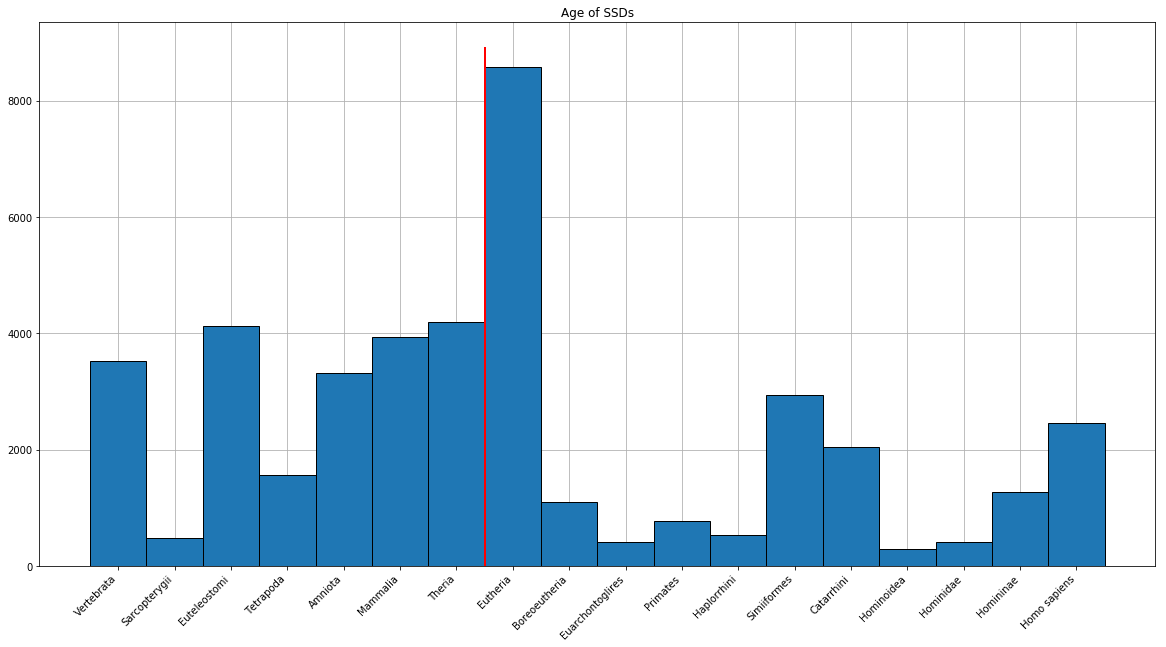

In [118]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(20,10))
ax.hist(age_list, histtype='bar', bins=np.arange(0,19,1), align='left', ec='k', zorder=20)
ax.xaxis.set_ticks(np.arange(0,18,1))
ax.xaxis.set_ticklabels(vert_list, ha = 'right')
ax.xaxis.set_tick_params(labelrotation = 45)
ax.plot(((np.median(age_list)+0.5), (np.median(age_list)+0.5)), (0,8900),color = 'r', linewidth=2, zorder = 57)
ax.grid(zorder=0)
ax.xaxis.set_label('Time of duplication')
ax.set_title('Age of SSDs')
plt.savefig('SSD_ages.png')
plt.show()

In [129]:
cursor.execute('''SELECT COUNT (DISTINCT id) FROM gene_features WHERE dup_type == "SSD"''')
cursor.fetchall()

[(6115,)]

In [2]:
# cursor.execute('''ALTER TABLE gene_features ADD COLUMN tax_levels TEXT''')
import time
vert_list =  ['Vertebrata', 'Sarcopterygii','Euteleostomi', 'Tetrapoda', 'Amniota', 'Mammalia', 'Theria', 'Eutheria','Boreoeutheria',  'Euarchontoglires', 'Primates', 'Haplorrhini', 'Simiiformes','Catarrhini', 'Hominoidea', 'Hominidae','Homininae', 'Homo sapiens']
cursor.execute('''SELECT id FROM gene_features WHERE dup_type == "SSD"''')
ids = [x[0] for x in cursor.fetchall()]
count, t = 0, time.time()
for i in ids:
    levels = []
    cursor.execute('''SELECT tax_group FROM paralogs WHERE id == ?''', (i,))
    tax_list = [x[0] for x in cursor.fetchall() if x[0] in vert_list]
    for tax in tax_list:
        levels.append(vert_list.index(tax)+1)
    levels = [str(x) for x in levels]
    out = ','.join(levels) + ' '
    cursor.execute('''UPDATE gene_features SET tax_levels = ? WHERE id == ?''', (out, i))
    count += 1
    if count % 150 == 0:
        print(count, 'done:')
        print(time.time()-t, 'seconds since started,')
        print((time.time()-t)/count, 'seconds per gene')
        print(' ')

150 done:
7.8932249546051025 seconds since started,
0.05262617270151774 seconds per gene
 
300 done:
15.089684009552002 seconds since started,
0.05030037641525269 seconds per gene
 
450 done:
22.49957799911499 seconds since started,
0.05000018013848199 seconds per gene
 
600 done:
29.450798988342285 seconds since started,
0.04908540328343709 seconds per gene
 
750 done:
36.48640489578247 seconds since started,
0.0486490306854248 seconds per gene
 
900 done:
43.62155890464783 seconds since started,
0.04846887985865275 seconds per gene
 
1050 done:
51.417542934417725 seconds since started,
0.04896938573746454 seconds per gene
 
1200 done:
58.28113889694214 seconds since started,
0.04856792171796163 seconds per gene
 
1350 done:
65.42120409011841 seconds since started,
0.04846029175652398 seconds per gene
 
1500 done:
72.45114803314209 seconds since started,
0.048301124731699625 seconds per gene
 
1650 done:
79.51969909667969 seconds since started,
0.04819379763169722 seconds per gene
 
1

In [3]:
db.commit()

In [19]:
import numpy as np
import re, time
# cursor.execute('''ALTER TABLE gene_features ADD COLUMN med_exp REAL''')
count, timer = 0, time.time()
with open('Downloads/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_median_tpm.gct', 'r') as med_file:
    for i in range(1,4):
        med_file.readline()
    for line in med_file:
        line = line.strip().split('\t')
        gene = re.search(r'(.*)\.(.*)', line[0]).group(1)
        exp = [float(x) for x in line[2:]]
        avg = np.median(exp)
        
        if max(exp) < 1:
            count += 1
        else:
            cursor.execute('''UPDATE gene_features SET med_exp = ? WHERE id == ?''', (avg, gene))
            count += 1
        if count % 1000 == 0:
            print(count, 'done.')
            print(time.time() - timer, 'since started.')
            print((time.time()-timer)/count, 'per gene.')
            print(' ')

1000 done.
9.799201965332031 since started.
0.00979967999458313 per gene.
 
2000 done.
18.057111978530884 since started.
0.009028785467147827 per gene.
 
3000 done.
25.756678104400635 since started.
0.008585681676864625 per gene.
 
4000 done.
35.66995310783386 since started.
0.008917577981948853 per gene.
 
5000 done.
43.878868103027344 since started.
0.008775835609436036 per gene.
 
6000 done.
51.63397693634033 since started.
0.00860573701063792 per gene.
 
7000 done.
59.79907989501953 since started.
0.008542776993342808 per gene.
 
8000 done.
67.70422410964966 since started.
0.008463086634874344 per gene.
 
9000 done.
77.35497498512268 since started.
0.00859505565961202 per gene.
 
10000 done.
86.84640502929688 since started.
0.008684684705734252 per gene.
 
11000 done.
94.54420900344849 since started.
0.008594953905452382 per gene.
 
12000 done.
102.94499611854553 since started.
0.008578785836696625 per gene.
 
13000 done.
110.4056761264801 since started.
0.008492777842741746 per ge

In [20]:
db.commit()

In [4]:
cursor.execute('''SELECT id FROM gene_features WHERE intron_count == 0''')
print(cursor.fetchall())

[('ENSG00000250719',), ('ENSG00000212916',), ('ENSG00000271567',), ('ENSG00000186564',), ('ENSG00000143105',), ('ENSG00000172410',), ('ENSG00000197617',), ('ENSG00000179546',), ('ENSG00000283039',), ('ENSG00000170385',), ('ENSG00000188396',), ('ENSG00000173627',), ('ENSG00000196539',), ('ENSG00000197454',), ('ENSG00000263353',), ('ENSG00000228336',), ('ENSG00000221888',), ('ENSG00000174529',), ('ENSG00000263464',), ('ENSG00000158615',), ('ENSG00000171357',), ('ENSG00000179862',), ('ENSG00000186150',), ('ENSG00000230667',), ('ENSG00000132703',), ('ENSG00000176022',), ('ENSG00000270188',), ('ENSG00000186790',), ('ENSG00000284188',), ('ENSG00000183598',), ('ENSG00000203811',), ('ENSG00000169442',), ('ENSG00000177272',), ('ENSG00000162396',), ('ENSG00000232237',), ('ENSG00000262180',), ('ENSG00000183155',), ('ENSG00000187140',), ('ENSG00000170128',), ('ENSG00000237330',), ('ENSG00000189181',), ('ENSG00000177275',), ('ENSG00000238243',), ('ENSG00000203757',), ('ENSG00000198841',), ('ENSG000

In [23]:
import requests, json
cursor.execute('SELECT trans_id FROM gene_features_all WHERE id ==  "ENSG00000099399"')
t = cursor.fetchall()[0][0]
h = {'Content-Type': 'application/json'}
url = "http://rest.ensembl.org/overlap/id/" + t + "?feature=exon"
r = requests.get(url, headers=h).json()
introns = []
exon_list = []
u_exon_list = []
cursor.execute('''SELECT start,end FROM gene_features WHERE id == ?''', ('ENSG00000099399',))
start, end = cursor.fetchall()[0]
for i in range(0, len(r)):
    if r[i]['Parent'] == t:
        exon_list.append((r[i]['start'], r[i]['end']))
exon_list = sorted(exon_list, key=lambda x: x[0])
for i in range(0, len(exon_list)):
    if i == 0:
        old_start = exon_list[i][0]
        old_end = exon_list[i][1]
    elif i == len(exon_list)-1 and exon_list[i][0] > old_end:#add current interval to list if this is the last value
        u_exon_list.append((old_start, old_end))
        u_exon_list.append((exon_list[i][0], exon_list[i][1]))
    elif (i == len(exon_list)-1) and exon_list[i][0] <= old_end: #if the last entry on the list has a higher end than current interval
        u_exon_list.append((old_start, exon_list[i][1]))
    else:
        if exon_list[i][0] < old_end:
            old_end = exon_list[i][1]
        else:
            u_exon_list.append((old_start, old_end))
            old_start = exon_list[i][0]
            old_end = exon_list[i][1]
print(u_exon_list)
for i in range(0, len(u_exon_list)):
    if i == 0:
        s = start
        if s != u_exon_list[i][0]: #case where there's an intron between gene start and 1st exon start
            introns.append((s,u_exon_list[i][0]))
            next_s = u_exon_list[i][1]
        else:
            next_s = u_exon_list[i][1] #if 1st exon start is gene start, set start of next intron and go to next
    elif i == len(u_exon_list)-1:
        introns.append((next_s, u_exon_list[i][0])) #for last exon, append preceding intron as normal then
        if end != u_exon_list[i][1]: #check for intron between end of last exon and gene end
            introns.append((u_exon_list[i][1], end))
    else:
        introns.append((next_s, u_exon_list[i][0]))
        next_s = u_exon_list[i][1]
print(len(introns))

[(1, 10), (15, 23), (24, 40)]
2


In [28]:
#essentiality
# cursor.execute('''ALTER TABLE gene_features ADD COLUMN ess_1 REAL''')
with open('Downloads/Wang_CRISPR.csv', 'r') as file:
    file.readline()
    for line in file:
        l = line.strip().split(',')
        geneName, KBM7, K562, Jiyoye, Raji = l[0], float(l[2]), float(l[4]), float(l[6]), float(l[8])
        ess = KBM7
        cursor.execute('''UPDATE gene_features SET ess_1 = ? WHERE name == ?''', 
                       (ess, geneName))
        db.commit()

In [32]:
cursor.execute('SELECT ess_1 FROM gene_features WHERE (NOT ess_1 IS NULL) AND dup_type == "WGD"')
w_list = [x[0] for x in cursor.fetchall()]
cursor.execute('SELECT ess_1 FROM gene_features WHERE (NOT ess_1 IS NULL) AND dup_type == "SSD"')
s_list = [x[0] for x in cursor.fetchall()]
from scipy import stats 
stats.mannwhitneyu(w_list, s_list)

MannwhitneyuResult(statistic=10648779.0, pvalue=0.0598315775792419)

In [72]:
with open('Downloads/biogrid_human_interactions.txt', 'r') as file:
    header = file.readline().strip().split('\t')
    line = file.readline().strip().split('\t')

    for i in range(0,len(header)):
        print(i, header[i], ':', line[i])

0 #BioGRID Interaction ID : 103
1 Entrez Gene Interactor A : 6416
2 Entrez Gene Interactor B : 2318
3 BioGRID ID Interactor A : 112315
4 BioGRID ID Interactor B : 108607
5 Systematic Name Interactor A : -
6 Systematic Name Interactor B : -
7 Official Symbol Interactor A : MAP2K4
8 Official Symbol Interactor B : FLNC
9 Synonyms Interactor A : JNKK|JNKK1|MAPKK4|MEK4|MKK4|PRKMK4|SAPKK-1|SAPKK1|SEK1|SERK1|SKK1
10 Synonyms Interactor B : ABP-280|ABP280A|ABPA|ABPL|FLN2|MFM5|MPD4
11 Experimental System : Two-hybrid
12 Experimental System Type : physical
13 Author : Marti A (1997)
14 Pubmed ID : 9006895
15 Organism Interactor A : 9606
16 Organism Interactor B : 9606
17 Throughput : Low Throughput
18 Score : -
19 Modification : -
20 Phenotypes : -
21 Qualifications : -
22 Tags : -
23 Source Database : BIOGRID


In [72]:
import requests, json, time
int_dict = {}
problem_list = []
head = {'Content-Type':'application/json'}
with open('Downloads/biogrid_human_interactions.txt', 'r') as file:
    header = file.readline().strip().split('\t')
    count, t = 0, time.time()
    for line in file:
        ID, ID2 = None, None
        line = line.strip().split('\t')
        if line[12] != 'physical':
            continue   
        elif line[15] != '9606' or line[16] != '9606':
            continue
        else:
            try:
                ID = get_id_from_entrez_id(line[1])
                ID2 = get_id_from_entrez_id(line[2])
                count += 1
            except ValueError:
                continue
        if not(ID and ID2):
            print(line[1], line[2])
        elif not ID:
            print(line[1])
        elif not ID2:
            print(line[2])
        else:
            try:
                int_dict[ID] += 1
            except KeyError:
                int_dict[ID] = 1
            try:
                int_dict[ID] += 1
            except KeyError:
                int_dict[ID] = 1
        if count % 500 == 0 and count != 0:
            print(count, 'done:', time.time()-t, 'seconds in')
        if count/(time.time()-t) > 14:
            time.sleep(1)
            
#maybe just give up and use the database to match up names to ids??

500 done: 169.44456601142883 seconds in
1000 done: 259.15675115585327 seconds in
1500 done: 336.95331621170044 seconds in
2000 done: 419.03894114494324 seconds in
2500 done: 496.74036502838135 seconds in
3000 done: 575.5474061965942 seconds in
3500 done: 655.6971590518951 seconds in
4000 done: 734.3311741352081 seconds in
4500 done: 813.0072431564331 seconds in
5000 done: 893.9380271434784 seconds in
5500 done: 976.319324016571 seconds in
6000 done: 1055.930311203003 seconds in
6500 done: 1137.4131050109863 seconds in
7000 done: 1217.2722010612488 seconds in
7500 done: 1297.6520581245422 seconds in
8000 done: 1378.9635791778564 seconds in
8500 done: 1458.1583180427551 seconds in
9000 done: 1545.0719211101532 seconds in
9500 done: 1624.2135791778564 seconds in
10000 done: 1705.4289751052856 seconds in
10500 done: 1786.9134550094604 seconds in
11000 done: 1867.4830420017242 seconds in
11500 done: 1946.7107532024384 seconds in
12000 done: 2026.6322820186615 seconds in
12500 done: 2107.139

100000 done: 25372.823854207993 seconds in
100500 done: 25752.640269994736 seconds in
101000 done: 25904.536687135696 seconds in
101500 done: 26002.102015018463 seconds in
102000 done: 26096.613166093826 seconds in
102500 done: 26193.03155207634 seconds in
103000 done: 26287.27567100525 seconds in
103500 done: 26381.33799314499 seconds in
104000 done: 26475.235722064972 seconds in
104500 done: 26570.49044919014 seconds in
105000 done: 26662.95664715767 seconds in
105500 done: 26756.03718805313 seconds in
106000 done: 26847.23738718033 seconds in
106500 done: 26937.063172101974 seconds in
107000 done: 27028.097074985504 seconds in
107500 done: 27122.94894504547 seconds in
108000 done: 27218.970719099045 seconds in
108500 done: 27311.084925174713 seconds in
109000 done: 27399.62830710411 seconds in
109500 done: 27499.956856012344 seconds in
110000 done: 27588.471832036972 seconds in
110500 done: 27676.739624023438 seconds in
111000 done: 27763.2965760231 seconds in
111500 done: 27854.942

197000 done: 48303.96384716034 seconds in
197500 done: 48382.661159038544 seconds in
198000 done: 48461.5867869854 seconds in
198500 done: 48540.22635316849 seconds in
199000 done: 48619.40514206886 seconds in
199500 done: 48698.99296998978 seconds in
200000 done: 48778.19217419624 seconds in
200500 done: 48857.37729716301 seconds in
201000 done: 48936.695006132126 seconds in
201500 done: 49014.97808814049 seconds in
202000 done: 49094.273933172226 seconds in
202500 done: 49172.59267807007 seconds in
203000 done: 49252.72162413597 seconds in
203500 done: 49333.16713118553 seconds in
204000 done: 49412.450003147125 seconds in
204500 done: 49492.44078707695 seconds in
205000 done: 49571.3485121727 seconds in
205500 done: 49650.60924100876 seconds in
206000 done: 49729.84805703163 seconds in
206500 done: 49808.29270219803 seconds in
207000 done: 49888.436858177185 seconds in
207500 done: 49968.78303003311 seconds in
208000 done: 50048.18047904968 seconds in
208500 done: 50127.271131038666

294500 done: 63749.70147919655 seconds in
295000 done: 63827.684509038925 seconds in
295500 done: 63906.2622191906 seconds in
296000 done: 63984.596855163574 seconds in
296500 done: 64062.80964112282 seconds in
297000 done: 64140.36874818802 seconds in
297500 done: 64218.48073720932 seconds in
298000 done: 64296.02735900879 seconds in
298500 done: 64373.768334150314 seconds in
299000 done: 64453.7456882 seconds in
299500 done: 64533.08526110649 seconds in
300000 done: 64612.42749500275 seconds in
300500 done: 64691.07411503792 seconds in
301000 done: 64769.16986703873 seconds in
301500 done: 64848.26054215431 seconds in
302000 done: 64925.79348897934 seconds in
302500 done: 65006.38874411583 seconds in
303000 done: 65089.097038030624 seconds in
303500 done: 65169.59868502617 seconds in
304000 done: 65247.29194998741 seconds in
304500 done: 65327.333948135376 seconds in
305000 done: 65407.03395104408 seconds in
305500 done: 65485.916540145874 seconds in
306000 done: 65564.25748205185 se

In [122]:
def get_id_from_entrez_id(entrez_id):
    
    import requests, json, sqlite3
    from requests import ConnectTimeout, ReadTimeout
    db = sqlite3.connect('./database')
    db.isolation_level = None
    cursor = db.cursor()
    
    head = {'Content-Type':'application/json'}
    url = 'http://rest.ensembl.org/xrefs/name/human/' + entrez_id + '?external_db=EntrezGene'
    try:
        r = requests.get(url, headers=head, timeout = 5)
    except (ConnectTimeout, ReadTimeout) as e:
        raise RuntimeError('timed out')
    try:
        r = r.json()
    except ValueError:
        raise RuntimeError('request failed')
    
    if len(r) != 1:
        
        if len(r) > 1:
            raise ValueError('Multiple results:', entrez_id)

        else:
            raise LookupError('Query returned empty:', entrez_id)
    else:
        cursor.execute('''SELECT id FROM gene_features WHERE name == ?''', (r[0]['display_id'],))
        try:
            return(cursor.fetchall()[0][0])
        except IndexError:
            return(None)
        

In [73]:
db.commit()

In [77]:
import time
# cursor.execute('''ALTER TABLE gene_features ADD COLUMN PPIs INTEGER''')
count, t = 0, time.time()
for k in int_dict:
    cursor.execute('''UPDATE gene_features SET PPIs = ? WHERE id == ?''', (int_dict[k], k))
    count += 1
    if count % 500 == 0:
        print(count, round(time.time()-t,2), 'seconds')

500 6.82 seconds
1000 13.72 seconds
1500 20.87 seconds
2000 27.5 seconds
2500 34.31 seconds
3000 41.02 seconds
3500 47.81 seconds
4000 54.61 seconds
4500 61.46 seconds
5000 68.22 seconds
5500 75.02 seconds
6000 81.69 seconds
6500 88.46 seconds
7000 96.14 seconds
7500 103.11 seconds
8000 110.03 seconds
8500 116.93 seconds
9000 124.35 seconds
9500 131.89 seconds
10000 139.58 seconds
10500 146.77 seconds
11000 154.22 seconds
11500 161.07 seconds
12000 168.82 seconds
12500 175.67 seconds
13000 183.1 seconds


In [80]:
cursor.execute('''UPDATE gene_features SET PPIs = 0 WHERE PPIs IS NULL''')
db.commit()

In [123]:
cursor.execute('''UPDATE gene_features SET PPIs = NULL''')
with open('Downloads/biogrid_human_interactions.txt', 'r') as file:
    count, t = 0, time.time()
    int_list, fail_list = [], []
    file.readline()
    multi_list, empty_list = [],[]
    print('Creating list:')
    for line in file:
        success = False
        t0 = time.time()
        line = line.strip().split('\t')
        if line[12] != 'physical':
            continue   
        elif line[15] != '9606' or line[16] != '9606':
            continue
        else:
            try:
                id1 = get_id_from_entrez_id(line[1])
                int_list.append(id1)
            except ValueError:
                multi_list.append(line[1])
            except LookupError:
                empty_list.append(line[1])
            except RuntimeError:
                fail_list.append(line[1])
           
            try:
                id2 = get_id_from_entrez_id(line[2])
                int_list.append(id2)
            except ValueError:
                multi_list.append(line[2])
            except LookupError:
                empty_list.append(line[2])
            except RuntimeError:
                fail_list.append(line[2])
            count += 1
        
        if count % 1000 == 0:
            print(count, 'done:', round(time.time()-t,2), 'seconds')
            
    print('retrying failed requests...', len(fail_list))
    while fail_list != []:
        for i in fail_list:
            try:
                id1 = get_id_from_entrez_id(i)
                int_list.append(id1)
                fail_list.remove(i)
            except ValueError:
                multi_list.append(i)
                fail_list.remove(i)
            except LookupError:
                empty_list.append(i)
                fail_list.remove(i)
            except RuntimeError:
                continue
cursor.execute('''SELECT id FROM gene_features''')
id_list = [x[0] for x in cursor.fetchall()]
print('Updating table:')
count, t = 0, time.time()
for i in id_list:
    cursor.execute('''UPDATE gene_features SET PPIs = ? WHERE id == ?''', (int_list.count(i), i))
    count += 1
    if count % 500 == 0:
        print(count, 'done:', round(time.time()-t, 2), 'seconds')

Creating list:
1000 done: 168.01 seconds
2000 done: 333.78 seconds
3000 done: 492.01 seconds
4000 done: 650.09 seconds
5000 done: 810.61 seconds
6000 done: 969.63 seconds
7000 done: 1134.85 seconds
8000 done: 1296.15 seconds
9000 done: 1455.5 seconds
10000 done: 1609.94 seconds
11000 done: 1771.7 seconds
12000 done: 1930.23 seconds
13000 done: 2089.19 seconds
14000 done: 2247.27 seconds
15000 done: 2402.84 seconds
16000 done: 2568.38 seconds
17000 done: 2734.77 seconds
18000 done: 2896.03 seconds
19000 done: 3053.14 seconds
20000 done: 3228.0 seconds
21000 done: 3385.85 seconds
22000 done: 3547.47 seconds
23000 done: 3705.64 seconds
24000 done: 3868.51 seconds
25000 done: 4028.91 seconds
26000 done: 4188.23 seconds
27000 done: 4347.04 seconds
28000 done: 4505.74 seconds
29000 done: 4663.79 seconds
30000 done: 4821.14 seconds
31000 done: 5031.03 seconds
32000 done: 5192.95 seconds
33000 done: 5353.59 seconds
34000 done: 5510.7 seconds
35000 done: 5667.98 seconds
36000 done: 5824.12 seco

281000 done: 46703.86 seconds
282000 done: 46862.66 seconds
283000 done: 47040.55 seconds
284000 done: 47218.55 seconds
285000 done: 47411.34 seconds
286000 done: 47593.12 seconds
287000 done: 47788.32 seconds
288000 done: 47954.76 seconds
289000 done: 48121.04 seconds
290000 done: 48299.23 seconds
291000 done: 48488.71 seconds
292000 done: 48667.47 seconds
293000 done: 48829.89 seconds
294000 done: 48998.54 seconds
295000 done: 49172.54 seconds
296000 done: 49346.83 seconds
297000 done: 49512.36 seconds
298000 done: 49673.0 seconds
299000 done: 49832.48 seconds
300000 done: 49989.18 seconds
301000 done: 50147.23 seconds
302000 done: 50304.04 seconds
303000 done: 50457.22 seconds
304000 done: 50613.05 seconds
305000 done: 50770.7 seconds
306000 done: 50927.52 seconds
307000 done: 51084.02 seconds
308000 done: 51243.52 seconds
309000 done: 51401.33 seconds
310000 done: 51555.64 seconds
311000 done: 51714.09 seconds
312000 done: 51876.76 seconds
313000 done: 52034.76 seconds
314000 done:

In [121]:
from requests import ConnectTimeout, ReadTimeout
try:
    r = requests.get(url, headers={'Content-Type':'application/json'}, timeout=0.001)
    print(r.json())
except (ConnectTimeout, ReadTimeout) as e:
    print('Caught the timeout!')


Caught the timeout!


In [111]:
print(tab)

Table 1 Standard, SGC0

  |  T      |  C      |  A      |  G      |
--+---------+---------+---------+---------+--
T | TTT F   | TCT S   | TAT Y   | TGT C   | T
T | TTC F   | TCC S   | TAC Y   | TGC C   | C
T | TTA L   | TCA S   | TAA Stop| TGA Stop| A
T | TTG L(s)| TCG S   | TAG Stop| TGG W   | G
--+---------+---------+---------+---------+--
C | CTT L   | CCT P   | CAT H   | CGT R   | T
C | CTC L   | CCC P   | CAC H   | CGC R   | C
C | CTA L   | CCA P   | CAA Q   | CGA R   | A
C | CTG L(s)| CCG P   | CAG Q   | CGG R   | G
--+---------+---------+---------+---------+--
A | ATT I   | ACT T   | AAT N   | AGT S   | T
A | ATC I   | ACC T   | AAC N   | AGC S   | C
A | ATA I   | ACA T   | AAA K   | AGA R   | A
A | ATG M(s)| ACG T   | AAG K   | AGG R   | G
--+---------+---------+---------+---------+--
G | GTT V   | GCT A   | GAT D   | GGT G   | T
G | GTC V   | GCC A   | GAC D   | GGC G   | C
G | GTA V   | GCA A   | GAA E   | GGA G   | A
G | GTG V   | GCG A   | GAG E   | GGG G   | G
--+---------

In [123]:
from Bio.Seq import Seq
from Bio.codonalign.codonalphabet import default_codon_table
from Bio.Data.CodonTable import unambiguous_dna_by_id
from Bio.codonalign import CodonSeq
import Bio.codonalign.codonseq as codonseq
import requests, json
cursor.execute('''SELECT id, ohno_id FROM ohnologs_gene_ids WHERE vertebrate == "Yes"''')
# cursor.execute('''SELECT id, para FROM paralogs''')
result = cursor.fetchall()[:50]
pair_list = [x for x in result]

for a,b in pair_list:
    header = {'Content-type':'application/json'}
    
    url1 = 'https://rest.ensembl.org/sequence/id/' + a + '?type=cds;multiple_sequences=1'
    r1 = requests.get(url1, headers=header).json()
#     s1 = longest_cds(r1).replace('T','U')
    s1 = longest_cds(r1)[:-3]
    c1 = CodonSeq(s1)
    
    url2 = 'https://rest.ensembl.org/sequence/id/' + b + '?type=cds;multiple_sequences=1'
    r2 = requests.get(url2, headers=header, timeout=5).json()
#     s2 = longest_cds(r2).replace('T','U')
    s2 = longest_cds(r2)[:-3]
    c2 = CodonSeq(s2)
    
    tab = unambiguous_dna_by_id[1]
    d = codonseq.cal_dn_ds(c1,c2, codon_table=tab)
    print(d)

RuntimeError: full_rf_table length of seq1 (176) and seq2 (79) are not the same

In [20]:
def longest_cds(json_response):
    if len(json_response) != 1:
        for x in json_response:
            s = x['seq']
            l = len(s)
            if json_response.index(x) == 0:
                old_l = l
                l_s = s
            else:
                if l > old_l:
                    old_l = l
                    l_s = s
    else:
        l_s = json_response[0]['seq']

    return(l_s)

In [125]:
s1

'ATGGCGGCGGCGCCAGCGGTGTGCGCCTCGCAGGGGAGCCCGCCGGGTGCACCGTCCGCGCCGGCGGCCGCGCCAGCACCCGCGGCCGGCCTGGGCCGCTGCCGGATGGCGCTGCTGCTGGCCGTGGCGCTGGATGTGGCGGGCATGGCGGCGCTGCTGACCGGCGTGTTCGCGCAGCTGCAGGTGCGCGGCCGCGACTTCGGGGACCTGCTCATCTACTCGGGCGCGCTGCTGGTGTTCCTGAGCCTGCTGGGCTGGATCCTCTGGTACACCGGCAACATCGAGATCTCGCGCCAGGAGCTGGAGCGCGACTACGGCCTGCGGCCCTCGGCGCTCGCCCGCCTGGCGCGCAAGCTCTCCCGCCGCTGGTCGGCGCCCGCCGCCGCGGGCCAGCGCCCCGCGCCCGGCTCCCGGAGAGCGCGCCGAGCCGCCCGCGCGCCCCCGCCGCCCGCCGCCGGCTCCCGCCGCGTGCGCCTGCAGCTCGCCACGCTCGAGGCCGGGCCCGGGGCGGCGGGCGCGGGCAGCGAG'

In [126]:
s2

'ATGCTCCTGGGGAGTCTGTGGGGAAGATGCCATCCAGGGCGCTGTGCGCTCTTCCTCATCCTCGCCCTCCTGCTGGACGCGGTCGGCCTGGTCCTTTTGCTGCTGGGGATCTTGGCCCCCCTGAGTTCCTGGGACTTCTTCATCTACACAGGTGCCCTGATCCTGGCTCTCAGCCTACTGCTCTGGATCATCTGGTATTCCCTCAACATTGAGGTGTCTCCTGAAAAACTGGACCTG'

In [100]:
print(standard_dna_table)

Table 1 Standard, SGC0

  |  T      |  C      |  A      |  G      |
--+---------+---------+---------+---------+--
T | TTT F   | TCT S   | TAT Y   | TGT C   | T
T | TTC F   | TCC S   | TAC Y   | TGC C   | C
T | TTA L   | TCA S   | TAA Stop| TGA Stop| A
T | TTG L(s)| TCG S   | TAG Stop| TGG W   | G
--+---------+---------+---------+---------+--
C | CTT L   | CCT P   | CAT H   | CGT R   | T
C | CTC L   | CCC P   | CAC H   | CGC R   | C
C | CTA L   | CCA P   | CAA Q   | CGA R   | A
C | CTG L(s)| CCG P   | CAG Q   | CGG R   | G
--+---------+---------+---------+---------+--
A | ATT I   | ACT T   | AAT N   | AGT S   | T
A | ATC I   | ACC T   | AAC N   | AGC S   | C
A | ATA I   | ACA T   | AAA K   | AGA R   | A
A | ATG M(s)| ACG T   | AAG K   | AGG R   | G
--+---------+---------+---------+---------+--
G | GTT V   | GCT A   | GAT D   | GGT G   | T
G | GTC V   | GCC A   | GAC D   | GGC G   | C
G | GTA V   | GCA A   | GAA E   | GGA G   | A
G | GTG V   | GCG A   | GAG E   | GGG G   | G
--+---------

In [90]:
c2.get_codon(176)

'UGA'

In [104]:
standard_dna_table.back_table['TTA']

KeyError: 'TTA'

In [113]:
tab.forward_table

{'AAA': 'K',
 'AAC': 'N',
 'AAG': 'K',
 'AAT': 'N',
 'ACA': 'T',
 'ACC': 'T',
 'ACG': 'T',
 'ACT': 'T',
 'AGA': 'R',
 'AGC': 'S',
 'AGG': 'R',
 'AGT': 'S',
 'ATA': 'I',
 'ATC': 'I',
 'ATG': 'M',
 'ATT': 'I',
 'CAA': 'Q',
 'CAC': 'H',
 'CAG': 'Q',
 'CAT': 'H',
 'CCA': 'P',
 'CCC': 'P',
 'CCG': 'P',
 'CCT': 'P',
 'CGA': 'R',
 'CGC': 'R',
 'CGG': 'R',
 'CGT': 'R',
 'CTA': 'L',
 'CTC': 'L',
 'CTG': 'L',
 'CTT': 'L',
 'GAA': 'E',
 'GAC': 'D',
 'GAG': 'E',
 'GAT': 'D',
 'GCA': 'A',
 'GCC': 'A',
 'GCG': 'A',
 'GCT': 'A',
 'GGA': 'G',
 'GGC': 'G',
 'GGG': 'G',
 'GGT': 'G',
 'GTA': 'V',
 'GTC': 'V',
 'GTG': 'V',
 'GTT': 'V',
 'TAC': 'Y',
 'TAT': 'Y',
 'TCA': 'S',
 'TCC': 'S',
 'TCG': 'S',
 'TCT': 'S',
 'TGC': 'C',
 'TGG': 'W',
 'TGT': 'C',
 'TTA': 'L',
 'TTC': 'F',
 'TTG': 'L',
 'TTT': 'F'}

In [124]:
c1.get_full_rf_table()

[0,
 3,
 6,
 9,
 12,
 15,
 18,
 21,
 24,
 27,
 30,
 33,
 36,
 39,
 42,
 45,
 48,
 51,
 54,
 57,
 60,
 63,
 66,
 69,
 72,
 75,
 78,
 81,
 84,
 87,
 90,
 93,
 96,
 99,
 102,
 105,
 108,
 111,
 114,
 117,
 120,
 123,
 126,
 129,
 132,
 135,
 138,
 141,
 144,
 147,
 150,
 153,
 156,
 159,
 162,
 165,
 168,
 171,
 174,
 177,
 180,
 183,
 186,
 189,
 192,
 195,
 198,
 201,
 204,
 207,
 210,
 213,
 216,
 219,
 222,
 225,
 228,
 231,
 234,
 237,
 240,
 243,
 246,
 249,
 252,
 255,
 258,
 261,
 264,
 267,
 270,
 273,
 276,
 279,
 282,
 285,
 288,
 291,
 294,
 297,
 300,
 303,
 306,
 309,
 312,
 315,
 318,
 321,
 324,
 327,
 330,
 333,
 336,
 339,
 342,
 345,
 348,
 351,
 354,
 357,
 360,
 363,
 366,
 369,
 372,
 375,
 378,
 381,
 384,
 387,
 390,
 393,
 396,
 399,
 402,
 405,
 408,
 411,
 414,
 417,
 420,
 423,
 426,
 429,
 432,
 435,
 438,
 441,
 444,
 447,
 450,
 453,
 456,
 459,
 462,
 465,
 468,
 471,
 474,
 477,
 480,
 483,
 486,
 489,
 492,
 495,
 498,
 501,
 504,
 507,
 510,
 513,
 516,


In [132]:
from Bio.Align.Applications import ClustalOmegaCommandline as clustal
import requests, json
import time
cursor.execute('''SELECT id, ohno_id FROM ohnologs_gene_ids WHERE vertebrate == "Yes"''')
result = cursor.fetchall()
pair_list = [x for x in result]

count, t = 0, time.time()
for a,b in pair_list:
    filename = a + '_' + b + '.out'
    header = {'Content-type':'application/json'}

    url1 = 'https://rest.ensembl.org/sequence/id/' + a + '?type=cds;multiple_sequences=1'
    r1 = requests.get(url1, headers=header).json()
    s1 = longest_cds(r1)[:-3]
    s1_head = '>' + a

    url2 = 'https://rest.ensembl.org/sequence/id/' + b + '?type=cds;multiple_sequences=1'
    r2 = requests.get(url2, headers=header, timeout=5).json()
    s2 = longest_cds(r2)[:-3]
    s2_head = '>' + b
    
    with open(filename, 'w') as fasta:
        fasta.write(s1_head)
        fasta.write(s1)
        fasta.write(s2_head)
        fasta.write(s2)
    count += 1
    if count % 100 == 0:
        print(count, time.time()-t)

100 41.28053879737854
200 86.81008887290955
300 130.8121919631958
400 178.72353982925415
500 220.0891878604889
600 266.8227458000183
700 319.642600774765
800 366.06183195114136
900 414.43287777900696
1000 464.06895995140076
1100 513.6646709442139
1200 564.9264099597931
1300 615.1662139892578
1400 668.0714237689972
1500 716.278559923172
1600 763.2004389762878
1700 813.5338227748871
1800 860.8491468429565
1900 916.8358218669891
2000 993.8001019954681
2100 1062.1074459552765
2200 1125.8837909698486
2300 1197.2590818405151
2400 1262.9054698944092
2500 1337.9891788959503
2600 1403.519880771637
2700 1464.3292179107666
2800 1538.1063997745514
2900 1589.0712478160858
3000 1638.561064004898
3100 1687.3393709659576
3200 1735.2281630039215
3300 1781.9457747936249
3400 1832.8472929000854
3500 1881.6244127750397
3600 1930.013100862503
3700 1979.1127038002014
3800 2030.1485137939453
3900 2080.3187317848206
4000 2128.309663772583
4100 2172.887627840042
4200 2221.222487926483
4300 2265.7636637687683
4

In [45]:
import requests
url = 'http://grch37.rest.ensembl.org/info/assembly/gallus_gallus'
r = requests.get(url, headers = {'Content-type':'application/json'}).json()
r

{'assembly_accession': 'GCA_000002315.2',
 'assembly_date': '2011-11',
 'assembly_name': 'Galgal4',
 'coord_system_versions': ['Galgal4'],
 'default_coord_system_version': 'Galgal4',
 'genebuild_initial_release_date': '2013-04',
 'genebuild_last_geneset_update': '2013-12',
 'genebuild_method': 'full_genebuild',
 'genebuild_start_date': '2011-12-Ensembl',
 'karyotype': ['1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  '10',
  '11',
  '12',
  '13',
  '14',
  '15',
  '16',
  '17',
  '18',
  '19',
  '20',
  '21',
  '22',
  '23',
  '24',
  '25',
  '26',
  '27',
  '28',
  '32',
  'W',
  'Z',
  'LGE22C19W28_E50C23',
  'LGE64',
  'MT'],
 'top_level_region': [{'coord_system': 'scaffold',
   'length': 1468,
   'name': 'AADN03010001.1'},
  {'coord_system': 'scaffold', 'length': 12169, 'name': 'JH375167.1'},
  {'coord_system': 'scaffold', 'length': 1518, 'name': 'AADN03010003.1'},
  {'coord_system': 'scaffold', 'length': 1107, 'name': 'AADN03010004.1'},
  {'coord_system': 'scaffold',

In [45]:
missingList = []
#excluding likely retrogenes
# cursor.execute('ALTER TABLE paralogs ADD COLUMN retro TEXT')
cursor.execute('SELECT id, para FROM paralogs')
res = cursor.fetchall()
for a,b in res:
    countA, countB = None,None

    cursor.execute('SELECT id, intron_count FROM gene_features WHERE id == ? OR id == ?', (a,b))
    res2 = cursor.fetchall()
    try:

        countA = [x[1] for x in res2 if x[0] == a][0]
    except IndexError:
        missingList.append(a)
        print('missing A')
        print(a,b)
        try:
            countB = [x[1] for x in res2 if x[0] == b][0]
        except IndexError:
            missingList.append(b)
            print('...and B')
            continue
    try:
 
        countB = [x[1] for x in res2 if x[0] == b][0]
    except Exception as e:
        missingList.append(b)
        print(e,'missing B')
        print(a,b)
        continue

    if (countA == 0 or countB == 0) and (countA != 0 or countB != 0):
        cursor.execute('UPDATE paralogs SET retro = "T" WHERE id == ? AND para == ?', (a,b))

db.commit()      


list index out of range missing B
ENSG00000010379 ENSG00000273554
list index out of range missing B
ENSG00000011083 ENSG00000273554
list index out of range missing B
ENSG00000019102 ENSG00000277666


KeyboardInterrupt: 

In [75]:
# conserved synteny attempt
# work through the list of genes in order 
cursor.execute('SELECT chrom, start, end, id FROM gene_features')
res = cursor.fetchall()

cursor.execute('''SELECT id, para FROM new_paralogs WHERE singleton != "T"''')
paraRes = cursor.fetchall()

chromList = [x for x in range(1,23)]
chromList.extend(['X','Y'])

orderedGeneDict = {}
for c in chromList:
    resList = [x[1:] for x in res if x[0] == c] #check string/int situations tomorrow
    resList = sorted(resList, key = lambda x: x[0] if x[0] < x[1] else x[1])
    dictEntry = [x[2] for x in resList]
    
    orderedGeneDict[c] = dictEntry
syntenicPairs = 0
for i, p in paraRes:
    cursor.execute('SELECT chrom, id FROM gene_features WHERE id == ? OR id == ?', (i,p))
    res2 = cursor.fetchall()
    if len(res2) != 2:
        print('something missing!')
        print(i,p)
        print('')
        continue
    c1 = [x[0] for x in res2 if x[1] == i][0]
    c2 = [x[0] for x in res2 if x[1] == p][0]
    
    chromList1 = orderedGeneDict[c1]
    chromList2 = orderedGeneDict[c2]
    
    ind1 = chromList1.index(i)
    if ind1 < 5:
        geneListLeft1 = chromList1[0:ind1]
    elif ind1 == 0:
        print(i,p, 'Gene is first on chromosome')
        continue
    elif ind1 > len(chromList1)-6: # -6 because of 0 indexing
        print('Warning: gene within 5 genes of end of chromosome')
        geneListRight1 = chromList1[ind1+1:len(chromList1)-1]
        
    elif ind1 == len(chromList1)-1:
        print(i,p, 'Gene is last on chromosome')
        continue
    else:
        startInd1 = ind1 - 5
        endInd1 = ind1 + 6 #because of 'up to but not including'
        
        geneListLeft1 = chromList1[startInd1:ind1]
        geneListRight1 = chromList1[ind1+1:endInd1]
    
    ind2 = chromList2.index(p)
    if ind2 < 5:
        geneListLeft2 = chromList2[0:ind2]
    elif ind2 == 0:
        print(i,p, 'Paralog is first on chromosome')
        continue
    elif ind2 > len(chromList2)-6: # -6 because of 0 indexing
        print('Warning: paralog within 5 genes of chromsome end')
        geneListRight2 = chromList2[ind2+1:len(chromList2)]
        
    elif ind2 == len(chromList2)-1:
        print(i,p, 'Paralog is last on chromosome')
        continue
    else:
        startInd2 = ind2 - 5
        endInd2 = ind2 + 6 #because of 'up to but not including'
        
        geneListLeft2 = chromList2[startInd2:ind2]
        geneListRight2 = chromList2[(ind2+1):endInd2]
        
    matchListLeft, matchListRight = [],[]
    t = time.time()
    for a,b in itertools.product(geneListLeft1,geneListLeft2):
        if time.time()-t > 20:
            break
        if (a,b) in paraRes or (b,a) in paraRes:
            #genes are paralogous
            if not((a,b) in matchListLeft or (b,a) in matchListLeft):
                matchListLeft.append((a,b))
    for a,b in itertools.product(geneListRight1,geneListRight2):
        if time.time()-t > 40:
            break
        if (a,b) in paraRes or (b,a) in paraRes:
            #genes are paralogous
            if not((a,b) in matchListRight or (b,a) in matchListRight):
                matchListRight.append((a,b))
    if sum([len(matchListLeft),len(matchListRight)]) >= 2:
        syntenicPairs += 1
print(syntenicPairs)
        
        
    
    # do eleven at a time then increment all indexes?? (so 5....focal gene....5 more)
    # ^that won't work you dolt, you need to get paralog pairs and then look at synteny

something missing!
ENSG00000117298 ENSG00000284917

something missing!
ENSG00000176148 ENSG00000284800

something missing!
ENSG00000142552 ENSG00000285283

something missing!
ENSG00000128656 ENSG00000285162

something missing!
ENSG00000154945 ENSG00000167117

something missing!
ENSG00000177476 ENSG00000237988

something missing!
ENSG00000177476 ENSG00000284824

something missing!
ENSG00000116704 ENSG00000285269

something missing!
ENSG00000197013 ENSG00000268696

something missing!
ENSG00000018625 ENSG00000285505

something missing!
ENSG00000166046 ENSG00000284800

something missing!
ENSG00000228049 ENSG00000285437

something missing!
ENSG00000184005 ENSG00000257524

something missing!
ENSG00000164112 ENSG00000284849

something missing!
ENSG00000284862 ENSG00000145075

something missing!
ENSG00000118620 ENSG00000268696

something missing!
ENSG00000111642 ENSG00000285238

something missing!
ENSG00000205030 ENSG00000186886

something missing!
ENSG00000174339 ENSG00000237988

something mi

something missing!
ENSG00000166261 ENSG00000285329

something missing!
ENSG00000267645 ENSG00000285437

something missing!
ENSG00000196150 ENSG00000285447

something missing!
ENSG00000270249 ENSG00000284981

something missing!
ENSG00000270249 ENSG00000272949

something missing!
ENSG00000168255 ENSG00000285437

something missing!
ENSG00000272602 ENSG00000268696

something missing!
ENSG00000103199 ENSG00000285329

something missing!
ENSG00000238243 ENSG00000237988

something missing!
ENSG00000238243 ENSG00000284824

something missing!
ENSG00000198939 ENSG00000285447

something missing!
ENSG00000149600 ENSG00000285382

something missing!
ENSG00000285043 ENSG00000149925

something missing!
ENSG00000285043 ENSG00000109107

something missing!
ENSG00000285043 ENSG00000136872

something missing!
ENSG00000284776 ENSG00000125821

something missing!
ENSG00000196705 ENSG00000268696

something missing!
ENSG00000204700 ENSG00000237988

something missing!
ENSG00000204700 ENSG00000284824

something mi

something missing!
ENSG00000160229 ENSG00000268696

something missing!
ENSG00000171014 ENSG00000280709

something missing!
ENSG00000171014 ENSG00000285472

something missing!
ENSG00000128595 ENSG00000285283

something missing!
ENSG00000284934 ENSG00000184047

something missing!
ENSG00000075035 ENSG00000285471

something missing!
ENSG00000132681 ENSG00000285505

something missing!
ENSG00000181652 ENSG00000284820

something missing!
ENSG00000124678 ENSG00000284800

something missing!
ENSG00000204702 ENSG00000237988

something missing!
ENSG00000204702 ENSG00000284824

something missing!
ENSG00000204701 ENSG00000237988

something missing!
ENSG00000204701 ENSG00000284824

something missing!
ENSG00000137285 ENSG00000173213

something missing!
ENSG00000013297 ENSG00000285218

something missing!
ENSG00000196242 ENSG00000284824

something missing!
ENSG00000196242 ENSG00000237988

something missing!
ENSG00000177489 ENSG00000237988

something missing!
ENSG00000177489 ENSG00000284824

something mi

something missing!
ENSG00000160408 ENSG00000257524

something missing!
ENSG00000198039 ENSG00000268696

something missing!
ENSG00000243566 ENSG00000284981

something missing!
ENSG00000243566 ENSG00000272949

something missing!
ENSG00000051180 ENSG00000285396

something missing!
ENSG00000173041 ENSG00000268696

something missing!
ENSG00000213967 ENSG00000268696

something missing!
ENSG00000139675 ENSG00000224578

something missing!
ENSG00000196268 ENSG00000268696

something missing!
ENSG00000073849 ENSG00000257524

something missing!
ENSG00000176200 ENSG00000280709

something missing!
ENSG00000176200 ENSG00000285472

something missing!
ENSG00000223609 ENSG00000284931

something missing!
ENSG00000176742 ENSG00000167355

something missing!
ENSG00000182141 ENSG00000268696

something missing!
ENSG00000213931 ENSG00000284931

something missing!
ENSG00000171222 ENSG00000285329

something missing!
ENSG00000170074 ENSG00000285476

something missing!
ENSG00000205029 ENSG00000186886

something mi

something missing!
ENSG00000196172 ENSG00000268696

something missing!
ENSG00000179314 ENSG00000285471

something missing!
ENSG00000121413 ENSG00000285329

something missing!
ENSG00000196345 ENSG00000285447

something missing!
ENSG00000197134 ENSG00000268696

something missing!
ENSG00000184154 ENSG00000284844

something missing!
ENSG00000113448 ENSG00000285188

something missing!
ENSG00000188536 ENSG00000284931

something missing!
ENSG00000182111 ENSG00000268696

something missing!
ENSG00000198925 ENSG00000284820

something missing!
ENSG00000206172 ENSG00000284931

something missing!
ENSG00000086506 ENSG00000284931

something missing!
ENSG00000196109 ENSG00000268696

something missing!
ENSG00000116254 ENSG00000285238

something missing!
ENSG00000229676 ENSG00000268696

something missing!
ENSG00000197360 ENSG00000268696

something missing!
ENSG00000112096 ENSG00000285441

something missing!
ENSG00000177733 ENSG00000224578

something missing!
ENSG00000143947 ENSG00000231767

something mi

something missing!
ENSG00000275004 ENSG00000285253

something missing!
ENSG00000180096 ENSG00000284874

something missing!
ENSG00000171451 ENSG00000285446

something missing!
ENSG00000164252 ENSG00000285000

something missing!
ENSG00000113231 ENSG00000284762

something missing!
ENSG00000154957 ENSG00000285329

something missing!
ENSG00000107077 ENSG00000284989

something missing!
ENSG00000105289 ENSG00000285130

something missing!
ENSG00000284874 ENSG00000184702

something missing!
ENSG00000284874 ENSG00000108387

something missing!
ENSG00000284874 ENSG00000180096

something missing!
ENSG00000108387 ENSG00000284874

something missing!
ENSG00000146757 ENSG00000268696

something missing!
ENSG00000206177 ENSG00000284931

something missing!
ENSG00000130656 ENSG00000284931

something missing!
ENSG00000136840 ENSG00000257524

something missing!
ENSG00000175322 ENSG00000268696

something missing!
ENSG00000105409 ENSG00000285505

23867


In [77]:
cursor.execute('DROP TABLE full_paralogs')
cursor.execute('CREATE TABLE IF NOT EXISTS full_paralogs(id TEXT, para TEXT, para_chr TEXT, gene_start INTEGER, gene_end INTEGER, age TEXT)')
old_tax_list = ['Opisthokonta','Animalia','Bilateria', 'Chordata'] 
new_tax_list = ['Vertebrata', 'Sarcopterygii','Euteleostomi', 'Tetrapoda', 
                'Amniota', 'Mammalia', 'Theria', 'Eutheria','Boreoeutheria',  
                'Euarchontoglires', 'Primates', 'Haplorrhini', 'Simiiformes',
                'Catarrhini', 'Hominoidea', 'Hominidae','Homininae', 'Homo sapiens']
count = 0
t = time.time()
with open('chr_all_no_scaffolds_no_sing.txt','r') as file:
    for line in file:
        line = line.strip('\n').split('\t')
        ID,para,para_chr,age,gene_start,gene_end = line
        count += 1
        if age in old_tax_list:
            continue
        else:
            cursor.execute('INSERT INTO full_paralogs VALUES (?,?,?,?,?,?)',(ID,para,para_chr,gene_start,gene_end,age))
        if count % 10000 == 0:
            print(count, 'done:', round((time.time()-t)/60,2), 'minutes since started')
db.commit()

30000 done: 0.83 minutes since started
40000 done: 1.21 minutes since started
120000 done: 3.39 minutes since started
150000 done: 4.1 minutes since started
170000 done: 4.53 minutes since started
180000 done: 4.73 minutes since started
190000 done: 4.96 minutes since started
200000 done: 5.21 minutes since started
220000 done: 5.61 minutes since started
240000 done: 6.01 minutes since started
260000 done: 6.66 minutes since started
270000 done: 6.92 minutes since started
290000 done: 7.48 minutes since started
300000 done: 7.82 minutes since started
320000 done: 8.35 minutes since started
340000 done: 8.83 minutes since started
360000 done: 9.45 minutes since started
370000 done: 9.8 minutes since started
380000 done: 10.22 minutes since started
410000 done: 11.02 minutes since started
470000 done: 12.49 minutes since started
490000 done: 13.15 minutes since started
510000 done: 13.87 minutes since started
540000 done: 14.75 minutes since started
550000 done: 14.99 minutes since start

In [79]:
cursor.execute('SELECT COUNT (*) FROM full_paralogs')
cursor.fetchall()

[(1797105,)]

In [85]:
cursor.execute('CREATE INDEX IF NOT EXISTS full_para_pairs ON full_paralogs(id,para)')
cursor.execute('CREATE INDEX IF NOT EXISTS para_id ON full_paralogs(id)')
cursor.execute('CREATE INDEX IF NOT EXISTS para_chrom ON full_paralogs(para_chr)')

In [19]:
# fixing the stupid way the table is
# cursor.execute('ALTER TABLE full_paralogs ADD COLUMN chr')


import time
t = time.time()
cursor.execute('''UPDATE full_paralogs
                    SET chr =
                    (SELECT tab2.para_chr
                        FROM 
                        full_paralogs as tab1 
                            INNER JOIN 
                        (SELECT para_chr, para, age FROM full_paralogs) as tab2 
                            ON tab2.para == tab1.id
                        WHERE tab1.id==full_paralogs.id)''')
time.time()-t
# cursor.fetchall()

36.180721044540405

In [52]:
cursor.execute('CREATE INDEX IF NOT EXISTS chromosomes ON full_paralogs(chr)')

In [75]:
cursor.execute('CREATE INDEX IF NOT EXISTS new_paras on new_paralogs(id,para)')

In [83]:
import itertools, time
noSyntenyPairs, noIntronPairs, noSyntenyNotRetro = [],[],[]
syntenicPairs = 0
missingPairs = []
cursor.execute('''SELECT id, para FROM new_paralogs WHERE singleton != "T"''')
paraRes = cursor.fetchall()

cursor.execute('SELECT id, chrom FROM gene_features')
chromDict = dict(cursor.fetchall())
for key in chromDict:
    chromDict[key] = str(chromDict[key])

cursor.execute('SELECT id, para FROM full_paralogs')
paraResFull = cursor.fetchall()
paraResSetFull = set(paraResFull)

# lists for paralog pairs that want to make my life hard
tooCloseToStart, tooCloseToEnd, firstGene, lastGene = [],[],[],[]
startTime = time.time()
doneCount = 0

# work by pair
for i, p in paraRes:
    localSynteny = False
    doneCount += 1
    # select info for the relevant chromosome for each paralog in current pair

    try:
        c1 = chromDict[i]
        c2 = chromDict[p]
    except KeyError:
        missingPairs.append((i,p))
        continue
    
    cursor.execute('SELECT DISTINCT id, gene_start, gene_end, chr FROM full_paralogs WHERE chr == ? OR chr == ?', (c1,c2))
    res = cursor.fetchall()
    locList1 = [x[:3] for x in res if x[3] == c1]
    locList2 = [x[:3] for x in res if x[3] == c2]
    
    locList1 = [x if (x[2] > x[1]) else (x[0],x[2],x[1]) for x in locList1]
    locList2 = [x if (x[2] > x[1]) else (x[0],x[2],x[1]) for x in locList2]
    
    orderList1 = [x[0] for x in sorted(locList1, key= lambda x: x[1])]
    orderList2 = [x[0] for x in sorted(locList2, key= lambda x: x[1])]
    
    try:
        ind1 = orderList1.index(i)
    except:
        print(i, type(c1), doneCount)
    if ind1 < 5:
        geneListLeft1 = orderList1[0:ind1]
        tooCloseToStart.append(i)
    elif ind1 == 0:
        firstGene.append(i)
        continue
    elif ind1 > len(orderList1)-6: # -6 because of 0 indexing
        tooCloseToEnd.append(i)
        geneListRight1 = orderList1[ind1+1:len(orderList1)-1]
        
    elif ind1 == len(orderList1)-1:
        lastGene.append(i)
        continue
    else:
        startInd1 = ind1 - 5
        endInd1 = ind1 + 6 #because of 'up to but not including'
        
        geneListLeft1 = orderList1[startInd1:ind1]
        geneListRight1 = orderList1[ind1+1:endInd1]
 
    ind2 = orderList2.index(p)
    if ind2 < 5:
        tooCloseToStart.append(p)
        geneListLeft2 = orderList2[0:ind2]
        
    elif ind2 == 0:
        firstGene.append(p)
        continue
    elif ind2 > len(orderList2)-6: # -6 because of 0 indexing
        tooCloseToEnd.append(p)
        geneListRight2 = orderList2[ind2+1:len(orderList2)]
        
    elif ind2 == len(orderList2)-1:
        lastGene.append(p)
        continue
    else:
        startInd2 = ind2 - 5
        endInd2 = ind2 + 6 #because of 'up to but not including'
        
        geneListLeft2 = orderList2[startInd2:ind2]
        geneListRight2 = orderList2[(ind2+1):endInd2]
        
    geneListLeft1.extend(geneListRight1) #not bothered properly changing to mashed together list
    geneListLeft2.extend(geneListRight2)
    
    matchList = []
    
    for a,b in itertools.product(geneListLeft1,geneListLeft2):
        if (a,b) in paraResSetFull or (b,a) in paraResSetFull:
            #genes are paralogous
            if not((a,b) in matchList or (b,a) in matchList):
                matchList.append((a,b))
    
    # iterate over pairs in gene lists testing if they have matches
    for j in range(0,len(geneListLeft1)-1):
        gene1, gene2 = geneListLeft1[j], geneListLeft1[j+1]
        # do both have a match
        if gene1 in flatten(matchList) and gene2 in flatten(matchList):
    #         get all the matches for these two genes and see are any collinear in geneListLeft2 specifically
    #         this is messier than it should be because of genes in tandem - some ids will appear in both lists
            gene1Matches = [x[0] for x in matchList if (x[1] == gene1 and x[0] in geneListLeft2)]
            gene1Matches.extend([x[1] for x in matchList if (x[0] == gene1 and x[1] in geneListLeft2)])

            gene2Matches = [x[0] for x in matchList if (x[1] == gene2 and x[0] in geneListLeft2)]
            gene2Matches.extend([x[1] for x in matchList if (x[0] == gene2 and x[1] in geneListLeft2)])

            # are their matches colinear (in the other gene order so geneListLeft2)
            for gene1Match, gene2Match in itertools.product(gene1Matches,gene2Matches):
                match1Order, match2Order = geneListLeft2.index(gene1Match), geneListLeft2.index(gene2Match)
                if abs(match1Order - match2Order) == 1:
                    localSynteny = True
                    break
            else:
                continue
            break
    
# synteny is dealt with, on to intron nonsense
# get pairs meeting the retro conditions out of the way first
    if not localSynteny:
        noSyntenyPairs.append((i,p))
#         check intron count: if one gene intronless and the other not, retro (test for low intron genes?)
#         intronless genes have an exon count of 1
        count1 = longest_transcript_exon_count[i]
        count2 = longest_transcript_exon_count[p]
        if (count1 == 1 or count2 == 1) and (count1 != 1 or count2 != 1):
            pass
            #retro!
#             cursor.execute('UPDATE new_paralogs SET retro == "T" WHERE id == ? AND para == ?', (i,p))
        else:
            noSyntenyNotRetro.append((i,p))
#             inconclusive: no local synteny but neither/both intronless
            
#             cursor.execute('UPDATE new_paralogs SET retro == "I" WHERE id == ? AND para == ?', (i,p))
        
    else:
#         check intron location consistency (within 4 bp) and prob intron count (neither intronless? low intron test here)
        count1 = longest_transcript_exon_count[i]
        count2 = longest_transcript_exon_count[p]
        if (count1 == 0 or count2 == 0) and (count1 != 0 or count2 != 0):
            noIntronPairs.append((i,p))
            #inconclusive: syntenic but one gene has 0 introns
#             cursor.execute('UPDATE new_paralogs SET retro == "I" WHERE id == ? AND para == ?', (i,p))
        else:
#             check intron consistency
            cursor.execute('''SELECT exon_start, exon_end, id FROM exon_locations_prot_coding WHERE longest == "T" AND (id == ? OR id == ?)''',(i,p))
            exonRes = [(int(x[0]),int(x[1]),x[2]) for x in cursor.fetchall() if x[0] != '']
            exon_junctions_list1, exon_junctions_list2 = [],[]
            [exon_junctions_list1.extend(x[:2]) for x in exonRes if x[2] == i]
            [exon_junctions_list2.extend(x[:2]) for x in exonRes if x[2] == p]

            for x1 in exon_junctions_list1:
                if x1 == 1:
                    continue
                lower, upper = x1-5,x1+6
                for x2 in exon_junctions_list2:
                    if x2 in range(lower,upper):
                        #consistent exon junction
#                         cursor.execute('UPDATE new_paralogs SET retro == "F" WHERE id == ? AND para == ?', (i,p))
                        break
                else:
                    continue
                break
            else:
#                 inconclusive, syntenic and both non-zero but no consistent junctions
                noIntronPairs.append((i,p))
#                 cursor.execute('UPDATE new_paralogs SET retro == "I" WHERE id == ? AND para == ?', (i,p))
    if doneCount % 1000 == 0:
        print(doneCount, round(time.time()-startTime,2))
db.commit()



1000 221.34
2000 433.45
3000 623.62
4000 828.24
5000 1021.36
6000 1213.04
7000 1404.57
8000 1616.05
9000 1815.87
10000 2005.22
11000 2188.95
12000 2397.2
13000 2614.77
14000 2798.63
15000 2987.08
16000 3189.51
17000 3384.92
18000 3570.48
19000 3757.28
20000 3937.91
21000 4121.37
22000 4294.73
23000 4479.45
24000 4662.42
25000 4845.57
26000 5035.79
27000 5231.85
28000 5417.72
29000 5601.28
30000 5813.97
31000 5992.09
32000 6177.3
33000 6364.73
34000 6561.21
35000 6760.86
36000 6945.53
37000 7119.02
38000 7291.8
39000 7463.66
40000 7635.25
41000 7818.4
42000 7989.59
43000 8150.46
44000 8336.67
45000 8521.35
47000 8880.18
48000 9048.56
49000 9236.9
50000 9436.19
51000 9619.07
52000 9800.35
53000 9967.26
54000 10137.63


In [229]:
print('Retro pairs: ', len(zeroIntronPairs)) 
print('Intron consistency only: ', len(noSyntenyHasIntron))
print('Synteny only: ', len(syntenyOnlyPairs))
print('Both conditions: ', len(syntenyAndIntron))
print('Neither condition', len(neitherPairs))
print('Both zero intron, not syntenic: ', len(doubleZeroNoSynteny))
print('Both zero intron, syntenic: ', len(doubleZeroSynteny))
print('')
print('Missing pairs from gene_features: ', len(missingPairs))
print('Missing pairs from transcript_exon dict: ', len(missingTranscript))
print(doneCount)

Retro pairs:  5208
Intron consistency only:  12359
Synteny only:  6074
Both conditions:  12077
Neither condition 14232
Both zero intron, not syntenic:  1420
Both zero intron, syntenic:  2572

Missing pairs from gene_features:  0
Missing pairs from transcript_exon dict:  289
54231


In [247]:
l = list()
l.extend([x[0] for x in noSyntenyHasIntron])
l.extend([x[0] for x in syntenyOnlyPairs])
l.extend([x[0] for x in syntenyAndIntron])
l.extend([x[0] for x in doubleZeroSynteny])
print(len(set(l)))

badL = list()
badL.extend([x[0] for x in zeroIntronPairs])
badL.extend([x[0] for x in doubleZeroNoSynteny])
badL.extend([x[0] for x in neitherPairs])
print(len(set(badL)))

print(len(set(l).intersection(set(badL))))

8711
7004
3724


In [250]:
badL2 = list()
badL2.extend(zeroIntronPairs)
badL2.extend(doubleZeroNoSynteny)
badL2.extend(neitherPairs)
badLOhnoPairs = []
badLOhnoTPairs = []
for i,p in badL2:
    cursor.execute('SELECT ohno, ohnoT FROM new_paralogs WHERE id == ? AND para == ?', (i,p))
    r = cursor.fetchall()
    if r[0][0] == "T":
        badLOhnoPairs.append((i,p))
    if r[0][1] == "T":
        badLOhnoTPairs.append((i,p))
print(len(set([x[0] for x in badLOhnoPairs])))
print(len(set([x[0] for x in badLOhnoTPairs])))

3353
2904


In [251]:
l2 = list()
l2.extend(noSyntenyHasIntron)
l2.extend(syntenyOnlyPairs)
l2.extend(syntenyAndIntron)
l2.extend(doubleZeroSynteny)
LOhnoPairs = []
LOhnoTPairs = []
for i,p in l2:
    cursor.execute('SELECT ohno, ohnoT FROM new_paralogs WHERE id == ? AND para == ?', (i,p))
    r = cursor.fetchall()
    if r[0][0] == "T":
        LOhnoPairs.append((i,p))
    if r[0][1] == "T":
        LOhnoTPairs.append((i,p))
print(len(set([x[0] for x in LOhnoPairs])))
print(len(set([x[0] for x in LOhnoTPairs])))

3826
3639


In [256]:
len(set([x[0] for x in LOhnoTPairs]).intersection(set([x[0] for x in badLOhnoTPairs])))

908

In [258]:
cursor.execute('SELECT COUNT(DISTINCT id) FROM new_paralogs WHERE ohnoT == "T"')
cursor.fetchall()

[(5635,)]

In [213]:
noIntronPairs2 = []
for i,p in noSyntenyNotRetro:
    count1 = longest_transcript_exon_count[i]
    count2 = longest_transcript_exon_count[p]
    if (count1 == 0 or count2 == 0) and (count1 != 0 or count2 != 0):
        noIntronPairs2.append((i,p))
        #inconclusive: syntenic but one gene has 0 introns
#             cursor.execute('UPDATE new_paralogs SET retro == "I" WHERE id == ? AND para == ?', (i,p))
    else:
#             check intron consistency
        cursor.execute('''SELECT exon_start, exon_end, id FROM exon_locations_prot_coding WHERE longest == "T" AND (id == ? OR id == ?)''',(i,p))
        exonRes = [(int(x[0]),int(x[1]),x[2]) for x in cursor.fetchall() if x[0] != '']
        exon_junctions_list1, exon_junctions_list2 = [],[]
        [exon_junctions_list1.extend(x[:2]) for x in exonRes if x[2] == i]
        [exon_junctions_list2.extend(x[:2]) for x in exonRes if x[2] == p]

        for x1 in exon_junctions_list1:
            if x1 == 1:
                continue
            lower, upper = x1-5,x1+6
            for x2 in exon_junctions_list2:
                if x2 in range(lower,upper):
                    #consistent exon junction
#                         cursor.execute('UPDATE new_paralogs SET retro == "F" WHERE id == ? AND para == ?', (i,p))
                    break
            else:
                continue
            break
        else:
#                 inconclusive, syntenic and both non-zero but no consistent junctions
            noIntronPairs2.append((i,p))

In [100]:
l = []
for x in noSyntenyNotRetro:
    cursor.execute('''SELECT age FROM new_paralogs WHERE id == ? AND para == ?''', (x[0],x[1]))
    l.append(cursor.fetchall()[0][0])
print(l.count('Vertebrata'))
print(l.count('Euteleostomi'))
print(l.count('Sarcopterygii'))
print(l.count('Tetrapoda'))
print(l.count('Amniota'))

print(l.count('Haplorrhini'))
print(l.count('Simiiformes'))
print(l.count('Catarrhini'))
print(l.count('Hominoidea'))
print(l.count('Hominidae'))
print(l.count('Homininae'))

11764
5471
268
455
1114
16
834
420
154
22
484


In [68]:
# cursor.execute('''SELECT id, para FROM new_paralogs WHERE singleton != "T"''')
# paraRes = cursor.fetchall()
# i,p = paraRes[0]
cursor.execute('''SELECT t3.id, t3.ex
                    FROM 
                    ((SELECT id, trans_id, MAX(trans_len) AS len 
                        FROM exon_locations_prot_coding 
                        GROUP BY id) AS t1
                    INNER JOIN
                    (SELECT id, trans_id, MAX(exon_rank) AS ex 
                        FROM exon_locations_prot_coding
                        GROUP BY trans_id) AS t2
                    ON t2.trans_id == t1.trans_id)
                    AS t3''')
# subqueries are meant to return atomic vectors but I guess god is dead
# returning rows where trans_len is the max for some id, somewhere

# cursor.execute('SELECT MAX(trans_len) FROM exon_locations_prot_coding GROUP BY id HAVING id == ? OR id == ?', (i,p))
longest_transcript_exon_count = dict(cursor.fetchall())
print('All done!')

All done!


In [67]:
# cursor.execute('''SELECT id, para FROM new_paralogs WHERE singleton != "T"''')
# paraRes = cursor.fetchall()
# i,p = paraRes[0]
cursor.execute('''SELECT t3.id, t3.trans_id
                    FROM 
                    ((SELECT id, trans_id, MAX(trans_len) AS len 
                        FROM exon_locations_prot_coding 
                        GROUP BY id) AS t1
                    INNER JOIN
                    (SELECT id, trans_id, MAX(exon_rank) AS ex 
                        FROM exon_locations_prot_coding
                        GROUP BY trans_id) AS t2
                    ON t2.trans_id == t1.trans_id)
                    AS t3''')
# subqueries are meant to return atomic vectors but I guess god is dead
# returning rows where trans_len is the max for some id, somewhere

longest_transcript_dict = dict(cursor.fetchall())

# cursor.execute('ALTER TABLE exon_locations_prot_coding ADD COLUMN longest TEXT')
for k in longest_transcript_dict:
    transID = longest_transcript_dict[k]
    cursor.execute('UPDATE exon_locations_prot_coding SET longest = "T" WHERE id == ? AND trans_id == ?', (k,transID))
db.commit()

In [35]:
import itertools
cursor.execute('''SELECT exon_start, exon_end, id FROM exon_locations_prot_coding WHERE longest == "T" AND (id == ? OR id == ?)''',(i,p))
exonRes = cursor.fetchall()
print(i,p)
exon_junctions_list1, exon_junctions_list2 = [],[]
# [exon_junctions_list1.extend(x[:2]) for x in exonRes if x[2] == i]
# [exon_junctions_list2.extend(x[:2]) for x in exonRes if x[2] == p]

exon_junctions_list1 = [1,23,676,8]
exon_junctions_list2 = [1,57,34]
for x1 in exon_junctions_list1:
        if x1 == 1:
            continue
        lower, upper = x1-5,x1+6
        for x2 in exon_junctions_list2:
            if x2 in range(lower,upper):
                print(x1,x2)
                #consistent exon junction
                break
        else:
            continue
        break
else:
    print('Nothing!')
            

ENSG00000136044 ENSG00000157500
Nothing!


In [15]:
cursor.execute('SELECT id, FROM exon_locations_prot_coding')
cursor.fetchall()

[(15400,)]

In [38]:
def flatten(tupleList):
    retList = list()
    for x in tupleList:
        for y in x:
            retList.append(y)
    return(retList)

In [86]:
# how to check collinearity
# have the matchlists
# could probably mush the gene lists together, ignore the focal gene for col. check

g1 = ['a','b','c','d','e']
g2 = ['f','g','h','i','j']

# start with lists of matching genes
l =[('a','f'),('g','b')] #colinear match
l2 = [('a','f'),('h','c')] #not colinear
l3 = [('a','f'),('h','b')] # is this colinear? probably not
l4 = [('b','h'),('i','c')] # this would be though? there's just some kind of insertion or something

# iterate over pairs in gene lists testing if they have matches
for i in range(0,len(g1)-1):
    gene1, gene2 = g1[i], g1[i+1]
    # do both have a match
    if gene1 in flatten(l4) and gene2 in flatten(l4):
        gene1Match = [x[0] if x[1] == gene1 else x[1] for x in l4 if gene1 in x][0]
        gene2Match = [x[0] if x[1] == gene2 else x[1] for x in l4 if gene2 in x][0]
        
        # are their matches colinear
        match1Order, match2Order = g2.index(gene1Match), g2.index(gene2Match)
        if abs(match1Order - match2Order) == 1:
            print(gene1,gene2,gene1Match,gene2Match)
    

b c h i


In [32]:
import requests, json, time
ind = 0
for x in missingList:
    ind += 1
    url = 'http://rest.ensembl.org/overlap/id/' + x + '?feature=gene'
    headers = {'Content-Type':'application/json'}
    if ind == 1:
            r = requests.get(url, headers=headers).json()
            lastRequest = time.time()
    elif time.time()-lastRequest < 0.08:
        sleepTime = 0.08 - (lastRequest-time.time())
        time.sleep(sleepTime)
        r = requests.get(url, headers=headers).json()
        lastRequest = time.time()
    else:
        r = requests.get(url, headers=headers).json()
        lastRequest = time.time()
        
    try:
        print(r[0]['seq_region_name'])
    except KeyError:
        print(x, r)

KI270728.1
KI270728.1
KI270727.1
GL000194.1
KI270734.1
KI270727.1
KI270728.1
KI270727.1
GL000213.1
KI270727.1
GL000213.1
KI270728.1
GL000219.1
KI270728.1
GL000194.1
KI270734.1
KI270728.1
KI270728.1
KI270728.1
KI270727.1
GL000213.1
KI270727.1
KI270727.1
KI270728.1
KI270711.1
KI270727.1
KI270727.1
KI270727.1
GL000213.1
KI270727.1
GL000194.1
KI270727.1
KI270728.1
KI270734.1
KI270731.1
KI270711.1
KI270727.1
GL000213.1
GL000194.1
KI270728.1
KI270727.1
KI270727.1
GL000213.1
KI270727.1
KI270727.1
GL000194.1
KI270727.1
GL000213.1
KI270727.1
KI270727.1
KI270727.1
GL000213.1
KI270727.1
KI270727.1
KI270727.1
KI270727.1
KI270727.1
GL000213.1
KI270727.1
KI270727.1
KI270727.1
KI270727.1
KI270727.1
KI270727.1
KI270727.1
KI270727.1
KI270727.1
KI270727.1
KI270727.1
KI270727.1
KI270727.1
KI270727.1
KI270727.1
GL000213.1
KI270727.1
GL000213.1
KI270727.1
GL000213.1
KI270727.1
KI270727.1
KI270727.1
KI270727.1
KI270727.1
GL000213.1
KI270727.1
GL000213.1
KI270734.1
KI270728.1
KI270728.1
KI270727.1
KI270727.1

In [29]:
cursor.execute('''ALTER TABLE gene_features ADD COLUMN retro TEXT''')
cursor.execute('''UPDATE gene_features SET retro = "T" WHERE (id IN (SELECT id FROM paralogs WHERE retro == "T")) OR (id IN (SELECT para FROM paralogs WHERE retro == "T"))''')

In [2]:
import requests
r = requests.get('http://iupred2a.elte.hu/iupred2a/glob/Q9BV00.json') #keeps giving 500 errors 
r
# print(len(r['iupred2']))
# print(len(r['seqence']))

<Response [500]>

In [81]:
cursor.execute('SELECT prot_id FROM (SELECT prot_id, MAX(cds) FROM gene_features_all GROUP BY id)') #prot id for longest cds
n = cursor.fetchall() #note: if multiple protein ids have the same cds length this query selects the first one

In [90]:
with open('prot_ids_longest_cds.txt','w') as file:
    for p in [x[0] for x in n]:
        file.write(p+'\n')

In [14]:
# cleaning up duplicate type classification
cursor.execute('SELECT id, ohno_id FROM ohnologs_gene_ids')
ohnoList = cursor.fetchall()

cursor.execute('SELECT id, ohno_id FROM t_ohnologs')
ohnoTList = cursor.fetchall()



old_tax_list = ['Opisthokonta','Animalia','Bilateria', 'Chordata'] 
new_tax_list = ['Vertebrata', 'Sarcopterygii','Euteleostomi', 'Tetrapoda', 
                'Amniota', 'Mammalia', 'Theria', 'Eutheria','Boreoeutheria',  
                'Euarchontoglires', 'Primates', 'Haplorrhini', 'Simiiformes',
                'Catarrhini', 'Hominoidea', 'Hominidae','Homininae', 'Homo sapiens']
cursor.execute('DROP TABLE new_paralogs')
cursor.execute('''CREATE TABLE IF NOT EXISTS new_paralogs(id TEXT, para TEXT, age TEXT, ohno TEXT, ohnoT TEXT, retro TEXT, singleton TEXT)''')
with open('new_paralogs_human_93_no_scaffolds.txt','r') as file:
    file.readline()
    for line in file:
        line = line.strip('\n').split('\t')
        ID, para, age = line[:3]
        if para == '':
            S = 'T'
            cursor.execute('INSERT INTO new_paralogs(id,singleton) VALUES (?,?)',(ID,S))
        else:
            S = 'F'
            if age in old_tax_list:
                continue
            elif age in new_tax_list:
                cursor.execute('INSERT INTO new_paralogs(id, para, age, singleton) VALUES(?,?,?,?)',(ID,para,age,S))
# classify on true/false pattern as in other notebooks

In [2]:
cursor.execute('SELECT COUNT(*) FROM gene_features')

In [102]:
# new exon junction table 
cursor.execute('CREATE TABLE IF NOT EXISTS exon_locations_prot_coding(id TEXT, trans_id TEXT, trans_len INTEGER, exon_rank INTEGER,exon_start INTEGER, exon_end INTEGER)')
with open('exon_locs_cds_v90_only_prot_coding.txt','r') as file:
    file.readline()
    for line in file:
        line = line.strip('\n').split('\t')
        cursor.execute('INSERT INTO exon_locations_prot_coding VALUES (?,?,?,?,?,?)', line)
db.commit()

In [66]:
# new exon junction table 
cursor.execute('CREATE TABLE IF NOT EXISTS exon_locations_prot_coding(id TEXT, trans_id TEXT, trans_len INTEGER, exon_rank INTEGER,exon_start INTEGER, exon_end INTEGER)')
with open('exon_locs_cds_v90_missing_ids_final.txt','r') as file:
    file.readline()
    for line in file:
        line = line.strip('\n').split('\t')
        cursor.execute('INSERT INTO exon_locations_prot_coding(id, trans_id, trans_len, exon_rank, exon_start, exon_end) VALUES (?,?,?,?,?,?)', line)
db.commit()

In [64]:
cursor.execute('''SELECT t1.id
                    FROM gene_features AS t1
                        LEFT JOIN
                        exon_locations_prot_coding AS t2
                        ON t1.id == t2.id
                        WHERE t2.id IS NULL''')
needed_list = [x[0] for x in cursor.fetchall()]
with open('mysterious_missing_ids.txt','w') as file:
    for i in needed_list:
        file.write(i+'\n')


In [184]:
cursor.execute('CREATE INDEX IF NOT EXISTS ohno_pairs ON ohnologs_gene_ids(id,ohno_id)')
cursor.execute('CREATE INDEX IF NOT EXISTS tohno_pairs ON t_ohnologs(id,ohno_id)')
# updating ohno columns in new_paralogs table
cursor.execute('''UPDATE new_paralogs 
                   SET ohno == "T" 
                       WHERE EXISTS 
                           (SELECT * FROM ohnologs_gene_ids AS o 
                               WHERE o.id == new_paralogs.id AND o.ohno_id == new_paralogs.para)''')
# updating ohno columns in new_paralogs table
cursor.execute('''UPDATE new_paralogs 
                   SET ohnoT == "T" 
                       WHERE EXISTS 
                           (SELECT * FROM t_ohnologs AS o 
                               WHERE (o.id == new_paralogs.id AND o.ohno_id == new_paralogs.para)
                                       OR
                                    (o.id == new_paralogs.para AND o.ohno_id == new_paralogs.id))''')

In [194]:
cursor.execute('UPDATE new_paralogs SET ohno == "F" WHERE ohno IS NULL')
cursor.execute('UPDATE new_paralogs SET ohnoT == "F" WHERE ohnoT IS NULL')
db.commit()

In [265]:
# re-organising for new set of checks
import itertools, time
zeroIntronPairs, noSyntenyHasIntron, syntenyOnlyPairs, syntenyAndIntron, neitherPairs = [],[],[],[],[]
doubleZeroNoSynteny, doubleZeroSynteny = [],[]
syntenicPairs = 0
missingPairs, missingTranscript = [], []
cursor.execute('''SELECT id, para FROM new_paralogs WHERE singleton != "T"''')
paraRes = cursor.fetchall()

cursor.execute('SELECT id, chrom FROM gene_features')
chromDict = dict(cursor.fetchall())
for key in chromDict:
    chromDict[key] = str(chromDict[key])

cursor.execute('SELECT id, para FROM full_paralogs')
paraResFull = cursor.fetchall()
paraResSetFull = set(paraResFull)

# lists for paralog pairs that want to make my life hard
tooCloseToStart, tooCloseToEnd, firstGene, lastGene = [],[],[],[]
startTime = time.time()
doneCount = 0

# work by pair
for i, p in paraRes:
    localSynteny = False
    doneCount += 1
    try:
        count1 = longest_transcript_exon_count[i]
        count2 = longest_transcript_exon_count[p]
    except KeyError:
        missingTranscript.append((i,p))
        continue
    if (count1 == 1 or count2 == 1) and (count1 >= 4 or count2 >= 4): #1 exon  = 0 introns
        cursor.execute('UPDATE new_paralogs SET retro == "T" WHERE id == ? AND para == ?' ,(i,p))
        continue
    
#     if doesn't meet the retro requirement but needs more investigation
    elif (count1 == 1 and count2 == 1) or \
        ((count1 == 1 or count2 == 1) and (count1 < 4 or count2 < 4)):  # double zero pairs
        
        try:
            c1 = chromDict[i]
            c2 = chromDict[p]
        except KeyError:
            missingPairs.append((i,p))
            continue

        cursor.execute('SELECT DISTINCT id, gene_start, gene_end, chr FROM full_paralogs WHERE chr == ? OR chr == ?', (c1,c2))
        res = cursor.fetchall()
        locList1 = [x[:3] for x in res if x[3] == c1]
        locList2 = [x[:3] for x in res if x[3] == c2]

        locList1 = [x if (x[2] > x[1]) else (x[0],x[2],x[1]) for x in locList1]
        locList2 = [x if (x[2] > x[1]) else (x[0],x[2],x[1]) for x in locList2]

        orderList1 = [x[0] for x in sorted(locList1, key= lambda x: x[1])]
        orderList2 = [x[0] for x in sorted(locList2, key= lambda x: x[1])]

        try:
            ind1 = orderList1.index(i)
        except:
            print(i, type(c1), doneCount)
        if ind1 < 5:
            geneListLeft1 = orderList1[0:ind1]
            tooCloseToStart.append(i)
        elif ind1 == 0:
            firstGene.append(i)
            continue
        elif ind1 > len(orderList1)-6: # -6 because of 0 indexing
            tooCloseToEnd.append(i)
            geneListRight1 = orderList1[ind1+1:len(orderList1)-1]

        elif ind1 == len(orderList1)-1:
            lastGene.append(i)
            continue
        else:
            startInd1 = ind1 - 5
            endInd1 = ind1 + 6 #because of 'up to but not including'
        
            geneListLeft1 = orderList1[startInd1:ind1]
            geneListRight1 = orderList1[ind1+1:endInd1]

        ind2 = orderList2.index(p)
        if ind2 < 5:
            tooCloseToStart.append(p)
            geneListLeft2 = orderList2[0:ind2]

        elif ind2 == 0:
            firstGene.append(p)
            continue
        elif ind2 > len(orderList2)-6: # -6 because of 0 indexing
            tooCloseToEnd.append(p)
            geneListRight2 = orderList2[ind2+1:len(orderList2)]

        elif ind2 == len(orderList2)-1:
            lastGene.append(p)
            continue
        else:
            startInd2 = ind2 - 5
            endInd2 = ind2 + 6 #because of 'up to but not including'

            geneListLeft2 = orderList2[startInd2:ind2]
            geneListRight2 = orderList2[(ind2+1):endInd2]

        geneListLeft1.extend(geneListRight1) #not bothered properly changing to mashed together list
        geneListLeft2.extend(geneListRight2)

        matchList = []

        for a,b in itertools.product(geneListLeft1,geneListLeft2):
            if (a,b) in paraResSetFull or (b,a) in paraResSetFull:
                #genes are paralogous
                if not((a,b) in matchList or (b,a) in matchList):
                    matchList.append((a,b))
    
    # iterate over pairs in gene lists testing if they have matches
        for j in range(0,len(geneListLeft1)-1):
            gene1, gene2 = geneListLeft1[j], geneListLeft1[j+1]
            # do both have a match
            if gene1 in flatten(matchList) and gene2 in flatten(matchList):
        #         get all the matches for these two genes and see are any collinear in geneListLeft2 specifically
        #         this is messier than it should be because of genes in tandem - some ids will appear in both lists
                gene1Matches = [x[0] for x in matchList if (x[1] == gene1 and x[0] in geneListLeft2)]
                gene1Matches.extend([x[1] for x in matchList if (x[0] == gene1 and x[1] in geneListLeft2)])

                gene2Matches = [x[0] for x in matchList if (x[1] == gene2 and x[0] in geneListLeft2)]
                gene2Matches.extend([x[1] for x in matchList if (x[0] == gene2 and x[1] in geneListLeft2)])

                # are their matches colinear (in the other gene order so geneListLeft2)
                for gene1Match, gene2Match in itertools.product(gene1Matches,gene2Matches):
                    match1Order, match2Order = geneListLeft2.index(gene1Match), geneListLeft2.index(gene2Match)
                    if abs(match1Order - match2Order) == 1:
                        cursor.execute('UPDATE new_paralogs SET retro = "F" WHERE id == ? AND para == ?', (i,p))
                        break
                else:
                    continue
                break
        else:
#           doesn't meet retro requirement and lacks synteny
            cursor.execute('UPDATE new_paralogs SET retro = "I" WHERE id == ? AND para == ?', (i,p))
    else:
#         is a tandem pair
        cursor.execute('UPDATE new_paralogs SET retro = "F" WHERE id == ? AND para == ?', (i,p))
    
# synteny is dealt with, on to intron nonsense
# get pairs meeting the retro conditions out of the way first
#     if not localSynteny:
#         if count1 == 1 and count2 == 1:
#             cursor.execute('UPDATE new_paralogs SET retro = "I" WHERE id == ? AND para == ?', (i,p))
#             continue
# #         check if intron check met
#         cursor.execute('''SELECT exon_start, exon_end, id FROM exon_locations_prot_coding WHERE longest == "T" AND (id == ? OR id == ?)''',(i,p))
#         exonRes = [(int(x[0]),int(x[1]),x[2]) for x in cursor.fetchall() if x[0] != '']
#         exon_junctions_list1, exon_junctions_list2 = [],[]
#         [exon_junctions_list1.extend(x[:2]) for x in exonRes if x[2] == i]
#         [exon_junctions_list2.extend(x[:2]) for x in exonRes if x[2] == p]

#         for x1 in exon_junctions_list1:
#             if x1 == 1:
#                 continue
#             lower, upper = x1-5,x1+6
#             for x2 in exon_junctions_list2:
#                 if x2 in range(lower,upper):
#                     noSyntenyHasIntron.append((i,p))
#                     cursor.execute('UPDATE new_paralogs SET retro = "F" WHERE id == ? AND para == ?', (i,p))
#                     break
#             else:
#                 continue
#             break
#         else:
#             neitherPairs.append((i,p))
#             cursor.execute('UPDATE new_paralogs SET retro == "I" WHERE id == ? AND para == ?', (i,p))
        
#     else:
#         if count1 == 1 and count2 == 1:
#             cursor.execute('UPDATE new_paralogs SET retro == "F" WHERE id == ? AND para == ?', (i,p))
#             doubleZeroSynteny.append((i,p))
#             continue
# #         check intron location consistency (within 4 bp) and prob intron count (neither intronless? low intron test here)
#         cursor.execute('''SELECT exon_start, exon_end, id FROM exon_locations_prot_coding WHERE longest == "T" AND (id == ? OR id == ?)''',(i,p))
#         exonRes = [(int(x[0]),int(x[1]),x[2]) for x in cursor.fetchall() if x[0] != '']
#         exon_junctions_list1, exon_junctions_list2 = [],[]
#         [exon_junctions_list1.extend(x[:2]) for x in exonRes if x[2] == i]
#         [exon_junctions_list2.extend(x[:2]) for x in exonRes if x[2] == p]

#         for x1 in exon_junctions_list1:
#             if x1 == 1:
#                 continue
#             lower, upper = x1-5,x1+6
#             for x2 in exon_junctions_list2:
#                 if x2 in range(lower,upper):
#                     #consistent exon junction
#                     cursor.execute('UPDATE new_paralogs SET retro == "F" WHERE id == ? AND para == ?', (i,p))
#                     syntenyAndIntron.append((i,p))
#                     break
#             else:
#                 continue
#             break
#         else:
# #                 inconclusive, syntenic and both non-zero but no consistent junctions
#             syntenyOnlyPairs.append((i,p))
#             cursor.execute('UPDATE new_paralogs SET retro == "F" WHERE id == ? AND para == ?', (i,p))
    if doneCount % 1000 == 0:
        print(doneCount, round(time.time()-startTime,2))
db.commit()



1000 7.77
2000 16.62
3000 33.32
4000 75.42
5000 90.79
6000 106.1
7000 120.61
8000 162.97
9000 187.74
10000 211.78
11000 229.01
12000 251.95
13000 257.84
14000 267.25
15000 279.85
16000 298.32
17000 319.89
18000 338.09
19000 355.53
20000 374.16
21000 401.55
22000 417.89
23000 439.97
24000 470.9
25000 497.17
26000 514.63
27000 536.89
28000 562.16
29000 575.01
30000 595.37
31000 612.37
32000 636.73
33000 653.78
34000 669.64
35000 686.99
36000 695.96
37000 712.88
38000 733.56
39000 750.03
40000 764.97
41000 778.5
42000 799.45
43000 808.01
44000 828.5
47000 895.34
48000 924.86
49000 944.97
50000 968.28
51000 985.68
52000 997.02
53000 1014.8
54000 1021.08


In [285]:
cursor.execute('SELECT DISTINCT id FROM new_paralogs WHERE singleton == "F" AND retro IS NULL AND (id NOT IN (SELECT id FROM gene_features))')
mList = [x[0] for x in cursor.fetchall()]
mList

['ENSG00000167355',
 'ENSG00000284770',
 'ENSG00000284776',
 'ENSG00000284862',
 'ENSG00000284874',
 'ENSG00000284906',
 'ENSG00000284917',
 'ENSG00000284934',
 'ENSG00000284969',
 'ENSG00000285043',
 'ENSG00000285188',
 'ENSG00000285292',
 'ENSG00000285447']

In [328]:
# script for assigning dup types to individual genes
# cursor.execute('ALTER TABLE gene_features ADD COLUMN dup_type2 TEXT')
# cursor.execute('ALTER TABLE gene_features ADD COLUMN dup_type_T2 TEXT')
count = 0
t = time.time()

cursor.execute('SELECT id FROM gene_features')
idList = [x[0] for x in cursor.fetchall()]
for i in idList:
    count += 1
    cursor.execute('SELECT ohno, ohnoT, singleton FROM new_paralogs WHERE id == ?', (i,))
    res = cursor.fetchall()
    
    cursor.execute('SELECT retro FROM new_paralogs WHERE ohno == "F" AND id == ?', (i,))
    retroRes = [x[0] for x in cursor.fetchall()]
    
    cursor.execute('SELECT retro FROM new_paralogs WHERE ohnoT == "F" AND id == ?',(i,))
    retroResT = [x[0] for x in cursor.fetchall()]
    
    ohnoRes = [x[0] for x in res]
    ohnoTRes = [x[1] for x in res]
    singRes = [x[2] for x in res]

    
# checks
# singleton
    if 'T' in set(singRes):
#         singleton
        cursor.execute('UPDATE gene_features SET dup_type2 = "singleton" WHERE id == ?', (i,))
        cursor.execute('UPDATE gene_features SET dup_type_T2 = "singleton" WHERE id == ?',(i,))
        
        continue
    
    if ohnoRes == []:
        cursor.execute('UPDATE gene_features SET dup_type2 = "singleton-ish" WHERE id == ?', (i,))
        cursor.execute('UPDATE gene_features SET dup_type_T2 = "singleton-ish" WHERE id == ?',(i,))
        
        continue
    
    if ('T' in set(ohnoRes)) and ('F' in set(ohnoRes)): # mix of ohno and SSD
        cursor.execute('UPDATE gene_features SET dup_type2 = "mix" WHERE id== ?',(i,))
    elif not ('F' in set(ohnoRes)):
        # pure ohnolog (1)
        cursor.execute('UPDATE gene_features SET dup_type2 = "WGD" WHERE id == ?', (i,))
# pure SSD (ohno 1)
# and none of the duplications are retro or inconclusive
    elif (not 'T' in set(ohnoRes)):
        if (not 'T' in set(retroRes)) and (not 'I' in set(retroRes)):
            cursor.execute('UPDATE gene_features SET dup_type2 = "SSD" WHERE id == ?', (i,))
        elif (not 'F' in set(retroRes)) and (not 'I' in set(retroRes)):
            cursor.execute('UPDATE gene_features SET dup_type2 = "Retrogene" WHERE id == ?', (i,))
        else:
            cursor.execute('UPDATE gene_features SET dup_type2 = "mix - no ohnos" WHERE id == ?', (i,))
      
    # ohnoT
    if ('T' in set(ohnoTRes)) and ('F' in ohnoTRes): # mix of ohno and SSD
        cursor.execute('UPDATE gene_features SET dup_type_T2 = "mix" WHERE id== ?',(i,))
    
    elif not ('F' in set(ohnoTRes)):
        cursor.execute('UPDATE gene_features SET dup_type_T2 = "WGD" WHERE id == ?', (i,))
# pure SSD (ohno 2)
# and none of the duplications are retro or inconclusive
    elif (not 'T' in set(ohnoTRes)):
        if (not 'T' in set(retroResT)) and (not 'I' in set(retroResT)):
            cursor.execute('UPDATE gene_features SET dup_type_T2 = "SSD" WHERE id == ?', (i,))
    
        elif (not 'F' in set(retroResT)) and (not 'I' in set(retroResT)):
            cursor.execute('UPDATE gene_features SET dup_type_T2 = "Retrogene" WHERE id == ?', (i,))
        else:
            cursor.execute('UPDATE gene_features SET dup_type_T2 = "mix - no ohnos" WHERE id == ?', (i,))
    if count % 500 ==  0:
        print(count, round(time.time()-t,2))
db.commit()         

500 13.6
1000 25.46
1500 37.42
3000 73.68
4000 97.7
4500 110.55
5000 122.96
5500 135.18
6000 147.65
6500 158.61
7500 182.91
8500 206.53
9500 230.94
10000 243.16
10500 256.03
11500 280.65
12000 293.15
13000 318.14
14500 355.41
15000 369.2
17000 420.41
17500 432.59
18000 444.92
18500 457.28
19500 482.24
20000 494.14


In [8]:
db.commit()

In [2]:
cursor.execute('ALTER TABLE gene_features ADD COLUMN intron_coverage REAL')
cursor.execute('SELECT id, gLength, intron_length FROM gene_features')
for a,b,c in cursor.fetchall():
    ratio = c/b
    cursor.execute('UPDATE gene_features SET intron_coverage = ? WHERE id == ?',(ratio,a))
db.commit()

In [289]:
# updated reg motif script
url = "http://rest.ensembl.org/info/assembly/human/"
headers = { "Content-Type" : "application/json"}
r = requests.get(url, headers=headers).json()
chromLenList = [(x['name'],x['length']) for x in r['top_level_region'] if x['coord_system'] == 'chromosome']
chromLenDict = dict(chromLenList)


cursor.execute('''UPDATE gene_features SET motif_number_1k = ?''', (None,))
import requests, json, time
import itertools
count, timer = 0,time.time()
exclusionCount = 0
chromList = [str(x) for x in range(1,20)]
chromList.extend(['X','Y'])
for c1 in chromList:
    
    for c in ['+','-']: #could probably cycle through each chrom/strand pair - need to get strand data tho
        Ccount = 0
        if c == '+':
            cursor.execute('''SELECT id, start, end FROM gene_features WHERE chrom == ? AND strand == 1''',(c1,))
        elif c == '-':
            cursor.execute('''SELECT id, start, end FROM gene_features WHERE chrom == ? AND strand == -1''',(c1,))

        l = cursor.fetchall()
        l = sorted(l, key= lambda x: x[1])
        index = 0
        for t in l:
            ID,s,e = t[:3]
            Ccount += 1
            if Ccount == 1:
                nextStart, nextEnd = l[index+1][1], l[index+1][2]
                limitStart = 1
                limitEnd = nextStart
            elif Ccount == len(l):
                limitStart = lastEnd
                limitEnd = chromLenDict[c1]
            else:
                nextStart, nextEnd = l[index+1][1], l[index+1][2]
                
                limitStart = lastEnd
                limitEnd = nextStart
                
            if (s < limitStart) or (e > limitEnd): #readthroughs (includes all overlapping genes - change?)
                index += 1
                lastStart, lastEnd = s,e
                exclusionCount += 1
                continue
            
            
            testStart, testEnd = s-1000, s+ 1000
            if testStart < limitStart:
                actStart = limitStart
            else:
                actStart = testStart
            if testEnd > limitEnd:
                actEnd = limitEnd
            else:
                actEnd = testEnd
            
            loc = str(c1) + ':' + str(actStart) + '-' + str(actEnd)
            url = "http://rest.ensembl.org/overlap/region/human/" + loc + "?feature=motif"
            headers = { "Content-Type" : "application/json"}
            if count == 0:
                r = requests.get(url, headers=headers).json()
                lastRequest = time.time()
            elif time.time()-lastRequest < 0.08:
                sleepTime = 0.08 - (lastRequest-time.time())
                time.sleep(sleepTime)
                r = requests.get(url, headers=headers).json()
                lastRequest = time.time()
            else:
                r = requests.get(url, headers=headers).json()
                lastRequest = time.time()

            if r != []:
                if c == '+':
                    r = [x for x in r if x['strand'] == 1]
                elif c == '-':
                    r = [x for x in r if x['strand'] == -1]
                cursor.execute('''UPDATE gene_features SET motif_number_1k = ? WHERE id == ?''', (len(r), t[0]))
            else:
                cursor.execute('''UPDATE gene_features SET motif_number_1k = 0 WHERE id == ?''', (t[0],))
            index += 1
            lastStart,lastEnd = s,e
            count += 1
            if count % 200 == 0:
                print(count, time.time()-timer, 'seconds since started')

200 88.39537310600281 seconds since started
400 161.9802532196045 seconds since started
600 235.1706600189209 seconds since started
800 313.71444511413574 seconds since started
1000 401.206906080246 seconds since started
1200 477.55600118637085 seconds since started
1400 553.8222842216492 seconds since started
1600 631.7830381393433 seconds since started
1800 695.1077151298523 seconds since started
2000 770.5138461589813 seconds since started
2200 852.6222472190857 seconds since started
2400 919.0993921756744 seconds since started
2600 981.0739510059357 seconds since started
2800 1054.4320120811462 seconds since started
3000 1099.878257036209 seconds since started
3200 1179.7592141628265 seconds since started
3400 1275.02996301651 seconds since started
3600 1356.0463371276855 seconds since started
3800 1429.8457159996033 seconds since started
4000 1504.7638800144196 seconds since started
4200 1571.0200681686401 seconds since started
4400 1641.7078921794891 seconds since started
4600 17

In [290]:
db.commit()

In [308]:
# get invertebrate orthologs and then dnds between them
has_orth, has_val = 0,0
for i in idList:
    url = 'http://rest.ensembl.org/homology/id/' + i + '?;species=human;target_species=ciona_intestinalis'
    headers = {'Content-Type':'application/json'}
    r = requests.get(url,headers=headers).json()
    time.sleep(0.08)
    try:
        if r['data'][0]['homologies'] != []:
            has_orth += 1
            if r['data'][0]['homologies'][0]['dn_ds'] is not None:
                has_val += 1
    except:
        print(r)
print(has_orth, has_val)

{'data': []}
{'data': []}
{'data': []}
{'data': []}
{'data': []}
{'data': []}
{'data': []}
{'data': []}
{'data': []}
{'data': []}
{'data': []}
{'data': []}
{'data': []}
{'data': []}
{'data': []}
{'data': []}
{'data': []}
{'data': []}
{'data': []}
{'data': []}
{'data': []}
{'data': []}
10398 0


In [305]:
url = 'http://rest.ensembl.org/homology/id/ENSG00000104738?;species=human;target_species=ciona_intestinalis'
headers = {'Content-Type':'application/json'}
r = requests.get(url,headers=headers).json()
r['data'][0]['homologies'][0]['dn_ds'] is None

True

In [ ]:
cursor.execute('SELECT id FROM gene_features')
with open('gene_ids.txt','w') as file:
    for x in cursor.fetchall():
        file.write(x[0]+'\n')
    

In [311]:
cursor.execute('CREATE TABLE IF NOT EXISTS invertebrate_orthologs(id TEXT, cSav TEXT, cInt TEXT, cEl TEXT, dMel TEXT)')
with open('human_invertebrate_orthologies_v90.txt','r') as file:
    file.readline()
    for line in file:
        line = line.strip('\n').split('\t')
        cursor.execute('''INSERT INTO invertebrate_orthologs VALUES(?,?,?,?,?)''',(line))
db.commit()

AttributeError: 'sqlite3.Connection' object has no attribute 'commmit'

In [44]:
cursor.execute('SELECT id, COUNT(id) AS c FROM invertebrate_orthologs GROUP BY id HAVING c == 1 AND cSav != ""')
allSingList = [x[0] for x in cursor.fetchall()]
# w, s, si, sish, r = 0,0,0,0,0
# for i in allSingList:
#     cursor.execute('SELECT dup_type2 FROM gene_features WHERE id == ?', (i,))
#     d = cursor.fetchall()[0][0]
#     if d == 'WGD':
#         w += 1
#     elif d == 'SSD':
#         s += 1
#     elif d == 'singleton':
#         si += 1
#     elif d == 'singleton-ish':
#         sish += 1
# print(w,w,si,sish)

In [8]:
%%bash
cat paml4.8/codeml.out



Data set 1
CODONML (in paml version 4.8a, August 2014)  align.fa
Model: One dN/dS ratio for branches, 
Codon frequency model: F3x4
ns =   2  ls = 238

Codon usage in sequences
----------------------------------------------------------------------
Phe TTT   6   6 | Ser TCT   3   1 | Tyr TAT   7   8 | Cys TGT   0   1
    TTC   6   6 |     TCC   1   4 |     TAC   5   5 |     TGC   2   1
Leu TTA   3   1 |     TCA   4   3 | *** TAA   0   0 | *** TGA   0   0
    TTG   5   8 |     TCG   2   1 |     TAG   0   0 | Trp TGG   3   3
----------------------------------------------------------------------
Leu CTT   9   6 | Pro CCT   3   3 | His CAT   2   2 | Arg CGT   0   0
    CTC   3   4 |     CCC   0   2 |     CAC   2   2 |     CGC   2   2
    CTA   1   4 |     CCA   4   2 | Gln CAA   5   4 |     CGA   2   2
    CTG   3   4 |     CCG   1   1 |     CAG   1   4 |     CGG   2   2
----------------------------------------------------------------------
Ile ATT  11   8 | Thr ACT   6   3 | Asn AAT   2  

In [355]:
cursor.execute('SELECT * FROM invertebrate_orthologs WHERE id == ?',(allSingList[0],))
cursor.fetchall()

[('ENSG00000000419',
  'ENSCSAVG00000008343',
  'ENSCING00000003274',
  'WBGene00022044',
  'FBgn0032799')]

In [6]:
import requests
headers = {'Content-Type':'application/json'}
url = 'http://rest.ensembl.org/sequence/id/ENSCSAVG00000008343?type=cds;multiple_sequences=1'
r = requests.get(url, headers=headers)
we = r.json()
we[0]['seq']

'ATGTCTGAAAACAAGTATTCTGTGCTGCTGCCTACTTACAACGAAAGAGAAAACCTTCCGATCATTACTTGGCTTTTAGTCAAATACCTCACTGAGAGCAATTACAACTTCGAGATAATTGTTATCGATGATGGTAGCCCAGATGGAACACTTGATGTTGCTAAACAACTGCAAACGATTTATGGAGAGGACAAAATTGTTTTAAGACCAAGAGCAAAAAAGTTGGGTCTTGGTACTGCGTACATGCATGGGGTAAAGCACGCACGAGGCAACTTCGTTGTAATAATGGATGCCGATTTATCCCACCATCCAAAATTTATTCCTAAAATGATCAAGAAACAAGAGGAATTGGATTGCGACATTGTAACTGGAACACGGTATGTTGCTGATGGTGGTGTTTATGGATGGGATTGGAAACGCAAACTTGTCAGTCGCACCGCAAATTTCATTACCCAAGTTCTCCTTAGACCTGGAGTGTCGGATCTTACTGGCTCTTTCAGGCTCTATAGAAAAGAAGTTCTTGAAGAGTTGGTCAACTCATGCATATCGAAGGGCTATGTGTTTCAGATGGAAATGGTTGTTCGGGCAAGACAAAAGACATTTTCAATTGCTGAGATTCCAATTTCATTCGTGGATCGATTTTACGGCGAATCAAAATTGGGTGGAAACGAAATTTTCGGATTTATAAAGGGACTTTTGTATCTATTTGCAACCACT'

In [366]:
url = 'http://rest.ensembl.org/sequence/id/ENSCING00000003274?type=cds;multiple_sequences=1'
r = requests.get(url, headers=headers)
r.json()

[{'desc': None,
  'id': 'ENSCINT00000005209',
  'molecule': 'dna',
  'query': 'ENSCING00000003274',
  'seq': 'ATGTCAAAATCTGAGAATAAATATTCCGTCCTACTGCCCACATACAACGAAAGGGAGAACCTTCCTATTATAACTTGGCTGTTGGTCAAGTATTTCACAGAAAGCAACTACAATTTTGAAATTATCGTCATTGATGACGGAAGTCCTGATGGGACACTAGAGGTCGCTAAACAACTACAAACTATTTATGGGGAGGATAAAATTGTTTTGAGACCAAGAGCAAAAAAGTTGGGTCTCGGCACGGCGTATGTGCACGGTGTGAAACACGCAACGGGAAACTTTGTAATTATAATGGACGCAGATTTGTCCCATCATCCGAAGTTCATCCCACAATACATTAAGAAACAGGAAGAGCTTGATTGCGACATAGTGACGGGGACGAGGTACGAGGGGGAGGGGGGGGTTTATGGGTGGGATTGGAAACGCAAGCTTGTGAGTCGCACGGCAAACTTTGTCACCCAAGTTCTCCTCCGACCTGGTGTGTCGGACCTGACTGGCTCATTCAGATTGTACAGGAAGGACGTGCTTAAGCAGTTGGTTGGTTTGTGTGTTTCCAAGGGCTATGTTTTCCAGATGGAAATGATGGTTCGGGCAAGACAGCTCAATCTTTCAATCGCTGAGGTTCCCATTTCCTTCGTAGATCGATTTTATGGAGAATCAAAATTGGGGGGAAACGAAATCTTTCGGTTTCTGAGCGGGCTTCTATATTTATTCGCTACAACATAG',
  'version': 3}]

In [32]:
from Bio.Phylo.PAML import codeml
cmd = codeml.Codeml(alignment='align.fa', tree='example.tree', out_file='results.out',working_dir='.')

cmd.read_ctl_file('codeml.ctl')
cmd.run(command='paml4.8/bin/codeml')

{'NSsites': {0: {'description': 'one-ratio', 'parameters': {'t': 1.6368}}},
 'codon model': 'F3x4',
 'model': 'One dN/dS ratio for branches, ',
 'pairwise': {'ENSCING000': {'ENSCSAVG00': {'N': 530.6,
    'S': 183.4,
    'dN': 0.0627,
    'dS': 1.9432,
    'lnL': -1351.870478,
    'omega': 0.0323,
    't': 1.6368}},
  'ENSCSAVG00': {'ENSCING000': {'N': 530.6,
    'S': 183.4,
    'dN': 0.0627,
    'dS': 1.9432,
    'lnL': -1351.870478,
    'omega': 0.0323,
    't': 1.6368}}},
 'version': '4.8a'}

In [123]:
cursor.execute('''SELECT DISTINCT(gene_features.id) 
                   FROM 
                       gene_features
                       INNER JOIN 
                           invertebrate_orthologs
                       ON 
                           gene_features.id == invertebrate_orthologs.id
                    WHERE
                        (cSav != "" AND cInt != "" AND cEl != "" AND dMel != "")''')
cursor.fetchall()

[('ENSG00000000419',),
 ('ENSG00000000938',),
 ('ENSG00000001036',),
 ('ENSG00000001084',),
 ('ENSG00000001167',),
 ('ENSG00000001461',),
 ('ENSG00000002746',),
 ('ENSG00000003147',),
 ('ENSG00000003509',),
 ('ENSG00000003756',),
 ('ENSG00000003987',),
 ('ENSG00000004142',),
 ('ENSG00000004455',),
 ('ENSG00000004478',),
 ('ENSG00000004534',),
 ('ENSG00000004660',),
 ('ENSG00000004766',),
 ('ENSG00000004779',),
 ('ENSG00000004799',),
 ('ENSG00000004848',),
 ('ENSG00000004864',),
 ('ENSG00000004866',),
 ('ENSG00000004897',),
 ('ENSG00000004961',),
 ('ENSG00000005007',),
 ('ENSG00000005059',),
 ('ENSG00000005075',),
 ('ENSG00000005194',),
 ('ENSG00000005243',),
 ('ENSG00000005436',),
 ('ENSG00000005469',),
 ('ENSG00000005810',),
 ('ENSG00000005882',),
 ('ENSG00000005884',),
 ('ENSG00000005961',),
 ('ENSG00000006047',),
 ('ENSG00000006125',),
 ('ENSG00000006283',),
 ('ENSG00000006377',),
 ('ENSG00000006451',),
 ('ENSG00000006652',),
 ('ENSG00000006695',),
 ('ENSG00000006712',),
 ('ENSG0000

In [177]:
from subprocess import Popen, PIPE
from Bio.Align.Applications._Muscle import MuscleCommandline
from Bio.Phylo.PAML import codeml
from tqdm import tqdm

cursor.execute('DROP TABLE invertebrate_dn_ds')
# select genes that are singleton in both ciona spp
# make new db table for pairwise dn/ds values: id, csav, cint, dN/dS, maybe dup status in worm/fly
cursor.execute('CREATE TABLE IF NOT EXISTS invertebrate_dn_ds(id TEXT, cSav TEXT, cInt TEXT, dn_ds REAL, Worm TEXT, Fly TEXT)')

# fetch cds nt sequence and prot sequence from ensembl api for all 4 species (Bio)
missingIDCount = 0
# list of results for genes with singleton orthologs in both ciona
cursor.execute('''SELECT gene_features.id, 
                        COUNT(DISTINCT(cSav)) AS c1, 
                        COUNT(DISTINCT(cInt)) AS c2, 
                        cEl,
                        COUNT(DISTINCT(cEl)) AS w, 
                        dMel,
                        COUNT(DISTINCT(dMel)) AS f
                    FROM invertebrate_orthologs
                        INNER JOIN
                        gene_features
                        ON gene_features.id == invertebrate_orthologs.id
                    GROUP BY invertebrate_orthologs.id
                    HAVING (c1 == 1 AND c2 == 1) AND (cSav != "" AND cInt != "")''')
resListAll =[(x[0],x[3],x[4],x[5],x[6]) for x in cursor.fetchall()]
for res in tqdm(resListAll, miniters=50, mininterval=60):
    iD, w, wCount, f, fCount = res
#     duplication status in worm and fly
    if w == '':
        worm = 'M'
    elif wCount > 1:
        worm = 'D'
    elif wCount == 1:
        worm = 'S'
    if f == '':
        fly = 'M'
    elif fCount > 1:
        fly = 'D'
    elif fCount == 1:
        fly = 'S'
    cdsDict = {}
    c = False
    musInput = ''
    cursor.execute('SELECT cSav, cInt FROM invertebrate_orthologs WHERE id == ?',(iD,))
    inv_ids = cursor.fetchall()[0]
    cs, ci = inv_ids
    for i in inv_ids:
        url = 'http://rest.ensembl.org/sequence/id/'+ i + '?type=cds;multiple_sequences=1'
        r = requests.get(url, headers=headers)
        
        if len(r.json()) == 0:
            noResList.append(i)
            c = True
            continue
        if type(r.json()) == dict:
            if i != '':
                print('error: ' + iD + ' ' + i) #mostly an issue with missing orthologs, possibly some v90 ids are depr.
            missingIDCount += 1
            c = True
            continue
        ID = r.json()[0]['query'][:10]
        if len(r.json()) == 1:
            sequenceCDS = r.json()[0]['seq']  
            url = 'http://rest.ensembl.org/sequence/id/'+ i + '?type=protein;multiple_sequences=1'
            r2 = requests.get(url, headers=headers)
            sequenceProt = r2.json()[0]['seq']
        else:
#             for multiple transcripts, get trans id asscoated with the longest sequence to make sure correct prot seq selected
            sequenceCDS,CDSid = sorted([(x['seq'], x['id']) for x in r.json()], key=lambda x: len(x[0]))[-1]
            url = 'http://rest.ensembl.org/sequence/id/'+ CDSid + '?type=protein;multiple_sequences=1'
            r2 = requests.get(url, headers=headers)
            sequenceProt = sorted([x['seq'] for x in r2.json()], key=lambda x: len(x))[-1]
        cdsDict['>'+ID] = sequenceCDS

        musInput = musInput + '>' + ID + '\n' + sequenceProt + '\n'
    if c is True:
        continue
    # protein alignment with muscle (Bio)
    cline = MuscleCommandline(cmd='muscle3.8.31_i86darwin64')
    with open('interProtAlign.fa','w') as prot_file, open('interCDS.fa','w') as cds_file:
        p = Popen(str(cline),stdin=PIPE, stdout=PIPE, stderr=PIPE)
        out, err = p.communicate(bytes(musInput, 'utf-8'))
        prot_file.write(out.decode())
#         muscle outputs alignments in a different order to input sequences
#         cds sequences have to be written in same order to work with pal2nal
        order = [line for line in (out.decode().split('\n')) if line.startswith('>')]
        for x in order:
            cds_file.write(x + '\n')
            cds_file.write(cdsDict[x] + '\n')
    # somehow convert to codon alignments - pal2nal
    #     usage: pal2nal prot_alignment dna_seq -output paml
    cm = 'pal2nal.pl interProtAlign.fa interCDS.fa -output paml'
    p2 = Popen(cm.split(' '), stdout=PIPE, stderr=PIPE)
    out2, err2 = p2.communicate()
    with open('interCodonAlign.paml','w') as cod_file:
        cod_file.write(out2.decode())
    # run PAML on alignment
    cmd = codeml.Codeml(alignment='interCodonAlign.paml', tree='example.tree', out_file='results.out',working_dir='.')
    cmd.read_ctl_file('codeml.ctl')
    output = cmd.run(command='paml4.8/bin/codeml')
    # extract dn/ds value for each pair
    resDict = output['pairwise']['ENSCSAVG00']
    ds = resDict['ENSCING000']['dS']
    dnds = resDict['ENSCING000']['omega']
    if (ds < 0.01) or (ds > 10) or( dnds > 10):
        continue
    else:
        cursor.execute('INSERT INTO invertebrate_dn_ds VALUES (?,?,?,?,?,?)', (iD, cs, ci, dnds, worm, fly))
    
    
db.commit()








  0%|          | 0/5655 [00:00<?, ?it/s]






  0%|          | 0/5655 [00:13<?, ?it/s]






  1%|          | 41/5655 [01:00<2:17:57,  1.47s/it]






  1%|▏         | 80/5655 [02:03<2:21:11,  1.52s/it]






  2%|▏         | 111/5655 [03:04<2:32:21,  1.65s/it]






  3%|▎         | 150/5655 [04:04<2:28:34,  1.62s/it]






  3%|▎         | 187/5655 [05:06<2:28:49,  1.63s/it]






  4%|▍         | 227/5655 [06:06<2:24:32,  1.60s/it]






  5%|▍         | 266/5655 [07:07<2:22:22,  1.59s/it]






  5%|▌         | 307/5655 [08:09<2:19:07,  1.56s/it]






  6%|▌         | 346/5655 [09:11<2:18:45,  1.57s/it]






  7%|▋         | 385/5655 [10:11<2:17:11,  1.56s/it]






  8%|▊         | 430/5655 [11:12<2:10:51,  1.50s/it]






  8%|▊         | 474/5655 [12:14<2:06:54,  1.47s/it]






  9%|▉         | 523/5655 [13:14<1:59:45,  1.40s/it]






 10%|█         | 569/5655 [14:15<1:56:50,  1.38s/it]






 11%|█         | 610/5655 [15:16<1:58:18,  1.41s/it]






 12%|█▏        |

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [184]:
# this cell is to run the last 4% of ids
from subprocess import Popen, PIPE
from Bio.Align.Applications._Muscle import MuscleCommandline
from Bio.Phylo.PAML import codeml
from tqdm import tqdm

# cursor.execute('DROP TABLE invertebrate_dn_ds')
# select genes that are singleton in both ciona spp
# make new db table for pairwise dn/ds values: id, csav, cint, dN/dS, maybe dup status in worm/fly
cursor.execute('CREATE TABLE IF NOT EXISTS invertebrate_dn_ds(id TEXT, cSav TEXT, cInt TEXT, dn_ds REAL, Worm TEXT, Fly TEXT)')

# fetch cds nt sequence and prot sequence from ensembl api for all 4 species (Bio)
missingIDCount = 0
# list of results for genes with singleton orthologs in both ciona
cursor.execute('''SELECT t1.id, 
                        COUNT(DISTINCT(cSav)) AS c1, 
                        COUNT(DISTINCT(cInt)) AS c2, 
                        cEl,
                        COUNT(DISTINCT(cEl)) AS w, 
                        dMel,
                        COUNT(DISTINCT(dMel)) AS f
                    FROM invertebrate_orthologs
                        INNER JOIN
                        (SELECT id FROM gene_features 
                            WHERE id NOT IN (SELECT id FROM invertebrate_dn_ds)) t1
                        ON t1.id == invertebrate_orthologs.id
                    GROUP BY invertebrate_orthologs.id
                    HAVING (c1 == 1 AND c2 == 1) AND (cSav != "" AND cInt != "")''')
resListAll =[(x[0],x[3],x[4],x[5],x[6]) for x in cursor.fetchall()]
for res in tqdm(resListAll, miniters=50, mininterval=60):
    iD, w, wCount, f, fCount = res
#     duplication status in worm and fly
    if w == '':
        worm = 'M'
    elif wCount > 1:
        worm = 'D'
    elif wCount == 1:
        worm = 'S'
    if f == '':
        fly = 'M'
    elif fCount > 1:
        fly = 'D'
    elif fCount == 1:
        fly = 'S'
    cdsDict = {}
    c = False
    musInput = ''
    cursor.execute('SELECT cSav, cInt FROM invertebrate_orthologs WHERE id == ?',(iD,))
    inv_ids = cursor.fetchall()[0]
    cs, ci = inv_ids
    for i in inv_ids:
        url = 'http://rest.ensembl.org/sequence/id/'+ i + '?type=cds;multiple_sequences=1'
        r = requests.get(url, headers=headers)
        
        if len(r.json()) == 0:
            noResList.append(i)
            c = True
            continue
        if type(r.json()) == dict:
            if i != '':
                print('error: ' + iD + ' ' + i) #mostly an issue with missing orthologs, possibly some v90 ids are depr.
            missingIDCount += 1
            c = True
            continue
        ID = r.json()[0]['query'][:10]
        if len(r.json()) == 1:
            sequenceCDS = r.json()[0]['seq']  
            url = 'http://rest.ensembl.org/sequence/id/'+ i + '?type=protein;multiple_sequences=1'
            r2 = requests.get(url, headers=headers)
            sequenceProt = r2.json()[0]['seq']
        else:
#             for multiple transcripts, get trans id asscoated with the longest sequence to make sure correct prot seq selected
            sequenceCDS,CDSid = sorted([(x['seq'], x['id']) for x in r.json()], key=lambda x: len(x[0]))[-1]
            url = 'http://rest.ensembl.org/sequence/id/'+ CDSid + '?type=protein;multiple_sequences=1'
            r2 = requests.get(url, headers=headers)
            sequenceProt = sorted([x['seq'] for x in r2.json()], key=lambda x: len(x))[-1]
        cdsDict['>'+ID] = sequenceCDS

        musInput = musInput + '>' + ID + '\n' + sequenceProt + '\n'
    if c is True:
        continue
    # protein alignment with muscle (Bio)
    cline = MuscleCommandline(cmd='muscle3.8.31_i86darwin64')
    with open('interProtAlign.fa','w') as prot_file, open('interCDS.fa','w') as cds_file:
        p = Popen(str(cline),stdin=PIPE, stdout=PIPE, stderr=PIPE)
        out, err = p.communicate(bytes(musInput, 'utf-8'))
        prot_file.write(out.decode())
#         muscle outputs alignments in a different order to input sequences
#         cds sequences have to be written in same order to work with pal2nal
        order = [line for line in (out.decode().split('\n')) if line.startswith('>')]
        for x in order:
            cds_file.write(x + '\n')
            cds_file.write(cdsDict[x] + '\n')
    # somehow convert to codon alignments - pal2nal
    #     usage: pal2nal prot_alignment dna_seq -output paml
    cm = 'pal2nal.pl interProtAlign.fa interCDS.fa -output paml'
    p2 = Popen(cm.split(' '), stdout=PIPE, stderr=PIPE)
    out2, err2 = p2.communicate()
    with open('interCodonAlign.paml','w') as cod_file:
        cod_file.write(out2.decode())
    # run PAML on alignment
    cmd = codeml.Codeml(alignment='interCodonAlign.paml', tree='example.tree', out_file='results.out',working_dir='.')
    cmd.read_ctl_file('codeml.ctl')
    output = cmd.run(command='paml4.8/bin/codeml')
    # extract dn/ds value for each pair
    resDict = output['pairwise']['ENSCSAVG00']
    ds = resDict['ENSCING000']['dS']
    dnds = resDict['ENSCING000']['omega']
    if (ds < 0.01) or (ds > 10) or( dnds > 10):
        continue
    else:
        cursor.execute('INSERT INTO invertebrate_dn_ds VALUES (?,?,?,?,?,?)', (iD, cs, ci, dnds, worm, fly))
    
    
db.commit()









  0%|          | 0/1234 [00:00<?, ?it/s]







  0%|          | 0/1234 [00:11<?, ?it/s]







  2%|▏         | 21/1234 [01:03<1:01:11,  3.03s/it]







  4%|▎         | 46/1234 [02:03<56:15,  2.84s/it]  







  6%|▌         | 72/1234 [03:04<52:06,  2.69s/it]







  8%|▊         | 101/1234 [04:07<47:52,  2.53s/it]







 11%|█         | 133/1234 [05:11<43:31,  2.37s/it]







 13%|█▎        | 160/1234 [06:11<41:45,  2.33s/it]







 16%|█▌        | 192/1234 [07:15<38:40,  2.23s/it]







 18%|█▊        | 218/1234 [08:15<38:13,  2.26s/it]







 20%|█▉        | 245/1234 [09:16<37:12,  2.26s/it]







 22%|██▏       | 276/1234 [10:18<34:49,  2.18s/it]







 24%|██▍       | 301/1234 [11:20<35:12,  2.26s/it]







 26%|██▋       | 325/1234 [12:21<35:36,  2.35s/it]







 29%|██▉       | 356/1234 [13:23<32:51,  2.25s/it]







 31%|███       | 381/1234 [14:24<32:45,  2.30s/it]







 33%|███▎      | 405/1234 [15:25<32:45,  2.37s/it]







 36%|███▌      | 440/1234

In [2]:
# table of meth state for each coordinate?
# different tissues, this is 
with open('ENCFF536RSX.bed') as file:
    for line in file

chr1	10468	10469	.	0	+	10468	10469	0,255,0	0	0



In [ ]:
# need to get start/end coords for each gene and also define a promoter 
# prob need to look at % of bases that are methylated rather than taking a median value 
# since not including all bases (those with under 10 coverage are excluded) (check how the meth ref handled )

In [11]:
raw = '''1. ENCFF625GVK (oesophagus, male, adult)
2. ENCFF247ILV (ovary, adult)
3. ENCFF536RSX (heart left ventricle, male, adult)
4. ENCFF164EAU (spinal cord, female, embryonic)
5. ENCFF121ZES (psosas muscle, male, child)
6. ENCFF103DNU (adipose, male, child)
7. ENCFF826PSA (adrenal gland, male, embryonic97)
8. ENCFF923CZC (large intestine, male, embryonic)
9. ENCFF534RNT (stomach, male, child)
10. ENCFF510EMT (oesophagus, female, adult30)
11. ENCFF553HJV (aorta, female, adult30)
12. ENCFF110AZO (heart right atrium, male, adult34)
13. ENCFF392XPZ (thymus, female, embryonic)
14. ENCFF831OYO (heart right ventricle, male, child)
15. ENCFF437OKM (placenta, female, embryonic)
16. ENCFF763RUE (pancreas, male, adult34)
17. ENCFF435SPL (stomach, female, adult30)
18. ENCFF588ETU (leg muscle, female, embryonic)
19. ENCFF157POM (sigmoid colon, male, child)
20. ENCFF039JFT (lung, female, adult30)
21. ENCFF560SMW (heart, embryonic)
22. ENCFF477GKI (adipose, female, adult30)
23. ENCFF241AQC (small intestine, male, child)
24. ENCFF730NQT (spleen, female, adult30)
25. ENCFF318AMC (adipose, male, adult34)
26. ENCFF210XTE (adrenal gland, female, adult30)
27. ENCFF455TQO (sigmoid colon, male, adult34)
28. ENCFF645AZF (trunk muscle, female, embryonic)
29. ENCFF521DHD (small intestine, male, embryonic)
30. ENCFF913UZU (psosas muscle, female, adult30)
31. ENCFF500DKA (pancreas, female, adult30)
32. ENCFF497YOO (stomach, male, adult34)
33. ENCFF513ITC (heart right ventricle, male, adult34)
34. ENCFF122LEF (small intestine, male, adult34)
35. ENCFF477AUC (lung, male, child)
36. ENCFF168HTX (thymus, male, child)
37. ENCFF266NGW (small intestine, female, adult30)
38. ENCFF216DJL (adrenal gland, male, adult34)
39. ENCFF526PFA (spleen, male, adult34)
40. ENCFF200MJQ (spleen, male, child)
41. ENCFF684JHX (heart left ventricle, male, child)
42. ENCFF489CEV (stomach, female, embryonic)
43. ENCFF843SYR (tibial nerve, female, adult53)
44. ENCFF699KTW (tibial nerve, female, adult54)
45. ENCFF842MHJ (upper lobe, left lung, male, adult37)
46. ENCFF811QOG (stomach, female, adult51)
47. ENCFF027KTR (prostate, male, adult54)
48. ENCFF303ZGP (ovary, adult53)
49. ENCFF618WAT (adrenal gland, male, adult54)
50. ENCFF223LJW (thyroid, male, adult37)
51. ENCFF497IYX (thyroid, female, adult51)
52. ENCFF189WPY (ovary, adult51)
53. ENCFF844EFX (stomach, male, adult54)
54. ENCFF748MTS (pancreas, male, adult54)
55. ENCFF699RBP (pancreas, male, adult37)
56. ENCFF715DMX (testis, male, adult54)
57. ENCFF333OHK (spleen, male, adult37)
58. ENCFF733EFJ (upper lobe, left lung, female, adult51)
59. ENCFF550FZT (spleen, female, adult51)
60. ENCFF121VIX (lower leg skin, female, adult51)
61. ENCFF219GCQ (lower leg skin, male, adult37)
62. ENCFF638QVP (testis, male, adult37)
63. ENCFF913ZNZ (adrenal gland, female, adult53)
'''

In [12]:
raw = raw.split('\n')
accList = []
for x in raw:
    acc = x[3:15]
    accList.append(acc.strip())
print(accList)

['ENCFF625GVK', 'ENCFF247ILV', 'ENCFF536RSX', 'ENCFF164EAU', 'ENCFF121ZES', 'ENCFF103DNU', 'ENCFF826PSA', 'ENCFF923CZC', 'ENCFF534RNT', 'ENCFF510EMT', 'ENCFF553HJV', 'ENCFF110AZO', 'ENCFF392XPZ', 'ENCFF831OYO', 'ENCFF437OKM', 'ENCFF763RUE', 'ENCFF435SPL', 'ENCFF588ETU', 'ENCFF157POM', 'ENCFF039JFT', 'ENCFF560SMW', 'ENCFF477GKI', 'ENCFF241AQC', 'ENCFF730NQT', 'ENCFF318AMC', 'ENCFF210XTE', 'ENCFF455TQO', 'ENCFF645AZF', 'ENCFF521DHD', 'ENCFF913UZU', 'ENCFF500DKA', 'ENCFF497YOO', 'ENCFF513ITC', 'ENCFF122LEF', 'ENCFF477AUC', 'ENCFF168HTX', 'ENCFF266NGW', 'ENCFF216DJL', 'ENCFF526PFA', 'ENCFF200MJQ', 'ENCFF684JHX', 'ENCFF489CEV', 'ENCFF843SYR', 'ENCFF699KTW', 'ENCFF842MHJ', 'ENCFF811QOG', 'ENCFF027KTR', 'ENCFF303ZGP', 'ENCFF618WAT', 'ENCFF223LJW', 'ENCFF497IYX', 'ENCFF189WPY', 'ENCFF844EFX', 'ENCFF748MTS', 'ENCFF699RBP', 'ENCFF715DMX', 'ENCFF333OHK', 'ENCFF733EFJ', 'ENCFF550FZT', 'ENCFF121VIX', 'ENCFF219GCQ', 'ENCFF638QVP', 'ENCFF913ZNZ', '']


In [19]:
with open('Downloads/files.txt','r') as file, open('files_filtered.txt','w') as out:
    for line in file:
        if line.startswith('https://www.encodeproject.org/files'):
            if line[36:47] in accList:
                out.write(line)
        else:
            out.write(line)

In [228]:
cursor.execute('SELECT start,end FROM gene_features WHERE chrom == 1 ORDER BY end')
cursor.fetchall()[-1]

(248906196, 248919946)

In [220]:
len(accList)

64

In [217]:
import subprocess
for acc in accList[:1]:
    cmpFile = acc + '.bed.gz'
    cmd1 = ['gunzip','--keep',cmpFile]
    subprocess.run(cmd1)
    with open(acc+'.bed','r') as file:
        print(file.readline().split(' '))

['chr1\t10468\t10469\t.\t1\t+\t10468\t10469\t255,0,0\t1\t100\n']


In [6]:
# comparisons between SSD age subgroups
from math import log10
from collections import OrderedDict
header = 'Feature effects by SSD age'
col_heads = ['N', 'P value', 'Effect size']
vert_list =  ['Vertebrata', 'Sarcopterygii','Euteleostomi', 'Tetrapoda', 'Amniota', 'Mammalia', 'Theria', 'Eutheria','Boreoeutheria',  'Euarchontoglires', 'Primates', 'Haplorrhini', 'Simiiformes','Catarrhini', 'Hominoidea', 'Hominidae','Homininae', 'Homo sapiens']
features = OrderedDict([('gLength', 'Genomic length'),
            ('cds_len', 'CDS length'),
            ('ess', 'Essentiality'),
            ('max_exp', 'Max expression'),
            ('dn_ds', 'Evolution rate'),
            ('gc_content', '% GC content'),
            ('gc3', '% GC3 content'),
            ('specificity', 'Specificity of Expression'),
            ('intron_count', 'Number of introns'),
            ('intron_length' , 'Total length of intron'),
            ('avg_intron' , 'Average intron length'),
            ('motif_number_1k' , 'Regulatory motifs'),
            ('domains' , 'Protein domains'),
            ('unique_domains' , 'Unique protein domains'),
            ('trans_count', 'Transcript isoforms'),
            ('PPIs', 'Protein-protein interactions')])
rows = [[features[x]] for x in features]
sub_rows = [[x] for x in vert_list*len(features)]
data = []
with open('SSD_comparisons_potential_ohnos_excl_new_class.txt','w') as file:
    for f in features:
        if f == 'gLength' or f == 'cds_len' or f == 'max_exp' or f == 'med_exp':
            query2 = 'SELECT %s, tax_levels2, id FROM gene_features WHERE %s >= 1 AND dup_type2 == "SSD" AND NOT %s IS NULL' %(f,f,f)
            cursor.execute(query2)
            SSD_test = [(log10(x[0]),x[1], x[2]) for x in cursor.fetchall()]
        elif f == 'dn_ds':

            cursor.execute('SELECT dn_ds, tax_levels2, gene_features.id FROM macaque_paralogs INNER JOIN gene_features ON macaque_paralogs.id == gene_features.id WHERE (NOT dn_ds IS NULL) AND dn_ds < 10 AND dup_type2 == "SSD"')
            SSD_test = cursor.fetchall()
        elif f == 'ess':

            cursor.execute('''SELECT ess, tax_levels2, id FROM gene_features WHERE NOT ess IS NULL AND dup_type2 == "SSD"''')
            SSD_test = [(-x[0], x[1], x[2]) for x in cursor.fetchall()]
        elif f == 'gc3':

            cursor.execute('''SELECT gc3, tax_levels2, id FROM gene_features WHERE NOT ess IS NULL AND dup_type2 == "SSD"''')
            SSD_test = [(x[0]*100, x[1], x[2]) for x in cursor.fetchall()]
        else:
            query2 = 'SELECT %s, tax_levels2, id FROM gene_features WHERE dup_type2 == "SSD" AND NOT %s IS NULL' %(f,f)
            cursor.execute(query2)
            SSD_test = cursor.fetchall()
    #     each tuple in SSD_leveled only has the earliest duplication node for a gene
        SSD_leveled = [(x[0],min([int(y) for y in x[1].strip().split(',')]),x[2]) for x in SSD_test if max([int(y) for y in x[1].strip().split(',')]) > 3]

        file.write('!!!!!!!!\n')
        file.write(f + ':\n')
        done = []
        for a,b in [(1,2),(2,4),(4,6),(6,11),(11,19)]:
            for a2,b2 in [(1,2),(2,4),(4,6),(6,11),(11,19)]:
                if (a,a2) in done or (a2,a) in done:
                    continue
                SSD_list1 = [x[0] for x in SSD_leveled if x[1] in range(a,b)]
                SSD_list2 = [x[0] for x in SSD_leveled if x[1] in range(a2,b2)]
                if a ==1:
                    i = 'Vert'
                if a == 2:
                    i = 'Post-vert'
                if a == 4:
                    i = 'Tet'
                if a == 6:
                    i = 'Mammals'
                if a == 11:
                    i = 'Primates'

                if a2 ==1:
                    i2 = 'Vert'
                if a2 == 2:
                    i2 = 'Post-vert'
                if a2 == 4:
                    i2 = 'Tet'
                if a2 == 6:
                    i2 = 'Mammals'
                if a2 == 11:
                    i2 = 'Primates'

                n1, n2 = len(SSD_list1), len(SSD_list2)
                if n1 == 0 or n2 == 0 or (i==i2):
                    continue
                pval =  get_pval(SSD_list1, SSD_list2, 16)
                esize = round(mann_whitney_effect_size(SSD_list1, SSD_list2), 3)

                file.write('Levels: ' + i + ' ' + i2+ '\n')
                file.write('Samples sizes: ' +  str(n1) + ' ' + str(n2) + '\n')
                file.write('P-value: ' + str(pval) + '\n')
                file.write('Effect size: ' + str(esize) + '\n')
                file.write('\n')
                done.append((a,a2))
            file.write('\n')
            file.write('\n')
#         data.append([n, pval, esize])
# print('Working on table')
# nice_table(header, col_heads, rows, sub_rows, data, file='age_table')

Working on table


NameError: name 'nice_table' is not defined

In [95]:
# comparisons between SSD age subgroups
from math import log10
from collections import OrderedDict
header = 'Feature effects by SSD age'
col_heads = ['N', 'P value', 'Effect size']
vert_list =  ['Vertebrata', 'Sarcopterygii','Euteleostomi', 'Tetrapoda', 'Amniota', 'Mammalia', 'Theria', 'Eutheria','Boreoeutheria',  'Euarchontoglires', 'Primates', 'Haplorrhini', 'Simiiformes','Catarrhini', 'Hominoidea', 'Hominidae','Homininae', 'Homo sapiens']
features = OrderedDict([('gLength', 'Genomic length'),
            ('cds_len', 'CDS length'),
            ('ess', 'Essentiality'),
            ('max_exp', 'Max expression'),
            ('dn_ds', 'Evolution rate'),
            ('gc_content', '% GC content'),
            ('gc3', '% GC3 content'),
            ('specificity', 'Specificity of Expression'),
            ('intron_count', 'Number of introns'),
            ('intron_length' , 'Total length of intron'),
            ('avg_intron' , 'Average intron length'),
            ('motif_number_1k' , 'Regulatory motifs'),
            ('domains' , 'Protein domains'),
            ('unique_domains' , 'Unique protein domains'),
            ('trans_count', 'Transcript isoforms'),
            ('PPIs', 'Protein-protein interactions')])
rows = [[features[x]] for x in features]
sub_rows = [[x] for x in vert_list*len(features)]
data = []
with open('SSD_comparisons_potential_ohnos_excl_new_class_t.txt','w') as file:
    for f in features:
        if f == 'gLength' or f == 'cds_len' or f == 'max_exp' or f == 'med_exp':
            query2 = 'SELECT %s, tax_levels_T2, id FROM gene_features WHERE %s >= 1 AND dup_type_T2 == "SSD" AND NOT %s IS NULL' %(f,f,f)
            cursor.execute(query2)
            SSD_test = [(log10(x[0]),x[1], x[2]) for x in cursor.fetchall()]
        elif f == 'dn_ds':

            cursor.execute('SELECT dn_ds, tax_levels_T2, gene_features.id FROM macaque_paralogs INNER JOIN gene_features ON macaque_paralogs.id == gene_features.id WHERE (NOT dn_ds IS NULL) AND dn_ds < 10 AND dup_type_T2 == "SSD"')
            SSD_test = cursor.fetchall()
        elif f == 'ess':

            cursor.execute('''SELECT ess, tax_levels_T2, id FROM gene_features WHERE NOT ess IS NULL AND dup_type_T2 == "SSD"''')
            SSD_test = [(-x[0], x[1], x[2]) for x in cursor.fetchall()]
        elif f == 'gc3':

            cursor.execute('''SELECT gc3, tax_levels_T2, id FROM gene_features WHERE NOT ess IS NULL AND dup_type_T2 == "SSD"''')
            SSD_test = [(x[0]*100, x[1], x[2]) for x in cursor.fetchall()]
        else:
            query2 = 'SELECT %s, tax_levels_T2, id FROM gene_features WHERE dup_type_T2 == "SSD" AND NOT %s IS NULL' %(f,f)
            cursor.execute(query2)
            SSD_test = cursor.fetchall()
    #     each tuple in SSD_leveled only has the earliest duplication node for a gene
        SSD_leveled = [(x[0],min([int(y) for y in x[1].strip().split(',')]),x[2]) for x in SSD_test if max([int(y) for y in x[1].strip().split(',')]) > 2]

        file.write('!!!!!!!!\n')
        file.write(f + ':\n')
        done = []
        for a,b in [(1,2),(2,3),(3,6),(6,11),(11,19)]:
            for a2,b2 in [(1,2),(2,3),(3,6),(6,11),(11,19)]:
                if (a,a2) in done or (a2,a) in done:
                    continue
                SSD_list1 = [x[0] for x in SSD_leveled if x[1] in range(a,b)]
                SSD_list2 = [x[0] for x in SSD_leveled if x[1] in range(a2,b2)]
                if a ==1:
                    i = 'Vert'
                if a == 2:
                    i = 'Post-vert'
                if a == 3:
                    i = 'Tet'
                if a == 6:
                    i = 'Mammals'
                if a == 11:
                    i = 'Primates'

                if a2 ==1:
                    i2 = 'Vert'
                if a2 == 2:
                    i2 = 'Post-vert'
                if a2 == 3:
                    i2 = 'Tet'
                if a2 == 6:
                    i2 = 'Mammals'
                if a2 == 11:
                    i2 = 'Primates'

                n1, n2 = len(SSD_list1), len(SSD_list2)
                if n1 == 0 or n2 == 0 or (i==i2):
                    continue
                pval =  get_pval(SSD_list1, SSD_list2, 16)
                esize = round(mann_whitney_effect_size(SSD_list1, SSD_list2), 3)

                file.write('Levels: ' + i + ' ' + i2+ '\n')
                file.write('Samples sizes: ' +  str(n1) + ' ' + str(n2) + '\n')
                file.write('P-value: ' + str(pval) + '\n')
                file.write('Effect size: ' + str(esize) + '\n')
                file.write('\n')
                done.append((a,a2))
            file.write('\n')
            file.write('\n')
#         data.append([n, pval, esize])
# print('Working on table')
# nice_table(header, col_heads, rows, sub_rows, data, file='age_table')

In [146]:
# comparisons between SSD age subgroups
from math import log10
from collections import OrderedDict
header = 'Feature effects by SSD age'

vert_list =  ['Vertebrata-Euteleostomi', 'Sarcopterygii-Amniota', 'Mammalia-Euarchontoglires', 'Primates']
col_heads = vert_list

features = OrderedDict([('gLength', 'Genomic length'),
            ('cds_len', 'CDS length'),
            ('ess', 'Essentiality'),
            ('max_exp', 'Max expression'),
            ('dn_ds', 'Evolution rate'),
            ('gc_content', '% GC content'),
            ('gc3', '% GC3 content'),
            ('specificity', 'Specificity of Expression'),
            ('intron_count', 'Number of introns'),
            ('intron_length' , 'Total length of intron'),
            ('avg_intron' , 'Average intron length'),
            ('motif_number_1k' , 'Regulatory motifs'),
            ('domains' , 'Protein domains'),
            ('unique_domains' , 'Unique protein domains'),
            ('trans_count', 'Transcript isoforms'),
            ('PPIs', 'Protein-protein interactions')])
rows = [[features[x]] for x in features]
sub_rows = [[x] for x in vert_list*len(features)]
data = []
with open('SSD_comparisons_potential_ohnos_inc_new_class_t.txt','w') as file:
    for f in features:
        if f == 'gLength' or f == 'cds_len' or f == 'max_exp' or f == 'med_exp':
            query2 = 'SELECT %s, tax_levels_T2, id FROM gene_features WHERE %s >= 1 AND dup_type_T2 == "SSD" AND NOT %s IS NULL' %(f,f,f)
            cursor.execute(query2)
            SSD_test = [(log10(x[0]),x[1], x[2]) for x in cursor.fetchall()]
        elif f == 'dn_ds':

            cursor.execute('SELECT dn_ds, tax_levels_T2, gene_features.id FROM macaque_paralogs INNER JOIN gene_features ON macaque_paralogs.id == gene_features.id WHERE (NOT dn_ds IS NULL) AND dn_ds < 10 AND dup_type_T2 == "SSD"')
            SSD_test = cursor.fetchall()
        elif f == 'ess':

            cursor.execute('''SELECT ess, tax_levels_T2, id FROM gene_features WHERE NOT ess IS NULL AND dup_type_T2 == "SSD"''')
            SSD_test = [(-x[0], x[1], x[2]) for x in cursor.fetchall()]
        elif f == 'gc3':

            cursor.execute('''SELECT gc3, tax_levels_T2, id FROM gene_features WHERE NOT ess IS NULL AND dup_type_T2 == "SSD"''')
            SSD_test = [(x[0]*100, x[1], x[2]) for x in cursor.fetchall()]
        else:
            query2 = 'SELECT %s, tax_levels_T2, id FROM gene_features WHERE dup_type_T2 == "SSD" AND NOT %s IS NULL' %(f,f)
            cursor.execute(query2)
            SSD_test = cursor.fetchall()
    #     each tuple in SSD_leveled only has the earliest duplication node for a gene
        SSD_leveled = [(x[0],min([int(y) for y in x[1].strip().split(',')]),x[2]) for x in SSD_test]


        for a,b in [(1,3),(3,6),(6,11),(11,19)]:
            row = []
            for a2,b2 in [(1,3),(3,6),(6,11),(11,19)]:
                if (a,a2) in done or (a2,a) in done:
                    continue
                SSD_list1 = [x[0] for x in SSD_leveled if x[1] in range(a,b)]
                SSD_list2 = [x[0] for x in SSD_leveled if x[1] in range(a2,b2)]
                if a ==1:
                    i = 'Vert'
                if a == 2:
                    i = 'Post-vert'
                if a == 3:
                    i = 'Tet'
                if a == 6:
                    i = 'Mammals'
                if a == 11:
                    i = 'Primates'

                if a2 ==1:
                    i2 = 'Vert'
                if a2 == 2:
                    i2 = 'Post-vert'
                if a2 == 3:
                    i2 = 'Tet'
                if a2 == 6:
                    i2 = 'Mammals'
                if a2 == 11:
                    i2 = 'Primates'

                n1, n2 = len(SSD_list1), len(SSD_list2)
                if n1 == 0 or n2 == 0 or (i==i2):
                    esize = '-'
#                 pval =  get_pval(SSD_list1, SSD_list2, 16)
                else:
                    esize = round(mann_whitney_effect_size(SSD_list1, SSD_list2), 3)
                row.append(esize)
#                 file.write('Levels: ' + i + ' ' + i2+ '\n')
#                 file.write('Samples sizes: ' +  str(n1) + ' ' + str(n2) + '\n')
#                 file.write('P-value: ' + str(pval) + '\n')
#                 file.write('Effect size: ' + str(esize) + '\n')
#                 file.write('\n')
# #                 done.append((a,a2))
#             file.write('\n')
#             file.write('\n')
            data.append(row)
# print('Working on table')
# nice_table(header, col_heads, rows, sub_rows, data, file='age_table')

In [163]:
# comparisons between SSD age subgroups
from math import log10
from collections import OrderedDict
header = 'Feature effects by SSD age'

vert_list =  ['Vertebrata-Euteleostomi', 'Sarcopterygii-Amniota', 'Mammalia-Euarchontoglires', 'Primates']
col_heads = vert_list

features = OrderedDict([('gLength', 'Genomic length'),
            ('cds_len', 'CDS length'),
            ('ess', 'Essentiality'),
            ('max_exp', 'Max expression'),
            ('dn_ds', 'Evolution rate'),
            ('gc_content', '% GC content'),
            ('gc3', '% GC3 content'),
            ('specificity', 'Specificity of Expression'),
            ('intron_count', 'Number of introns'),
            ('intron_length' , 'Total length of intron'),
            ('avg_intron' , 'Average intron length'),
            ('motif_number_1k' , 'Regulatory motifs'),
            ('domains' , 'Protein domains'),
            ('unique_domains' , 'Unique protein domains'),
            ('trans_count', 'Transcript isoforms'),
            ('PPIs', 'Protein-protein interactions')])
rows = [[features[x]] for x in features]
sub_rows = [[x] for x in vert_list*len(features)]
data = []
with open('SSD_comparisons_potential_ohnos_excl_new_class_t.txt','w') as file:
    for f in features:
        if f == 'gLength' or f == 'cds_len' or f == 'max_exp' or f == 'med_exp':
            query2 = 'SELECT %s, tax_levels_T2, id FROM gene_features WHERE %s >= 1 AND dup_type_T2 == "SSD" AND NOT %s IS NULL' %(f,f,f)
            cursor.execute(query2)
            SSD_test = [(log10(x[0]),x[1], x[2]) for x in cursor.fetchall()]
        elif f == 'dn_ds':

            cursor.execute('SELECT dn_ds, tax_levels_T2, gene_features.id FROM macaque_paralogs INNER JOIN gene_features ON macaque_paralogs.id == gene_features.id WHERE (NOT dn_ds IS NULL) AND dn_ds < 10 AND dup_type_T2 == "SSD"')
            SSD_test = cursor.fetchall()
        elif f == 'ess':

            cursor.execute('''SELECT ess, tax_levels_T2, id FROM gene_features WHERE NOT ess IS NULL AND dup_type_T2 == "SSD"''')
            SSD_test = [(-x[0], x[1], x[2]) for x in cursor.fetchall()]
        elif f == 'gc3':

            cursor.execute('''SELECT gc3, tax_levels_T2, id FROM gene_features WHERE NOT ess IS NULL AND dup_type_T2 == "SSD"''')
            SSD_test = [(x[0]*100, x[1], x[2]) for x in cursor.fetchall()]
        else:
            query2 = 'SELECT %s, tax_levels_T2, id FROM gene_features WHERE dup_type_T2 == "SSD" AND NOT %s IS NULL' %(f,f)
            cursor.execute(query2)
            SSD_test = cursor.fetchall()
    #     each tuple in SSD_leveled only has the earliest duplication node for a gene
        SSD_leveled = [(x[0],min([int(y) for y in x[1].strip().split(',')]),x[2]) for x in SSD_test if max([int(y) for y in x[1].strip().split(',')]) > 2]


        for a,b in [(1,3),(3,6),(6,11),(11,19)]:
            row = []
            for a2,b2 in [(1,3),(3,6),(6,11),(11,19)]:
                if (a,a2) in done or (a2,a) in done:
                    continue
                SSD_list1 = [x[0] for x in SSD_leveled if x[1] in range(a,b)]
                SSD_list2 = [x[0] for x in SSD_leveled if x[1] in range(a2,b2)]
                if a ==1:
                    i = 'Vert'
                if a == 2:
                    i = 'Post-vert'
                if a == 3:
                    i = 'Tet'
                if a == 6:
                    i = 'Mammals'
                if a == 11:
                    i = 'Primates'

                if a2 ==1:
                    i2 = 'Vert'
                if a2 == 2:
                    i2 = 'Post-vert'
                if a2 == 3:
                    i2 = 'Tet'
                if a2 == 6:
                    i2 = 'Mammals'
                if a2 == 11:
                    i2 = 'Primates'

                n1, n2 = len(SSD_list1), len(SSD_list2)
                if n1 == 0 or n2 == 0 or (i==i2):
                    esize = '-'
#                 pval =  get_pval(SSD_list1, SSD_list2, 16)
                else:
                    pval =  get_pval(SSD_list1, SSD_list2, 16)
                    if float(pval) > 0.05:
                        esize = 'ns'
                    else:
                        esize = round(mann_whitney_effect_size(SSD_list1, SSD_list2), 3)
                row.append(esize)
#                 file.write('Levels: ' + i + ' ' + i2+ '\n')
#                 file.write('Samples sizes: ' +  str(n1) + ' ' + str(n2) + '\n')
#                 file.write('P-value: ' + str(pval) + '\n')
#                 file.write('Effect size: ' + str(esize) + '\n')
#                 file.write('\n')
# #                 done.append((a,a2))
#             file.write('\n')
#             file.write('\n')
            data.append(row)
# print('Working on table')
# nice_table(header, col_heads, rows, sub_rows, data, file='age_table')

In [1]:
# comparisons between SSD age subgroups
from math import log10
from collections import OrderedDict
header = 'Feature effects by SSD age'

vert_list =  ['Vertebrata-Euteleostomi', 'Sarcopterygii-Amniota', 'Mammalia-Euarchontoglires', 'Primates']
col_heads = vert_list

features = OrderedDict([('gLength', 'Genomic length'),
            ('cds_len', 'CDS length'),
            ('ess', 'Essentiality'),
            ('max_exp', 'Max expression'),
            ('dn_ds', 'Evolution rate'),
            ('gc_content', '% GC content'),
            ('gc3', '% GC3 content'),
            ('specificity', 'Specificity of Expression'),
            ('intron_count', 'Number of introns'),
            ('intron_length' , 'Total length of intron'),
            ('avg_intron' , 'Average intron length'),
            ('motif_number_1k' , 'Regulatory motifs'),
            ('domains' , 'Protein domains'),
            ('unique_domains' , 'Unique protein domains'),
            ('trans_count', 'Transcript isoforms'),
            ('PPIs', 'Protein-protein interactions')])
rows = [[features[x]] for x in features]
sub_rows = [[x] for x in vert_list*len(features)]
data = []
# with open('SSD_comparisons_potential_ohnos_inc_new_class_t.txt','w') as file:
for f in features:
    if f == 'gLength' or f == 'cds_len' or f == 'max_exp' or f == 'med_exp':
        query2 = 'SELECT %s, tax_levels_T2, id FROM gene_features WHERE %s >= 1 AND dup_type_T2 == "SSD" AND NOT %s IS NULL' %(f,f,f)
        cursor.execute(query2)
        SSD_test = [(log10(x[0]),x[1], x[2]) for x in cursor.fetchall()]
    elif f == 'dn_ds':

        cursor.execute('SELECT dn_ds, tax_levels_T2, gene_features.id FROM macaque_paralogs INNER JOIN gene_features ON macaque_paralogs.id == gene_features.id WHERE (NOT dn_ds IS NULL) AND dn_ds < 10 AND dup_type_T2 == "SSD"')
        SSD_test = cursor.fetchall()
    elif f == 'ess':

        cursor.execute('''SELECT ess, tax_levels_T2, id FROM gene_features WHERE NOT ess IS NULL AND dup_type_T2 == "SSD"''')
        SSD_test = [(-x[0], x[1], x[2]) for x in cursor.fetchall()]
    elif f == 'gc3':

        cursor.execute('''SELECT gc3, tax_levels_T2, id FROM gene_features WHERE NOT ess IS NULL AND dup_type_T2 == "SSD"''')
        SSD_test = [(x[0]*100, x[1], x[2]) for x in cursor.fetchall()]
    else:
        query2 = 'SELECT %s, tax_levels_T2, id FROM gene_features WHERE dup_type_T2 == "SSD" AND NOT %s IS NULL' %(f,f)
        cursor.execute(query2)
        SSD_test = cursor.fetchall()
#     each tuple in SSD_leveled only has the earliest duplication node for a gene
    SSD_leveled = [(x[0],min([int(y) for y in x[1].strip().split(',')]),x[2]) for x in SSD_test]


    for a,b in [(1,3),(3,6),(6,11),(11,19)]:
        row = []
        for a2,b2 in [(1,3),(3,6),(6,11),(11,19)]:
            if (a,a2) in done or (a2,a) in done:
                continue
            SSD_list1 = [x[0] for x in SSD_leveled if x[1] in range(a,b)]
            SSD_list2 = [x[0] for x in SSD_leveled if x[1] in range(a2,b2)]
            if a ==1:
                i = 'Vert'
            if a == 2:
                i = 'Post-vert'
            if a == 3:
                i = 'Tet'
            if a == 6:
                i = 'Mammals'
            if a == 11:
                i = 'Primates'

            if a2 ==1:
                i2 = 'Vert'
            if a2 == 2:
                i2 = 'Post-vert'
            if a2 == 3:
                i2 = 'Tet'
            if a2 == 6:
                i2 = 'Mammals'
            if a2 == 11:
                i2 = 'Primates'

            n1, n2 = len(SSD_list1), len(SSD_list2)
            if n1 == 0 or n2 == 0 or (i==i2):
                esize = '-'
#                 pval =  get_pval(SSD_list1, SSD_list2, 16)
            else:
                esize = round(mann_whitney_effect_size(SSD_list1, SSD_list2), 3)
            row.append(esize)
#                 file.write('Levels: ' + i + ' ' + i2+ '\n')
#                 file.write('Samples sizes: ' +  str(n1) + ' ' + str(n2) + '\n')
#                 file.write('P-value: ' + str(pval) + '\n')
#                 file.write('Effect size: ' + str(esize) + '\n')
#                 file.write('\n')
# #                 done.append((a,a2))
#             file.write('\n')
#             file.write('\n')
        data.append(row)
print('Working on table')
nice_table(header, col_heads, rows, sub_rows, data, file='age_table')

NameError: name 'cursor' is not defined

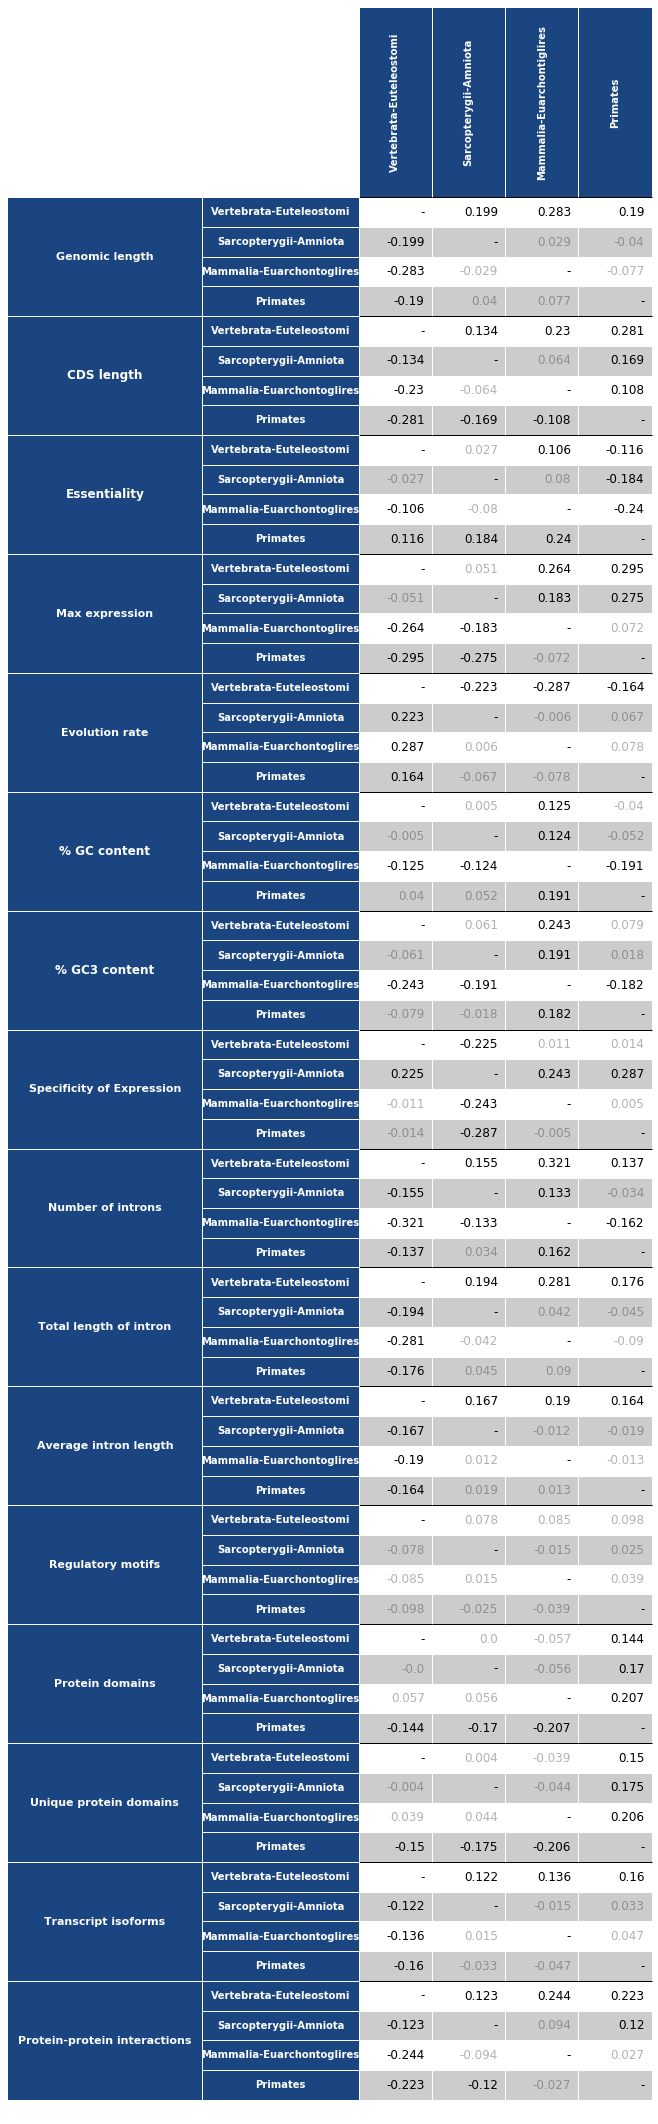

In [214]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7,7))

test = [[1,2,3,4], [4,5,4,6], [7,8,9,4],[1,2,3,4], [4,5,6,7], [7,8,9,10],[1,2,3,0], [4,5,6,0], [7,8,9,0],[1,2,3,0], [4,5,6,0], [7,8,9,0]]
test2 = [[2,2,3], [4,5,6], [7,8,9],[1,2,3], [4,5,6], [7,8,9],[1,2,3], [4,5,6], [7,8,9]]

#think bbox coordinates are [x1,y1, width, height]
# h = ax.table(cellText = [['Effect Size: Pairwise Comparisons of SSDs by Age']], bbox = [0.3,1.5,1.5,0.1], cellLoc = 'center')
# h.auto_set_font_size(False)

# for x in h.get_celld():
#     cell = h.get_celld()[x]
#     cell.set_color((0.1,0.27,0.5,1))
#     cell.set_text_props(fontsize=15, color = (1,1,1), weight = 'bold')
#     cell.set_edgecolor('w')
sh = ax.table(cellText = [['Vertebrata-Euteleostomi', 'Sarcopterygii-Amniota', 'Mammalia-Euarchontiglires','Primates']], bbox = [0.3,5,0.75,0.5], cellLoc = 'center')
# sh.auto_set_font_size(True)
for x in sh.get_celld():
    cell = sh.get_celld()[x]
    cell.set_color((0.1,0.27,0.5,1))
    cell.set_text_props(fontsize=10, color = (1,1,1), weight = 'bold',rotation='vertical')
    cell.set_edgecolor('w')
act = ax.table(cellText = data, bbox = [0.3,0,0.75,5])
act.auto_set_font_size(False)
for x in act.get_celld():
    cell = act.get_celld()[x]
    if x[0] % 2 == 0:
        cell.set_color((1,1,1,1))
    elif x[0] != -1:
        cell.set_color((0,0,0,0.2))
    if x[0] % 4 == 0:
        cell._visible_edges = 'T'
        cell.set_edgecolor((0,0,0,1))
    else:
        cell.set_edgecolor('w')
    if cell.get_text().get_text() != 'ns' and cell.get_text().get_text() != '-' and abs(float(cell.get_text().get_text())) < 0.1:
        cell.set_text_props(fontsize=12, color = (0,0,0,0.3))
    else:
        cell.set_text_props(fontsize=12, color = (0,0,0))

g = ax.table(cellText = sub_rows, bbox = [-0.1,0,0.4,5], cellLoc = 'center')
g.auto_set_font_size(False)
for x in g.get_celld():
    cell = g.get_celld()[x]
    cell.set_color((0.1,0.27,0.5,1))
    cell.set_edgecolor('w')
    cell.set_text_props(fontsize=10, color = (1,1,1), weight = 'bold')
    
    
sr = ax.table(cellText = rows, bbox = [-0.6, 0, 0.5,5],cellLoc='center')
sr.auto_set_font_size(False)
for x in sr.get_celld():
    cell = sr.get_celld()[x]
    cell.set_color((0.1,0.27,0.5,1))
    cell.set_edgecolor('w')
    if len(cell.get_text().get_text()) > 13:
        cell.set_text_props(fontsize=11, color = (1,1,1), weight = 'bold')
    elif len(cell.get_text().get_text()) > 24:
        cell.set_text_props(fontsize=10, color = (1,1,1), weight = 'bold')
    else:
        cell.set_text_props(fontsize=12, color = (1,1,1), weight = 'bold')
ax.axis('off')
plt.savefig('pairwise_SSD_age_groups.png',bbox_inches='tight')
plt.show()

In [11]:
# comparisons between SSD age subgroups
from math import log10
from collections import OrderedDict
header = 'Feature effects by SSD age'

vert_list =  ['Vertebrata-Euteleostomi', 'Sarcopterygii-Amniota', 'Mammalia-Euarchontoglires', 'Primates']
col_heads = vert_list

features = OrderedDict([('gLength', 'Genomic length'),
            ('cds_len', 'CDS length'),
            ('ess', 'Essentiality'),
            ('max_exp', 'Max expression'),
            ('dn_ds', 'Evolution rate'),
            ('gc_content', '% GC content'),
            ('gc3', '% GC3 content'),
            ('specificity', 'Specificity of Expression'),
            ('intron_count', 'Number of introns'),
            ('intron_coverage' , 'Intron coverage'),
            ('avg_intron' , 'Average intron length'),
            ('motif_number_1k' , 'Regulatory motifs'),
            ('domains' , 'Protein domains'),
            ('unique_domains' , 'Unique protein domains'),
            ('trans_count', 'Transcript isoforms'),
            ('PPIs', 'Protein-protein interactions')])
rows = [[features[x]] for x in features]
sub_rows = [[x] for x in ['Ohnologs','SSDs of ohnolog age','SSDs of ohnolog age (ohnologs removed)','Potential ohnologs']*len(features)]
data = []
with open('SSD_comparisons_potential_ohnos_excl_age_comp.csv','w') as file:
    for f in features:
        if f == 'gLength' or f == 'cds_len' or f == 'max_exp' or f == 'med_exp':
            query2 = 'SELECT %s, tax_levels_T2, id FROM gene_features WHERE %s >= 1 AND dup_type_T2 == "SSD" AND NOT %s IS NULL' %(f,f,f)
            cursor.execute(query2)
            SSD_test = [(log10(x[0]),x[1], x[2]) for x in cursor.fetchall()]

            query = 'SELECT %s, tax_levels_T2, id FROM gene_features WHERE %s >= 1 AND dup_type_T2 == "WGD" AND NOT %s IS NULL' %(f,f,f)
            cursor.execute(query)
            WGD_test = [(log10(x[0]),x[1], x[2]) for x in cursor.fetchall()]
        elif f == 'dn_ds':

            cursor.execute('SELECT dn_ds, tax_levels_T2, gene_features.id FROM macaque_paralogs INNER JOIN gene_features ON macaque_paralogs.id == gene_features.id WHERE (NOT dn_ds IS NULL) AND dn_ds < 10 AND dup_type_T2 == "SSD"')
            SSD_test = cursor.fetchall()

            cursor.execute('SELECT dn_ds, tax_levels_T2, gene_features.id FROM macaque_paralogs INNER JOIN gene_features ON macaque_paralogs.id == gene_features.id WHERE (NOT dn_ds IS NULL) AND dn_ds < 10 AND dup_type_T2 == "WGD"')
            WGD_test = cursor.fetchall()
        elif f == 'ess':

            cursor.execute('''SELECT ess, tax_levels_T2, id FROM gene_features WHERE NOT ess IS NULL AND dup_type_T2 == "SSD"''')
            SSD_test = [(-x[0], x[1], x[2]) for x in cursor.fetchall()]

            cursor.execute('''SELECT ess, tax_levels_T2, id FROM gene_features WHERE NOT ess IS NULL AND dup_type_T2 == "WGD"''')
            WGD_test = [(-x[0], x[1], x[2]) for x in cursor.fetchall()]
        elif f == 'gc3':

            cursor.execute('''SELECT gc3, tax_levels_T2, id FROM gene_features WHERE NOT ess IS NULL AND dup_type_T2 == "SSD"''')
            SSD_test = [(x[0]*100, x[1], x[2]) for x in cursor.fetchall()]

            cursor.execute('''SELECT gc3, tax_levels_T2, id FROM gene_features WHERE NOT ess IS NULL AND dup_type_T2 == "WGD"''')
            WGD_test = [(x[0]*100, x[1], x[2]) for x in cursor.fetchall()]
        else:
            query2 = 'SELECT %s, tax_levels_T2, id FROM gene_features WHERE dup_type_T2 == "SSD" AND NOT %s IS NULL' %(f,f)
            cursor.execute(query2)
            SSD_test = cursor.fetchall()

            query = 'SELECT %s, tax_levels_T2, id FROM gene_features WHERE dup_type_T2 == "WGD" AND NOT %s IS NULL' %(f,f)
            cursor.execute(query)
            WGD_test = cursor.fetchall()
    #     each tuple in SSD_leveled only has the earliest duplication node for a gene
        SSD_leveled_inc = [(x[0],min([int(y) for y in x[1].strip().split(',')]),x[2]) for x in SSD_test]
        SSD_leveled = [(x[0],min([int(y) for y in x[1].strip().split(',')]),x[2]) for x in SSD_test if max([int(y) for y in x[1].strip().split(',')]) > 2]
        SSDs_removed = set(SSD_leveled_inc) - set(SSD_leveled)


        SSD_inc = [x[0] for x in SSD_leveled_inc if x[1] in range(1,3)]
        SSD_excl = [x[0] for x in SSD_leveled if x[1] in range(1,3)]
        potent_WGD = [x[0] for x in SSDs_removed if x[1] in range(1,3)]
        WGD_test = [x[0] for x in WGD_test]
        
        print('Removed:',len(potent_WGD))
        
        for list1 in [WGD_test,SSD_inc,SSD_excl,potent_WGD]:
            row = []
            if list1 == WGD_test:
                row.append(features[f])
                row.append('Ohnologs')
            elif list1== SSD_inc:
                row.append('')
                row.append('SSDs of ohnolog age')
            elif list1== SSD_excl:
                row.append('')
                row.append('SSDs of ohnolog age (filtered)')
            elif list1== potent_WGD:
                row.append('')
                row.append('Potential ohnologs')
            for a2,b2 in [(3,6),(6,11),(11,19)]:
    #             print(a2,b2)
                SSD_list2 = [x[0] for x in SSD_leveled if x[1] in range(a2,b2)]


                n1, n2 = len(list1), len(SSD_list2)
                if n1 == 0 or n2 == 0:
                    esize = '-'
    #                 pval =  get_pval(SSD_list1, SSD_list2, 16)
                else:
                    pval =  get_pval(list1, SSD_list2, 16)
                    if float(pval) > 0.05:
                        esize = 'ns'
                    else:
                        esize = round(mann_whitney_effect_size(list1, SSD_list2), 3)
                row.append(esize)
            row= ','.join([str(x) for x in row])+'\n'
            file.write(row)
#                 file.write('Levels: ' + i + ' ' + i2+ '\n')
#                 file.write('Samples sizes: ' +  str(n1) + ' ' + str(n2) + '\n')
#                 file.write('P-value: ' + str(pval) + '\n')
#                 file.write('Effect size: ' + str(esize) + '\n')
#                 file.write('\n')
# #                 done.append((a,a2))
#             file.write('\n')
#             file.write('\n')
        
# print('Working on table')
# nice_table(header, col_heads, rows, sub_rows, data, file='age_table')
# [print(x) for x in data]

Removed: 1952
Removed: 1952
Removed: 1824
Removed: 1940
Removed: 1615
Removed: 1952
Removed: 1824
Removed: 1685
Removed: 1952
Removed: 1952
Removed: 1952
Removed: 1683
Removed: 1952
Removed: 1952
Removed: 1952
Removed: 1952


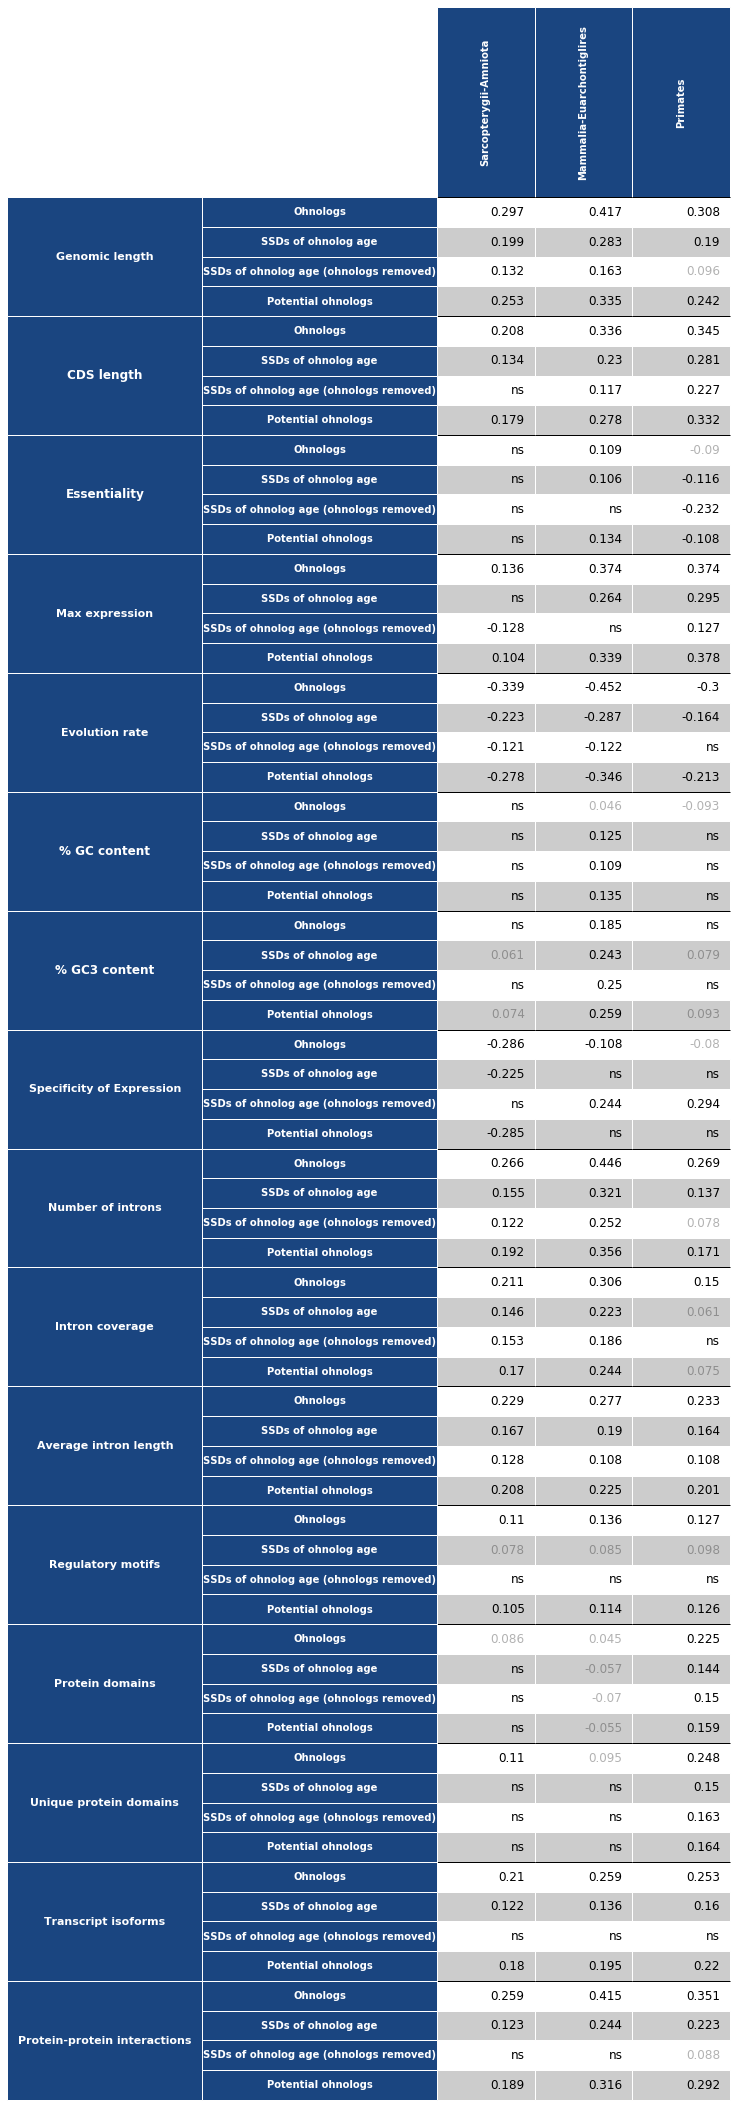

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7,7))

#think bbox coordinates are [x1,y1, width, height]
# h = ax.table(cellText = [['Effect Size: Pairwise Comparisons of SSDs by Age']], bbox = [0.3,1.5,1.5,0.1], cellLoc = 'center')
# h.auto_set_font_size(False)

# for x in h.get_celld():
#     cell = h.get_celld()[x]
#     cell.set_color((0.1,0.27,0.5,1))
#     cell.set_text_props(fontsize=15, color = (1,1,1), weight = 'bold')
#     cell.set_edgecolor('w')
sh = ax.table(cellText = [['Sarcopterygii-Amniota', 'Mammalia-Euarchontiglires','Primates']], bbox = [0.5,5,0.75,0.5], cellLoc = 'center')
# sh.auto_set_font_size(True)
for x in sh.get_celld():
    cell = sh.get_celld()[x]
    cell.set_color((0.1,0.27,0.5,1))
    cell.set_text_props(fontsize=10, color = (1,1,1), weight = 'bold',rotation='vertical')
    cell.set_edgecolor('w')
act = ax.table(cellText = data, bbox = [0.5,0,0.75,5])
act.auto_set_font_size(False)
for x in act.get_celld():
    cell = act.get_celld()[x]
    if x[0] % 2 == 0:
        cell.set_color((1,1,1,1))
    elif x[0] != -1:
        cell.set_color((0,0,0,0.2))
    if x[0] % 4 == 0:
        cell._visible_edges = 'T'
        cell.set_edgecolor((0,0,0,1))
    else:
        cell.set_edgecolor('w')
    if cell.get_text().get_text() != 'ns' and cell.get_text().get_text() != '-' and abs(float(cell.get_text().get_text())) < 0.1:
        cell.set_text_props(fontsize=12, color = (0,0,0,0.3))
    else:
        cell.set_text_props(fontsize=12, color = (0,0,0))



g = ax.table(cellText = sub_rows, bbox = [-0.1,0,0.6,5], cellLoc = 'center')
g.auto_set_font_size(False)
for x in g.get_celld():
    cell = g.get_celld()[x]
    cell.set_color((0.1,0.27,0.5,1))
    cell.set_edgecolor('w')
    cell.set_text_props(fontsize=10, color = (1,1,1), weight = 'bold')
    
    
sr = ax.table(cellText = rows, bbox = [-0.6, 0, 0.5,5],cellLoc='center')
sr.auto_set_font_size(False)
for x in sr.get_celld():
    cell = sr.get_celld()[x]
    cell.set_color((0.1,0.27,0.5,1))
    cell.set_edgecolor('w')
    if len(cell.get_text().get_text()) > 13:
        cell.set_text_props(fontsize=11, color = (1,1,1), weight = 'bold')
    elif len(cell.get_text().get_text()) > 24:
        cell.set_text_props(fontsize=10, color = (1,1,1), weight = 'bold')
    else:
        cell.set_text_props(fontsize=12, color = (1,1,1), weight = 'bold')
ax.axis('off')
plt.savefig('age_matched_SSD_WGD_vs_younger_groups.png',bbox_inches='tight')
plt.show()

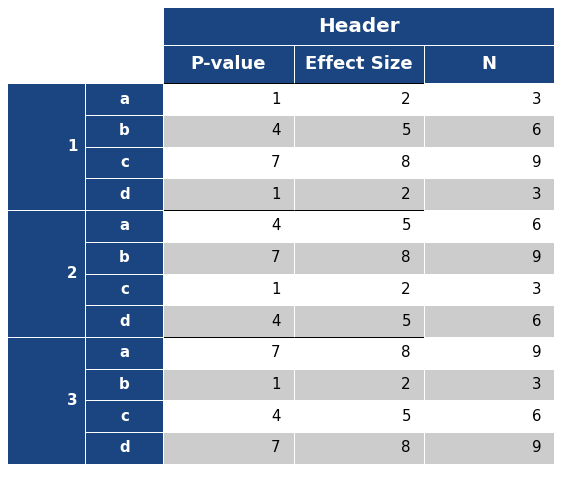

In [131]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7,7))

test = [[1,2,3], [4,5,6], [7,8,9],[1,2,3], [4,5,6], [7,8,9],[1,2,3], [4,5,6], [7,8,9],[1,2,3], [4,5,6], [7,8,9]]
test2 = [[2,2,3], [4,5,6], [7,8,9],[1,2,3], [4,5,6], [7,8,9],[1,2,3], [4,5,6], [7,8,9]]

#think bbox coordinates are [x1,y1, width, height]
h = ax.table(cellText = [['Header']], bbox = [0.3,1.1,1,0.1], cellLoc = 'center')
h.auto_set_font_size(False)
for x in h.get_celld():
    cell = h.get_celld()[x]
    cell.set_color((0.1,0.27,0.5,1))
    cell.set_text_props(fontsize=20, color = (1,1,1), weight = 'bold')
    cell.set_edgecolor('w')
sh = ax.table(cellText = [['P-value', 'Effect Size', 'N']], bbox = [0.3,1,1,0.1], cellLoc = 'center')
for x in sh.get_celld():
    cell = sh.get_celld()[x]
    cell.set_color((0.1,0.27,0.5,1))
    cell.set_text_props(fontsize=20, color = (1,1,1), weight = 'bold')
    cell.set_edgecolor('w')
act = ax.table(cellText = test, bbox = [0.3,0,1,1])
for x in act.get_celld():
    cell = act.get_celld()[x]
    if x[0] % 2 == 0:
        cell.set_color((1,1,1,1))
    elif x[0] != -1:
        cell.set_color((0,0,0,0.2))
    if x[0] % 4 == 0:
        cell._visible_edges = 'T'
        cell.set_edgecolor((0,0,0,1))
    else:
        cell.set_edgecolor('w')
    cell.set_text_props(fontsize=15, color = (0,0,0))
tester = [[x] for x in ['a', 'b', 'c', 'd']*3]
g = ax.table(cellText = tester, bbox = [0.1,0,0.2,1], cellLoc = 'center')
for x in g.get_celld():
    cell = g.get_celld()[x]
    cell.set_color((0.1,0.27,0.5,1))
    cell.set_edgecolor('w')
    cell.set_text_props(fontsize=15, color = (1,1,1), weight = 'bold')
sr = ax.table(cellText = [['1'], ['2'], ['3']], bbox = [-0.1, 0, 0.2,1])
for x in sr.get_celld():
    cell = sr.get_celld()[x]
    cell.set_color((0.1,0.27,0.5,1))
    cell.set_edgecolor('w')
    cell.set_text_props(fontsize=15, color = (1,1,1), weight = 'bold')
ax.axis('off')
plt.show()

In [5]:
def mann_whitney_effect_size(list1, list2): #this function is wrong in the Stats notebook
    import math
    from scipy import stats
    n1 = len(list1)
    n2 = len(list2)
    N = sum([n1,n2])
    U = stats.mannwhitneyu(list1, list2, alternative = 'two-sided').statistic
    mean = U-((n1*n2)/2)
    sd = math.sqrt((n1*n2*(n1+n2+1))/12)
    z = mean/sd
    r = z/math.sqrt(N)
    return(r)

In [6]:
def get_pval(list1, list2, n):
    from scipy import stats
    pval = (stats.mannwhitneyu(list1, list2,alternative='two-sided').pvalue)*n
    if pval < 0.05:
        return('{:.2e}'.format(pval))
    else:
        return(round(pval,2))



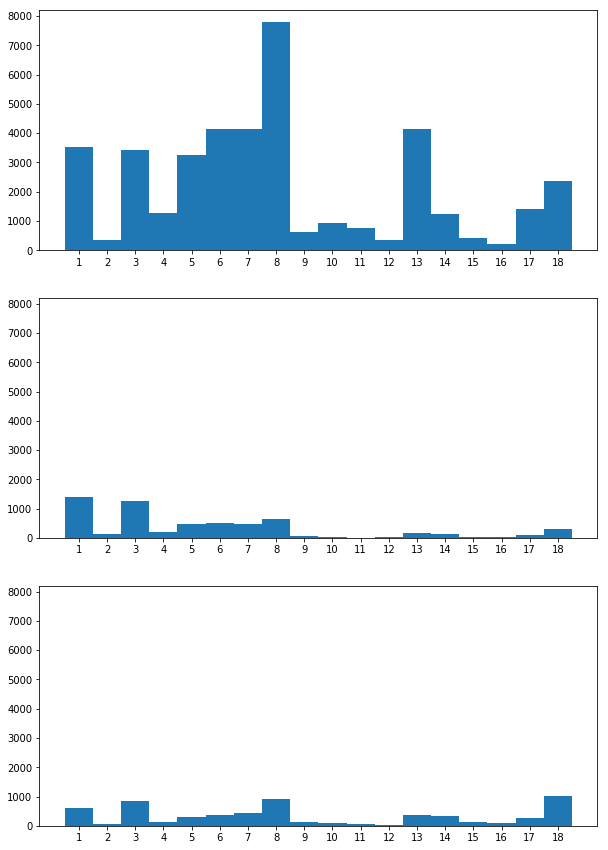

In [56]:
import matplotlib.pyplot as plt, numpy as np
fig, axes = plt.subplots(nrows=3, figsize=(10,15), sharey=True)
ax, ax2, ax3 = axes
query2 = 'SELECT tax_levels FROM gene_features WHERE dup_type == "SSD"'
cursor.execute(query2)
SSD_test = cursor.fetchall()

SSD_leveled = []
[SSD_leveled.extend([int(y) for y in x[0].strip().split(',')]) for x in SSD_test]
ax.hist(SSD_leveled, bins = np.arange(1,20,1), align='left')
ax.set_xticks(np.arange(1,19,1))

#     each tuple in SSD_leveled only has the earliest duplication node for a gene
SSD_leveled = [min([int(y) for y in x[0].strip().split(',')]) for x in SSD_test]
ax2.hist(SSD_leveled, bins = np.arange(1,20,1), align='left')
ax2.set_xticks(np.arange(1,19,1))


SSD_leveled = [max([int(y) for y in x[0].strip().split(',')]) for x in SSD_test]
ax3.hist(SSD_leveled, bins = np.arange(1,20,1), align='left')
ax3.set_xticks(np.arange(1,19,1))

plt.show()

In [89]:
# cursor.execute('''ALTER TABLE gene_features ADD COLUMN tax_levels2 TEXT''')
import time
vert_list =  ['Vertebrata','Euteleostomi', 'Sarcopterygii', 'Tetrapoda', 'Amniota', 'Mammalia', 'Theria', 'Eutheria','Boreoeutheria',  'Euarchontoglires', 'Primates', 'Haplorrhini', 'Simiiformes','Catarrhini', 'Hominoidea', 'Hominidae','Homininae', 'Homo sapiens']
cursor.execute('''SELECT id FROM gene_features WHERE dup_type2 == "SSD"''')
ids = [x[0] for x in cursor.fetchall()]
count, t = 0, time.time()
for i in ids:
    levels = []
    cursor.execute('''SELECT age FROM new_paralogs WHERE id == ?''', (i,))
    tax_list = [x[0] for x in cursor.fetchall() if x[0] in vert_list]
    for tax in tax_list:
        levels.append(vert_list.index(tax)+1)
    levels = [str(x) for x in levels]
    out = ','.join(levels) + ' '
    cursor.execute('''UPDATE gene_features SET tax_levels2 = ? WHERE id == ?''', (out, i))
    count += 1
    if count % 150 == 0:
        print(count, 'done:')
        print(time.time()-t, 'seconds since started,')
        print((time.time()-t)/count, 'seconds per gene')
        print(' ')

150 done:
1.6195628643035889 seconds since started,
0.010799913406372071 seconds per gene
 
300 done:
3.3578388690948486 seconds since started,
0.011194682916005453 seconds per gene
 
450 done:
5.020833969116211 seconds since started,
0.011158711115519205 seconds per gene
 
600 done:
6.658423900604248 seconds since started,
0.011098028421401977 seconds per gene
 
750 done:
8.177252054214478 seconds since started,
0.010903614679972331 seconds per gene
 
900 done:
9.697913885116577 seconds since started,
0.010775972207387288 seconds per gene
 
1050 done:
11.215399026870728 seconds since started,
0.01068170842670259 seconds per gene
 
1200 done:
12.710754871368408 seconds since started,
0.010592625737190246 seconds per gene
 
1350 done:
14.216949939727783 seconds since started,
0.010531325163664642 seconds per gene
 
1500 done:
15.863744020462036 seconds since started,
0.010576114018758138 seconds per gene
 
1650 done:
17.517156839370728 seconds since started,
0.01061669566414573 seconds 

In [90]:
# cursor.execute('''ALTER TABLE gene_features ADD COLUMN tax_levels_T2 TEXT''')
import time
vert_list =  ['Vertebrata', 'Euteleostomi', 'Sarcopterygii', 'Tetrapoda', 'Amniota', 'Mammalia', 'Theria', 'Eutheria','Boreoeutheria',  'Euarchontoglires', 'Primates', 'Haplorrhini', 'Simiiformes','Catarrhini', 'Hominoidea', 'Hominidae','Homininae', 'Homo sapiens']
cursor.execute('''SELECT id FROM gene_features WHERE dup_type_T2 == "SSD"''')
ids = [x[0] for x in cursor.fetchall()]
count, t = 0, time.time()
for i in ids:
    levels = []
    cursor.execute('''SELECT age FROM new_paralogs WHERE id == ?''', (i,))
    tax_list = [x[0] for x in cursor.fetchall() if x[0] in vert_list]
    for tax in tax_list:
        levels.append(vert_list.index(tax)+1)
    levels = [str(x) for x in levels]
    out = ','.join(levels) + ' '
    cursor.execute('''UPDATE gene_features SET tax_levels_T2 = ? WHERE id == ?''', (out, i))
    count += 1
    if count % 150 == 0:
        print(count, 'done:')
        print(time.time()-t, 'seconds since started,')
        print((time.time()-t)/count, 'seconds per gene')
        print(' ')

150 done:
1.8112390041351318 seconds since started,
0.012078026135762532 seconds per gene
 
300 done:
3.7126801013946533 seconds since started,
0.012377276420593261 seconds per gene
 
450 done:
5.623558044433594 seconds since started,
0.012498077816433377 seconds per gene
 
600 done:
7.266432046890259 seconds since started,
0.012111156781514486 seconds per gene
 
750 done:
9.031783103942871 seconds since started,
0.012042824109395346 seconds per gene
 
900 done:
10.948584079742432 seconds since started,
0.012165751192304824 seconds per gene
 
1050 done:
12.848253011703491 seconds since started,
0.012237002963111514 seconds per gene
 
1200 done:
14.502227067947388 seconds since started,
0.012085523406664531 seconds per gene
 
1350 done:
16.13778305053711 seconds since started,
0.011954521426448116 seconds per gene
 
1500 done:
17.772913932800293 seconds since started,
0.011848914623260497 seconds per gene
 
1650 done:
19.361085891723633 seconds since started,
0.011734318733215333 second

In [318]:

a2H = {}
with open('Downloads/2018_ohnolog_genes_human.txt','r') as file:
    for line in file:
        line = line.strip('\n').split('\t')
        if len(line) == 2 and (0 < len(line[1]) <= 15):
            a, h = line
            a = a.strip(' ')
            a2H[a] = h
        elif len(line) == 2 and line[1] == '':
            a = line[0].strip(' ')
            a2H[a] = 'None'
        elif len(line) == 2:
            a = line[0].strip(' ')
            h = line[1].split(' ')
            a2H[a] = h
        elif len(line) == 1:
            a = line[0].strip(' ')
            a2H[a] = 'None'
pairList = [] 
pairList2 = []
c = 0
c2 = 0
with open('Downloads/2018_ohnolog_list.txt') as pair_file:
    for line in pair_file:
        
        line = line.strip().split(' ')
        gene1, gene2 = line
#         except ValueError:
#             gene1,gene2 = line[0].split(' ')
        hgene1, hgene2 = a2H[gene1], a2H[gene2]
        if type(hgene1) == list and type(hgene2) == list:
            c2 += 1
#             don't know how to deal with this case
        elif type(hgene1) == str and type(hgene2) == str and hgene1 != 'None' and hgene2 != 'None':
            pairList.append((hgene1,hgene2))
        elif type(hgene1) == str and hgene1 != 'None' and hgene2 != 'None':
            pairList2.append((hgene1,'-'.join(hgene2)))
        elif type(hgene2) == str and hgene1 != 'None' and hgene2 != 'None':
            pairList2.append((hgene2,'-'.join(hgene1)))
        elif hgene1 == 'None'or hgene2 == 'None':
            c += 1
print(c,c2)

882 16


In [281]:
cursor.execute('CREATE TABLE IF NOT EXISTS ohnologs_2018_easy(id TEXT, ohno TEXT)')
for a,b in pairList:
    cursor.execute('INSERT INTO ohnologs_2018_easy VALUES (?,?)', (a,b))
db.commit()

In [329]:
# cursor.execute('ALTER TABLE new_paralogs ADD COLUMN ohno_2018 TEXT')
cursor.execute('''UPDATE new_paralogs 
                   SET ohno_2018 == "T" 
                       WHERE EXISTS 
                           (SELECT * FROM ohnologs_2018_easy AS o 
                               WHERE (o.id == new_paralogs.id AND o.ohno == new_paralogs.para)
                                       OR
                                    (o.id == new_paralogs.para AND o.ohno == new_paralogs.id))''')
db.commit()

In [321]:
gc, bc,uc = 0,0,0
for a,b in pairList2[:20]:
    problems = b.split('-')
    ohnoStatusList = []
    for problem in problems:
        cursor.execute('SELECT ohnoT FROM new_paralogs WHERE id == ? AND para == ?',(a,problem))
        try:
            ohnoT = cursor.fetchall()[0][0]
            
        except IndexError:
            ohnoT = 'NA'
        ohnoStatusList.append(ohnoT)
        print(a,problem,ohnoT)
    if ohnoStatusList.count('T') == 1:
        
        gc += 1
        correctPair = problems[ohnoStatusList.index('T')]
        print(correctPair)
#         yay!
    elif ohnoStatusList.count('T') < 1:
        bc += 1
#         no pairs ohnologous
    else:
        uc += 1
#         mess

print(len(pairList2),gc,bc,uc)

ENSG00000163359 ENSG00000206384 T
ENSG00000163359 ENSG00000172752 F
ENSG00000206384
ENSG00000144566 ENSG00000108774 T
ENSG00000144566 ENSG00000267261 F
ENSG00000108774
ENSG00000073734 ENSG00000085563 NA
ENSG00000073734 ENSG00000005471 NA
ENSG00000108100 ENSG00000182632 NA
ENSG00000108100 ENSG00000163249 T
ENSG00000163249
ENSG00000135924 ENSG00000105993 T
ENSG00000135924 ENSG00000172404 T
ENSG00000119541 ENSG00000132612 NA
ENSG00000119541 ENSG00000260914 NA
ENSG00000205022 ENSG00000100836 T
ENSG00000205022 ENSG00000258643 F
ENSG00000100836
ENSG00000185015 ENSG00000169239 T
ENSG00000185015 ENSG00000174990 T
ENSG00000133742 ENSG00000169239 T
ENSG00000133742 ENSG00000174990 T
ENSG00000164879 ENSG00000169239 T
ENSG00000164879 ENSG00000174990 T
ENSG00000101460 ENSG00000171471 NA
ENSG00000101460 ENSG00000140941 T
ENSG00000140941
ENSG00000166446 ENSG00000153046 T
ENSG00000166446 ENSG00000172352 F
ENSG00000166446 ENSG00000172288 F
ENSG00000166446 ENSG00000182415 F
ENSG00000166446 ENSG0000012987

In [328]:
cursor.execute('ALTER TABLE ohnologs_2018_easy ADD COLUMN flags TEXT')
gc, bc,uc = 0,0,0
for a,b in pairList2:
    problems = b.split('-')
    ohnoStatusList = []
    for problem in problems:
        cursor.execute('SELECT * FROM t_ohnologs WHERE (id == ? AND ohno_id == ?) OR (id == ? AND ohno_id == ?)',(a,problem,problem,a))
        if len(cursor.fetchall()) != 0:
            ohnoT = 'T'
        else:
            ohnoT = 'F'
        ohnoStatusList.append(ohnoT)
    if ohnoStatusList.count('T') == 1:
        
        gc += 1
        correctPair = problems[ohnoStatusList.index('T')]
        cursor.execute('INSERT INTO ohnologs_2018_easy VALUES(?,?,?)', (a,correctPair,'from t_ohno'))
#         yay!
    elif ohnoStatusList.count('T') < 1:
        bc += 1
#         no pairs ohnologous
    else:
        uc += 1
#         mess

print(len(pairList2),gc,bc,uc)
db.commit()







































































































































































































































































































































































































































422 157 161 104


In [11]:
cursor.execute('UPDATE new_paralogs SET ohno_2018 = "F" WHERE ohno_2018 IS NULL')
db.commit()

In [13]:
# script for assigning dup types to individual genes
# cursor.execute('ALTER TABLE gene_features ADD COLUMN dup_type_2018 TEXT')

import time
count = 0
t = time.time()

cursor.execute('SELECT id FROM gene_features')
idList = [x[0] for x in cursor.fetchall()]
for i in idList:
    count += 1
    cursor.execute('SELECT ohno_2018, singleton FROM new_paralogs WHERE id == ?', (i,))
    res = cursor.fetchall()
    
    cursor.execute('SELECT retro FROM new_paralogs WHERE ohno_2018 == "F" AND id == ?', (i,))
    retroRes = [x[0] for x in cursor.fetchall()]
    
    ohnoRes = [x[0] for x in res]
    singRes = [x[1] for x in res]
    
# checks
# singleton
    if 'T' in set(singRes):
#         singleton
        cursor.execute('UPDATE gene_features SET dup_type_2018 = "singleton" WHERE id == ?', (i,))
        continue
    
    if ohnoRes == []:
        cursor.execute('UPDATE gene_features SET dup_type_2018 = "singleton-ish" WHERE id == ?', (i,))
        continue
    
    if ('T' in set(ohnoRes)) and ('F' in set(ohnoRes)): # mix of ohno and SSD
        cursor.execute('UPDATE gene_features SET dup_type_2018 = "mix" WHERE id== ?',(i,))
    elif not ('F' in set(ohnoRes)):
        # pure ohnolog (1)
        cursor.execute('UPDATE gene_features SET dup_type_2018 = "WGD" WHERE id == ?', (i,))
# pure SSD (ohno 1)
# and none of the duplications are retro or inconclusive
    elif (not 'T' in set(ohnoRes)):
        if (not 'T' in set(retroRes)) and (not 'I' in set(retroRes)):
            cursor.execute('UPDATE gene_features SET dup_type_2018 = "SSD" WHERE id == ?', (i,))
        elif (not 'F' in set(retroRes)) and (not 'I' in set(retroRes)):
            cursor.execute('UPDATE gene_features SET dup_type_2018 = "Retrogene" WHERE id == ?', (i,))
        else:
            cursor.execute('UPDATE gene_features SET dup_type_2018 = "mix - no ohnos" WHERE id == ?', (i,))
      
    if count % 500 ==  0:
        print(count, round(time.time()-t,2))
db.commit()         

500 6.34
1000 12.0
1500 19.81
3000 39.8
4000 51.43
4500 56.9
5000 62.31
5500 68.19
6000 73.96
6500 80.05
7500 92.52
8500 104.58
9500 116.94
10000 122.48
10500 128.12
11500 141.66
12000 148.17
13000 160.42
14500 178.99
15000 185.04
17000 210.35
17500 217.94
18000 225.79
18500 232.72
19500 244.43
20000 250.07


In [19]:
import requests, json
headers = {'Content-Type':'application/json'}
c = requests.get('http://mobidb.bio.unipd.it/ws/P04217/consensus',headers=headers).json()

In [23]:
[print(key) for key in c['mobidb_consensus']['disorder']['predictors']]

{'method': 'simple', 'regions': [[1, 4, 'D'], [34, 36, 'D'], [74, 75, 'D'], [84, 94, 'D'], [110, 120, 'D'], [130, 138, 'D'], [158, 227, 'D'], [248, 261, 'D'], [278, 296, 'D'], [301, 355, 'D'], [377, 409, 'D'], [422, 424, 'D'], [432, 454, 'D'], [458, 466, 'D'], [480, 495, 'D']]}
{'dc': 0, 'method': 'mobidb-lite', 'scores': [0.625, 0.25, 0.25, 0.125, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.125, 0.125, 0, 0, 0, 0, 0, 0, 0, 0, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.25, 0.125, 0.125, 0.125, 0.125, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.25, 0.375, 0.375, 0.375, 0.375, 0.25, 0.25, 0.125, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.125, 0.25, 0.25, 0.375, 0.375, 0.25, 0.125, 0.25, 0.25, 0.25, 0.25, 0.37

[None, None]

In [24]:
len(c['mobidb_consensus']['disorder']['predictors'][1]['scores'])

495

In [20]:
def dec_range(start, stop, step):
    r = start
    while r < stop:
        yield r
        r += step
def jitter_list(l, center=0, step = 0.1):
    import random
    if center=='value':
        out_list = []
        for x in l:
            center = x
            c = l.count(x)
            c = c*0.001
            if c < 0.75:
                out_list.append(random.sample(list(dec_range(center-c, center + c, step)), 1)[0])
            else:
                c = 0.75
                out_list.append(random.sample(list(dec_range(center-c, center + c, step)), 1)[0])
        
        return out_list
    elif center != 0:
        test_list = [round(x, 1) for x in l]
        out_list = []
        for x in l:
            if round(x,1) == 1:
                c = 0.39
            else:
                c = test_list.count(round(x,1))
                c = c*0.001
            out_list.append(random.sample(list(dec_range(center-c, center + c, step)), 1)[0])
        
        return out_list
    
    else:
        test_list = [round(x, 1) for x in l]
        out_list = []
        for x in l:
            if test_list.count(round(x,1)) < 9:
                c = test_list.count(round(x,1))
            else:
                c = 9
            out_list.append(random.sample(list(dec_range(-c, c, step)), 1)[0])
        return out_list



[ 0.93688661 -0.28510478]


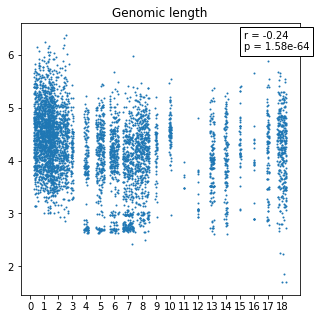

[ 0.93688661 -0.52047521]


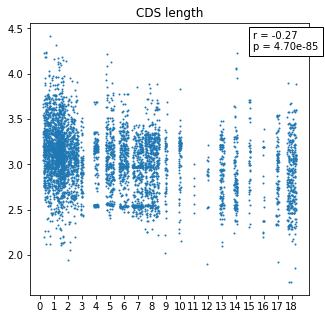

[ 0.94327325  0.12372743]


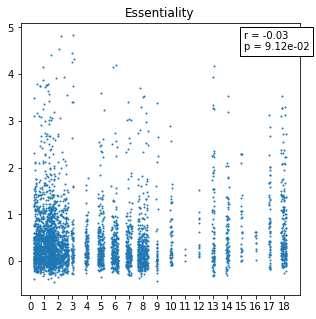

[ 0.9398458   0.04576449]


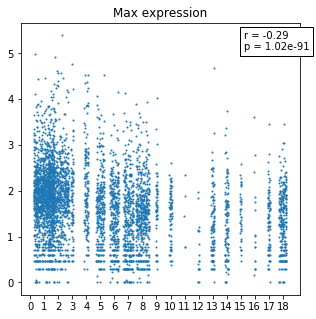

[ 0.94222733  0.04572073]


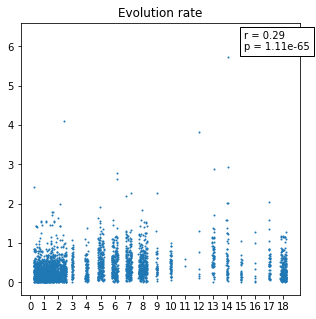

[ 0.93688661 -0.56018807]


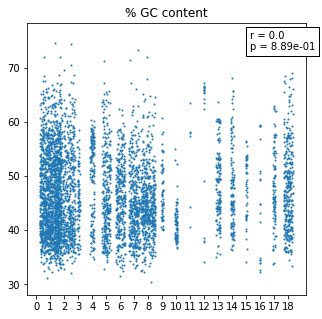

[ 0.94327325 -0.25356717]


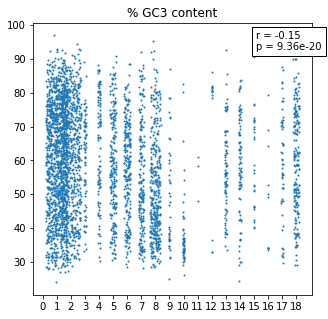

[ 0.94728013 -0.32348012]


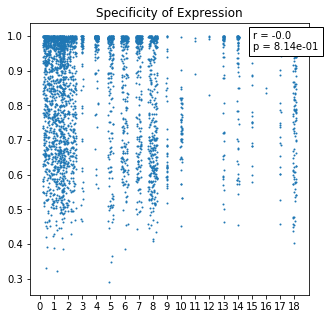

[ 0.93688661  0.0454652 ]


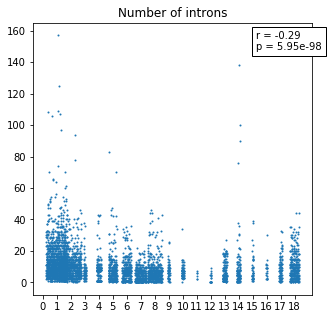

[ 0.93688661  0.04545455]


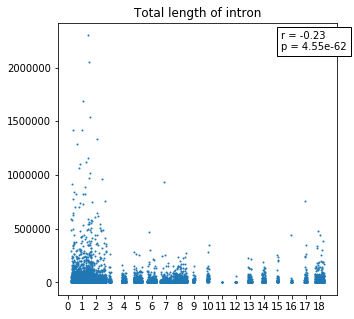

[ 0.93688661  0.04545455]


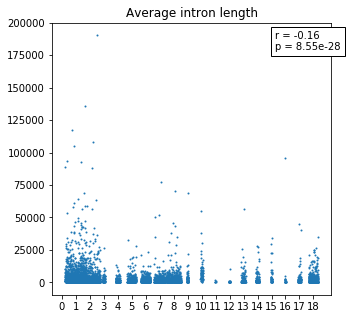

[ 0.94743109  0.0454867 ]


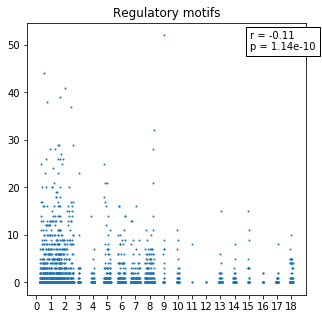

[ 0.93688661  0.04548289]


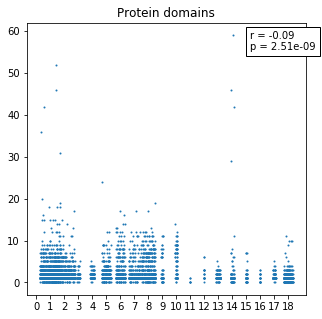

[ 0.93688661  0.04564029]


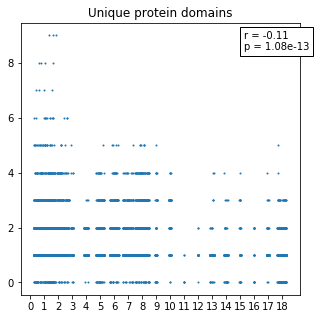

[ 0.93688661  0.0394453 ]


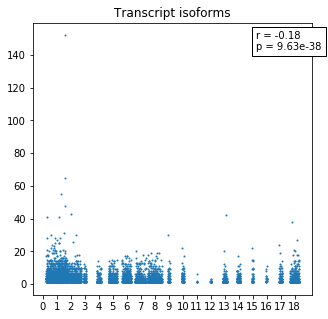

[ 0.93688661  0.04545542]


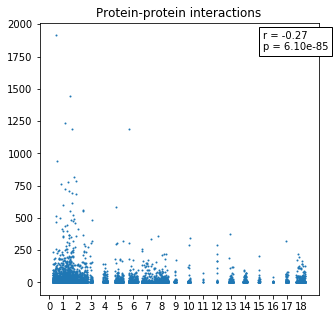

In [109]:
# full SSD set
from math import log10
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
features = OrderedDict([('gLength', 'Genomic length'),
            ('cds_len', 'CDS length'),
            ('ess', 'Essentiality'),
            ('max_exp', 'Max expression'),
            ('dn_ds', 'Evolution rate'),
            ('gc_content', '% GC content'),
            ('gc3', '% GC3 content'),
            ('specificity', 'Specificity of Expression'),
            ('intron_count', 'Number of introns'),
            ('intron_length' , 'Total length of intron'),
            ('avg_intron' , 'Average intron length'),
            ('motif_number_1k' , 'Regulatory motifs'),
            ('domains' , 'Protein domains'),
            ('unique_domains' , 'Unique protein domains'),
            ('trans_count', 'Transcript isoforms'),
            ('PPIs', 'Protein-protein interactions')])

with open('SSD_comparisons_potential_ohnos_excl_new_class.txt','w') as file:
    for f in features:
        if f == 'gLength' or f == 'cds_len' or f == 'max_exp' or f == 'med_exp':
            query2 = 'SELECT %s, tax_levels2 FROM gene_features WHERE %s >= 1 AND dup_type2 == "SSD" AND NOT %s IS NULL' %(f,f,f)
            cursor.execute(query2)
            SSD_test = [(log10(x[0]),x[1]) for x in cursor.fetchall()]
        elif f == 'dn_ds':

            cursor.execute('SELECT dn_ds, tax_levels2 FROM macaque_paralogs INNER JOIN gene_features ON macaque_paralogs.id == gene_features.id WHERE (NOT dn_ds IS NULL) AND dn_ds < 10 AND dup_type2 == "SSD"')
            SSD_test = cursor.fetchall()
        elif f == 'ess':

            cursor.execute('''SELECT ess, tax_levels2 FROM gene_features WHERE NOT ess IS NULL AND dup_type2 == "SSD"''')
            SSD_test = [(-x[0], x[1]) for x in cursor.fetchall()]
        elif f == 'gc3':

            cursor.execute('''SELECT gc3, tax_levels2 FROM gene_features WHERE NOT ess IS NULL AND dup_type2 == "SSD"''')
            SSD_test = [(x[0]*100, x[1]) for x in cursor.fetchall()]
        else:
            query2 = 'SELECT %s, tax_levels2 FROM gene_features WHERE dup_type2 == "SSD" AND NOT %s IS NULL' %(f,f)
            cursor.execute(query2)
            SSD_test = cursor.fetchall()
    #     each tuple in SSD_leveled only has the earliest duplication node for a gene
        SSD_leveled = [(x[0],min([int(y) for y in x[1].strip().split(',')])) for x in SSD_test]
        
        fig, ax = plt.subplots(figsize=(5,5))
        ax.set_xticks(np.arange(0,19,1))
        y = [x[0] for x in SSD_leveled]
        x = [x[1] for x in SSD_leveled]
        
        
        ax.scatter(jitter_list(x,center='value',step=0.01),y,1)
        corr,pval= round(stats.spearmanr(x,y).correlation,2), '{:0.2e}'.format(stats.spearmanr(x,y).pvalue,2)
#         corr,pval= round(stats.pearsonr(x,y)[0],2), '{:0.2e}'.format(stats.pearsonr(x,y)[1],2)
        print(ax.transLimits.transform((18,0)))
        box_props = dict(alpha=1,fc='w')
        textBox = ax.text(0.8,0.9,'r = '+str(corr)+'\np = '+str(pval),transform=ax.transAxes,bbox=box_props)
        
        ax.set_title(features[f])
        plt.show()
        fig.clear()

In [106]:
data_to_axes = ax.transData + ax.transAxes.inverted()
axesToData = ax.transAxes + ax.transData
# data_to_axes.transform((18,6))
ax.transLimits.transform((18,2000))

array([   7.70813822,  896.32223982])

In [17]:
def jitter_list(l, center=0, step = 0.1):
    import random
    if center=='value':
        out_list = []
        for x in l:
            center = x
            c = l.count(x)
            c = c*0.001
            if c < 0.75:
                out_list.append(random.sample(list(dec_range(center-c, center + c, step)), 1)[0])
            else:
                c = 0.75
                out_list.append(random.sample(list(dec_range(center-c, center + c, step)), 1)[0])
        
        return out_list
    elif center != 0:
        test_list = [round(x, 1) for x in l]
        out_list = []
        for x in l:
            if round(x,1) == 1:
                c = 0.39
            else:
                c = test_list.count(round(x,1))
                c = c*0.001
            out_list.append(random.sample(list(dec_range(center-c, center + c, step)), 1)[0])
        
        return out_list
    
    else:
        test_list = [round(x, 1) for x in l]
        out_list = []
        for x in l:
            if test_list.count(round(x,1)) < 9:
                c = test_list.count(round(x,1))
            else:
                c = 9
            out_list.append(random.sample(list(dec_range(-c, c, step)), 1)[0])
        return out_list

In [21]:
# filtered SSD set
from math import log10
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
featureValues = {}
features = OrderedDict([('gLength', 'Genomic length'),
            ('cds_len', 'CDS length'),
            ('ess', 'Essentiality'),
            ('max_exp', 'Max expression'),
            ('dn_ds', 'Evolution rate'),
            ('gc_content', '% GC content'),
            ('gc3', '% GC3 content'),
            ('specificity', 'Specificity of Expression'),
            ('intron_count', 'Number of introns'),
            ('intron_coverage' , 'Intron coverage'),
            ('avg_intron' , 'Average intron length'),
            ('motif_number_1k' , 'Regulatory motifs'),
            ('domains' , 'Protein domains'),
            ('unique_domains' , 'Unique protein domains'),
            ('trans_count', 'Transcript isoforms'),
            ('PPIs', 'Protein-protein interactions')])

with open('SSD_comparisons_potential_ohnos_excl_new_class.txt','w') as file:
    for f in features:
        if f == 'gLength' or f == 'cds_len' or f == 'max_exp' or f == 'med_exp':
            query2 = 'SELECT %s, tax_levels2 FROM gene_features WHERE %s >= 1 AND dup_type2 == "SSD" AND NOT %s IS NULL' %(f,f,f)
            cursor.execute(query2)
            SSD_test = [(log10(x[0]),x[1]) for x in cursor.fetchall()]
        elif f == 'dn_ds':

            cursor.execute('SELECT dn_ds, tax_levels2 FROM macaque_paralogs INNER JOIN gene_features ON macaque_paralogs.id == gene_features.id WHERE (NOT dn_ds IS NULL) AND dn_ds < 10 AND dup_type2 == "SSD"')
            SSD_test = cursor.fetchall()
        elif f == 'ess':

            cursor.execute('''SELECT ess, tax_levels2 FROM gene_features WHERE NOT ess IS NULL AND dup_type2 == "SSD"''')
            SSD_test = [(-x[0], x[1]) for x in cursor.fetchall()]
        elif f == 'gc3':

            cursor.execute('''SELECT gc3, tax_levels2 FROM gene_features WHERE NOT ess IS NULL AND dup_type2 == "SSD"''')
            SSD_test = [(x[0]*100, x[1]) for x in cursor.fetchall()]
        else:
            query2 = 'SELECT %s, tax_levels2 FROM gene_features WHERE dup_type2 == "SSD" AND NOT %s IS NULL' %(f,f)
            cursor.execute(query2)
            SSD_test = cursor.fetchall()
    #     each tuple in SSD_leveled only has the earliest duplication node for a gene
        SSD_leveled = [(x[0],min([int(y) for y in x[1].strip().split(',')])) for x in SSD_test if max([int(y) for y in x[1].strip().split(',')]) > 2]
        featureValues[f] = SSD_leveled
        

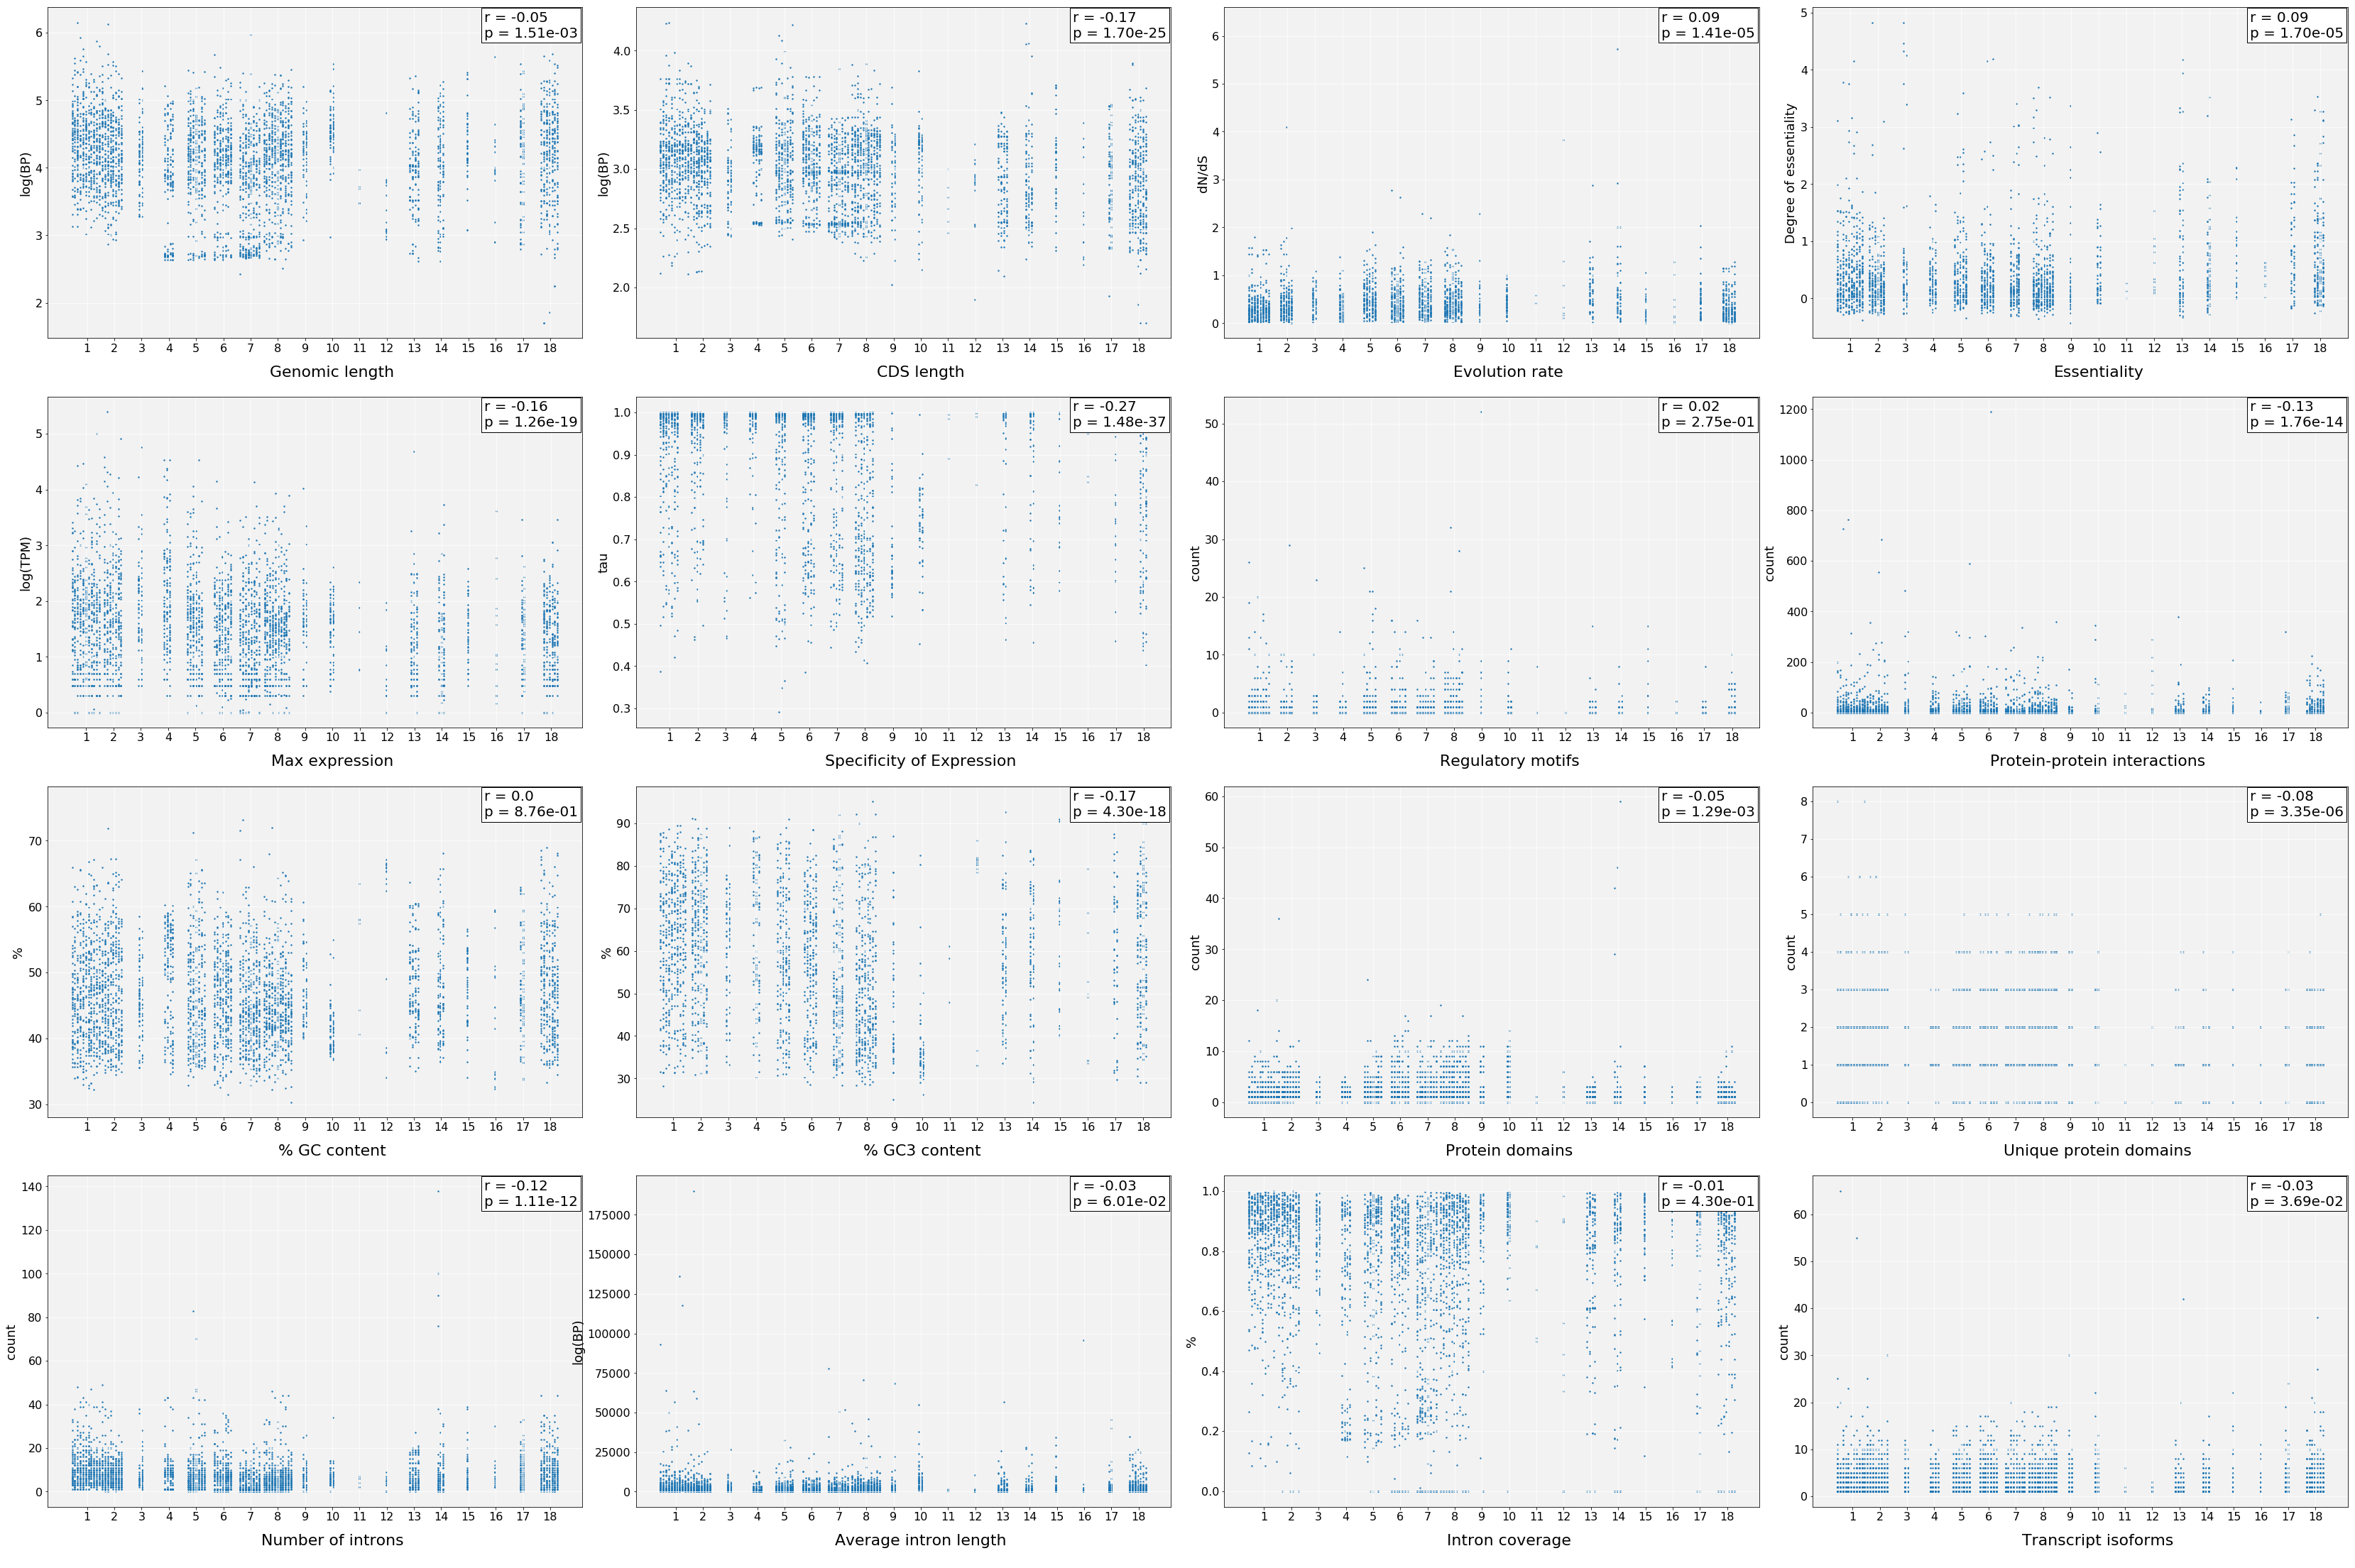

In [32]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(45,40), gridspec_kw=dict(height_ratios=[1,0.09,1,0.09,1,0.09,1,0.09], hspace=0.08,wspace=0.1,left=0,right=1))
plotAxes, labelAxes = [],[]
for axList in axes[::2]:
    for ax in axList:
        plotAxes.append(ax)
for axList in axes[1::2]:
    for ax in axList:
        labelAxes.append(ax)
featuresPlot = {'gLength':('log(BP)',1,0.5,2),
                'cds_len':('log(BP)',1,0.5,2),
                'dn_ds':('dN/dS',1,0.5,2),
                'ess':('Degree of essentiality',1,0.5,2),
                'max_exp':('log(TPM)',1,0.5,2),
                'specificity':('tau',0.1,0.05,0.22),
                'motif_number_1k':('count',10,5,15),
                'PPIs':('count',200,300,1000,2200,2800),
                'gc_content':('%',5,5,20),
                'gc3':('%',5,5,20),
                'domains':('count',25,25,100,125,300),
                'unique_domains':('count',5,2,8,10,14),#?
               'intron_count':('count',50,50,200,200,350),
                'avg_intron':('log(BP)',1,0.5,2),
                'intron_coverage':('%',5,5,20),
                'trans_count':('count',10,20,65,80,150)}

def single_feature_plot(f,p,l):
    SSD_lev = featureValues[f]
    y = [x[0] for x in SSD_lev]
    x = [x[1] for x in SSD_lev]
    
    p.set_facecolor((0,0,0,0.05))
    p.grid(color = 'white')
    
    p.set_ylabel(featuresPlot[f][0],fontsize=18)
    
    p.set_xticks(np.arange(1,19,1))
    p.tick_params('both',labelsize=16)
    
    p.scatter(jitter_list(x,center='value'),y,2)
    corr,pval= round(stats.spearmanr(x,y).correlation,2), '{:0.2e}'.format(stats.spearmanr(x,y).pvalue,2)

    box_props = dict(alpha=1,fc='w')
    p.text(0.817,0.91,'r = '+str(corr)+'\np = '+str(pval),transform=p.transAxes,bbox=box_props, fontsize=20)
    
    p.yaxis.set_tick_params(labelsize=16)
    
    l.set_xlim(p.get_xlim())
    l.annotate(features[f], xy=(10, 0.2), ha= 'center', size=22, transform = l.transAxes)
    l.axis('off')
    

    
featuresPlotKeys = ['gLength','cds_len','dn_ds','ess',
                'max_exp','specificity','motif_number_1k','PPIs',
                'gc_content','gc3','domains','unique_domains',
               'intron_count','avg_intron','intron_coverage','trans_count']
for f,p,l in zip(featuresPlotKeys,plotAxes,labelAxes):
    single_feature_plot(f,p,l)
        

plt.savefig('test_fig3.png',bbox_inches='tight')
plt.show()

In [12]:
x = [1,2,3]
y = [1,2,3]
fig,ax = plt.subplots()
ax.scatter(x,y)
plt.show()
ax.transLimits.transform((2,2))

NameError: name 'plt' is not defined

In [8]:
from ete3 import PhyloTree
PhyloTree('(((((((DyakGE25505_FBpp0270515_Dyak:0,DyakGE29217_FBpp0362771_Dyak:0.002402)1:0.028359,DereGG22593_FBpp0141139_Dere:0.024758)1:0.011229,((DsimGD19194_FBpp0217596_Dsim:0.004661,DsecGM15271_FBpp0196748_Dsec:0.006683)1:0.005055,DNaseII_FBpp0082962_Dmel:0.024481)1:0.031414)1:0.070763,DanaGF16750_FBpp0119942_Dana:0.086574)1:0.031542,(DperGL12583_FBpp0176690_Dper:0,DpseGA20583_FBpp0284880_Dpse:0)1:0.092211)1:0.078483,DwilGK11236_FBpp0240379_Dwil:0.197974)1:0.006765,((DmojGI23709_FBpp0172926_Dmoj:0.073655,DvirGJ23268_FBpp0237685_Dvir:0.116278)1:0.02086,DgriGH15034_FBpp0148940_Dgri:0.111484)1:0.050321);').show()

In [46]:
with open('GO_results_25.csv','r') as file, open('GO_enriched_25.csv','w') as out1, open('GO_dep_25.csv','w') as out2:
    for line in file:
        line = line.strip().split(',')
        output1 = ','.join(line[:6]) + '\n'
        output2 = ','.join(line[6:]) + '\n'
        out1.write(output1)
        out2.write(output2)

In [19]:
# okay, let's look at new ess metrics
# RVIS: has a million values depending on the MAF cutoff used, pops used, should read the paper (GenicIntolerance_v3_12Mar16.txt)
# missense Z score and pLI in one file from ExAC: file starts fordist_cleaned_exac followed by dataset used
# LoFtool: need to figure out which supp file has scores
# S_het: file = 075523-1.xlsx
# phi: phi_scores.txt
# cursor.execute('ALTER TABLE gene_features ADD COLUMN syn_Z_score REAL')
# cursor.execute('ALTER TABLE gene_features ADD COLUMN mis_Z_score REAL')
# cursor.execute('ALTER TABLE gene_features ADD COLUMN lof_Z_score REAL')
# cursor.execute('ALTER TABLE gene_features ADD COLUMN pLI_score REAL')
import requests, json,re

headers = {'Content-Type':'application/json'}
with open('fordist_cleaned_exac_r03_march16_z_pli_rec_null_data.txt','r') as file:
#     transcript id and gene name given, try transcr first
# ind 16,17,18 = z scores for syn, missense and LOF
# ind 19 is pLI, prob intolerant of het and homo LOF
    file.readline()
    for line in file:
        line = line.strip('\n').split('\t')
        tID, name = line[0],line[1]
        z_syn, z_miss, z_lof, pli = line[16:20]
        tID = re.search(r'^(.*)\.',tID).group(1)
#         match trans ID to gene ID
        url = 'https://rest.ensembl.org/lookup/id/' + tID + '?'
        r = requests.get(url,headers=headers).json()
        try:
            gene = r['Parent']
        except KeyError:
            cursor.execute('SELECT id FROM gene_features WHERE name == ?',(name,))
            try:
                gene = cursor.fetchall()[0][0]
            except IndexError:
                print(name)
                continue
        cursor.execute('UPDATE gene_features SET syn_Z_score = ?, mis_Z_score = ?,lof_Z_score = ?, pLI_score = ? WHERE id == ?',(z_syn,z_miss,z_lof,pli,gene))
db.commit()

PRAMEF22
AC114494.1
CCDC163P
AC093157.1
AL592284.1
NBPF16
C1ORF220
IFRG15
C1orf229
SMEK2
C2orf27B
C2orf27A
AC018470.1
AC018867.2
LINC00696
C3orf79
C4orf6
TMPRSS11BNL
AC110615.1
FYB
CTD-2215E18.1
CTC-349C3.1
AC005609.1
AC010441.1
C6orf195
AL583828.1
AL441883.1
C6orf25
SBP1
COX6A1P2
FLJ20306
C7orf10
C7orf69
AC004899.1
WBSCR16
C7orf66
HTR5A-AS1
SGK223
C8orf12
RP11-383H13.1
SPATA31A2
C9orf170
C9orf139
C10orf111
C10orf25
FAM21B
ANXA8L2
ASAH2C
AC022532.1
AC022400.2
MUC2
AP000867.1
AP000889.3
LEPREL2
C12orf77
C13orf35
RP11-407N17.3
C14orf183
AL627171.2
AL133373.1
GOLGA8I
RP11-467N20.5
C15orf54
C15orf56
C15orf32
WASH4P
GPR56
AC040160.1
AC006435.1
AC005358.1
UBBP4
C17orf103
C17orf102
CTB-186H2.3
C17orf66
CCL4L1
C17orf82
AC079210.1
AC103809.2
AC087645.1
AC015989.2
HDGFRP2
RPSAP58
C19orf55
CEACAM18
LILRA3
AC010327.2
C20orf197
C20orf166
GRIK1-AS2
AP000695.1
GSTT1
C22orf24
C22orf26
PHF16
GAGE2D
RGAG4
RP1-241P17.4


In [20]:
import numpy as np

cursor.execute('SELECT mis_Z_score FROM gene_features WHERE dup_type_T2 == "WGD" AND NOT mis_Z_score IS NULL')
wList = [x[0] for x in cursor.fetchall()]
cursor.execute('SELECT mis_Z_score FROM gene_features WHERE dup_type_T2 == "SSD" AND NOT mis_Z_score IS NULL')
sList = [x[0] for x in cursor.fetchall()]
cursor.execute('SELECT mis_Z_score FROM gene_features WHERE dup_type_T2 == "singleton" AND NOT mis_Z_score IS NULL')
siList = [x[0] for x in cursor.fetchall()]

print(np.median(wList),np.median(sList),np.median(siList))

1.26527084883 0.0935181671397 0.211840009799


In [21]:
import numpy as np

cursor.execute('SELECT pLI_score FROM gene_features WHERE dup_type_T2 == "WGD" AND NOT pLI_score IS NULL')
wList = [x[0] for x in cursor.fetchall()]
cursor.execute('SELECT pLI_score FROM gene_features WHERE dup_type_T2 == "SSD" AND NOT pLI_score IS NULL')
sList = [x[0] for x in cursor.fetchall()]
cursor.execute('SELECT pLI_score FROM gene_features WHERE dup_type_T2 == "singleton" AND NOT pLI_score IS NULL')
siList = [x[0] for x in cursor.fetchall()]

print(np.median(wList),np.median(sList),np.median(siList))

0.341935521943 0.00540138000117 0.013679982052


In [33]:
from tqdm import tqdm
# cursor.execute('ALTER TABLE gene_features ADD COLUMN loftool_percentile REAL')
with open('loftool_scores_table.csv','r') as file:
    file.readline()
    for line in tqdm(file):
        line = line.strip('\n').split(',')
        name, score = line[0],float(line[3])
        cursor.execute('UPDATE gene_features SET loftool_percentile = ? WHERE name == ?',(score,name))
db.commit()

14515it [04:19, 55.91it/s]


In [34]:
import numpy as np

cursor.execute('SELECT loftool_percentile FROM gene_features WHERE dup_type_T2 == "WGD" AND NOT loftool_percentile IS NULL')
wList = [x[0] for x in cursor.fetchall()]
cursor.execute('SELECT loftool_percentile FROM gene_features WHERE dup_type_T2 == "SSD" AND NOT loftool_percentile IS NULL')
sList = [x[0] for x in cursor.fetchall()]
cursor.execute('SELECT loftool_percentile FROM gene_features WHERE dup_type_T2 == "singleton" AND NOT loftool_percentile IS NULL')
siList = [x[0] for x in cursor.fetchall()]

print(np.median(wList),np.median(sList),np.median(siList))

0.375 0.61 0.522


In [37]:
with open('loftool_no_scores_no_LOF.csv','r') as file:
    file.readline()
    for line in file:
        line = line.strip('\n').split(',')
        name = line[0]
        cursor.execute('UPDATE gene_features SET loftool_percentile = -1 WHERE name == ?',(name,))
db.commit()

In [44]:
cursor.execute('SELECT COUNT(id) FROM gene_features WHERE dup_type_T2 == "WGD" AND loftool_percentile == -1')
w_count = cursor.fetchone()[0]
cursor.execute('SELECT COUNT(id) FROM gene_features WHERE dup_type_T2 == "WGD" AND loftool_percentile > 0 AND NOT loftool_percentile IS NULL')
w_count_score = cursor.fetchone()[0]

print(w_count,w_count_score)

cursor.execute('SELECT COUNT(id) FROM gene_features WHERE dup_type_T2 == "SSD" AND loftool_percentile == -1')
s_count = cursor.fetchone()[0]
cursor.execute('SELECT COUNT(id) FROM gene_features WHERE dup_type_T2 == "SSD" AND loftool_percentile > 0 AND NOT loftool_percentile IS NULL')
s_count_score = cursor.fetchone()[0]

print(s_count,s_count_score)

from scipy.stats import chi2_contingency

chi2_contingency([[212,2972],[174,3103]])

212 2972
174 3103


(4.9909119216280375,
 0.025480776996690005,
 1,
 array([[  190.22194707,  2993.77805293],
        [  195.77805293,  3081.22194707]]))

In [47]:
cursor.execute('SELECT COUNT(id) FROM gene_features WHERE dup_type_T2 == "singleton" AND loftool_percentile == -1')
si_count = cursor.fetchone()[0]
cursor.execute('SELECT COUNT(id) FROM gene_features WHERE dup_type_T2 == "singleton" AND loftool_percentile > 0 AND NOT loftool_percentile IS NULL')
si_count_score = cursor.fetchone()[0]

print(si_count,si_count_score)

cursor.execute('SELECT COUNT(id) FROM gene_features WHERE dup_type_T2 == "SSD" AND loftool_percentile == -1')
s_count = cursor.fetchone()[0]
cursor.execute('SELECT COUNT(id) FROM gene_features WHERE dup_type_T2 == "SSD" AND loftool_percentile > 0 AND NOT loftool_percentile IS NULL')
s_count_score = cursor.fetchone()[0]

print(s_count,s_count_score)

# from scipy.stats import chi2_contingency

chi2_contingency([[223,3546],[174,3103]])

223 3546
174 3103


(1.1030632819540043,
 0.29359482351706401,
 1,
 array([[  212.36063014,  3556.63936986],
        [  184.63936986,  3092.36063014]]))

In [49]:
cursor.execute('SELECT COUNT(id) FROM gene_features WHERE dup_type_T2 == "singleton" AND loftool_percentile == -1')
si_count = cursor.fetchone()[0]
cursor.execute('SELECT COUNT(id) FROM gene_features WHERE dup_type_T2 == "singleton" AND loftool_percentile > 0 AND NOT loftool_percentile IS NULL')
si_count_score = cursor.fetchone()[0]

print(si_count,si_count_score)

cursor.execute('SELECT COUNT(id) FROM gene_features WHERE dup_type_T2 == "WGD" AND loftool_percentile == -1')
w_count = cursor.fetchone()[0]
cursor.execute('SELECT COUNT(id) FROM gene_features WHERE dup_type_T2 == "WGD" AND loftool_percentile > 0 AND NOT loftool_percentile IS NULL')
w_count_score = cursor.fetchone()[0]

print(w_count,w_count_score)

# from scipy.stats import chi2_contingency

chi2_contingency([[223,3546],[212,2972]])

223 3546
212 2972


(1.4945130990988995,
 0.22151754520660746,
 1,
 array([[  235.79965483,  3533.20034517],
        [  199.20034517,  2984.79965483]]))

In [50]:
chi2_contingency([[212,2972],[174,3103],[223,3546]])

(5.2597989623105361,
 0.072085707846674354,
 2,
 array([[  189.54604106,  2994.45395894],
        [  195.08240469,  3081.91759531],
        [  224.37155425,  3544.62844575]]))

In [51]:
chi2_contingency([[212,2972],[397,6649]])

(3.9255398582086256,
 0.0475579184751019,
 1,
 array([[  189.54604106,  2994.45395894],
        [  419.45395894,  6626.54604106]]))

In [52]:
chi2_contingency([[223,3546],[386,6075]])

(0.0056997048570950207,
 0.93981976994624539,
 1,
 array([[  224.37155425,  3544.62844575],
        [  384.62844575,  6076.37155425]]))

In [53]:
chi2_contingency([[174,3103],[435,5518]])

(13.361854579069114,
 0.00025679423943255638,
 1,
 array([[  216.21809317,  3060.78190683],
        [  392.78190683,  5560.21809317]]))

In [58]:
# cursor.execute('ALTER TABLE gene_features ADD COLUMN s_het REAL')
with open('shet_estimates.csv','r') as file:
    file.readline()
    for line in file:
        line = line.strip('\n').split(',')
        name, shet = line[:2]
        cursor.execute('UPDATE gene_features SET s_het = ? WHERE name == ?',(shet,name))
db.commit()

In [59]:
import numpy as np

cursor.execute('SELECT s_het FROM gene_features WHERE dup_type_T2 == "WGD" AND NOT s_het IS NULL')
wList = [x[0] for x in cursor.fetchall()]
cursor.execute('SELECT s_het FROM gene_features WHERE dup_type_T2 == "SSD" AND NOT s_het IS NULL')
sList = [x[0] for x in cursor.fetchall()]
cursor.execute('SELECT s_het FROM gene_features WHERE dup_type_T2 == "singleton" AND NOT s_het IS NULL')
siList = [x[0] for x in cursor.fetchall()]

print(np.median(wList),np.median(sList),np.median(siList))

0.036632683 0.0116064435 0.0144960485


In [62]:
# cursor.execute('ALTER TABLE gene_features ADD COLUMN Phi REAL')
with open('phi_scores.txt','r') as file:
    for i in range(0,8):
        file.readline()
    for line in file:
        line = line.strip('\n').split(' ')
        name,score = line[0],line[1]
        cursor.execute('UPDATE gene_features SET Phi = ? WHERE name == ?',(score,name))
db.commit()

In [63]:
import numpy as np

cursor.execute('SELECT Phi FROM gene_features WHERE dup_type_T2 == "WGD" AND NOT Phi IS NULL')
wList = [x[0] for x in cursor.fetchall()]
cursor.execute('SELECT Phi FROM gene_features WHERE dup_type_T2 == "SSD" AND NOT Phi IS NULL')
sList = [x[0] for x in cursor.fetchall()]
cursor.execute('SELECT Phi FROM gene_features WHERE dup_type_T2 == "singleton" AND NOT Phi IS NULL')
siList = [x[0] for x in cursor.fetchall()]

print(np.median(wList),np.median(sList),np.median(siList))

0.383798715384 0.106653204407 0.143229832611


In [65]:
# cursor.execute('ALTER TABLE gene_features ADD COLUMN RVIS REAL')
with open('GenicIntolerance_v3_12Mar16.txt','r') as file:
    file.readline()
    for line in tqdm(file):
        line = line.strip('\n').split('\t')
        name,score,excl = line[0],line[2],line[16]
        if excl == 'Y':
            continue
        else:
            cursor.execute('UPDATE gene_features SET RVIS = ? WHERE name == ?',(score,name))
db.commit()

19093it [05:45, 55.32it/s]


In [67]:
import numpy as np

cursor.execute('UPDATE gene_features SET RVIS = ? WHERE RVIS == "NA"',(None,))

cursor.execute('SELECT RVIS FROM gene_features WHERE dup_type_T2 == "WGD" AND NOT RVIS IS NULL')
wList = [x[0] for x in cursor.fetchall()]
cursor.execute('SELECT RVIS FROM gene_features WHERE dup_type_T2 == "SSD" AND NOT RVIS IS NULL')
sList = [x[0] for x in cursor.fetchall()]
cursor.execute('SELECT RVIS FROM gene_features WHERE dup_type_T2 == "singleton" AND NOT RVIS IS NULL')
siList = [x[0] for x in cursor.fetchall()]

print(np.median(wList),np.median(sList),np.median(siList))

35.57 62.41 56.85


In [110]:
# cursor.execute('ALTER TABLE gene_features ADD COLUMN EvoTol REAL')
import requests, json
from requests import ConnectionError

cursor.execute('SELECT name FROM gene_features WHERE EvoTol IS NULL')
idList = [x[0] for x in cursor.fetchall()]

for i in tqdm(idList,mininterval=60):
    url = 'http://www.evotol.co.uk/genes_json?genes=' + i + '&ont=all&thresh=1'
    try:
        res = requests.get(url).json()
        if res['table'] == []:
            score = None
        else:
            score = res['table'][0][1]
    except ConnectionError:
        score = None
    time.sleep(0.6)
    
    cursor.execute('UPDATE gene_features SET EvoTol = ? WHERE name == ?',(score,i))
db.commit()





  0%|          | 0/8860 [00:00<?, ?it/s]



  1%|          | 61/8860 [01:00<2:26:34,  1.00it/s]



  1%|          | 61/8860 [01:19<2:26:34,  1.00it/s]



  1%|▏         | 121/8860 [02:01<2:25:41,  1.00s/it]



  1%|▏         | 121/8860 [02:19<2:25:41,  1.00s/it]



  2%|▏         | 181/8860 [03:01<2:25:04,  1.00s/it]



  2%|▏         | 181/8860 [03:19<2:25:04,  1.00s/it]



  3%|▎         | 241/8860 [04:01<2:24:10,  1.00s/it]



  3%|▎         | 241/8860 [04:19<2:24:10,  1.00s/it]



  3%|▎         | 302/8860 [05:02<2:22:53,  1.00s/it]



  3%|▎         | 302/8860 [05:19<2:22:53,  1.00s/it]



  4%|▍         | 363/8860 [06:03<2:21:43,  1.00s/it]



  4%|▍         | 363/8860 [06:19<2:21:43,  1.00s/it]



  5%|▍         | 424/8860 [07:04<2:20:30,  1.00it/s]



  5%|▍         | 424/8860 [07:19<2:20:30,  1.00it/s]



  5%|▌         | 485/8860 [08:05<2:19:24,  1.00it/s]



  5%|▌         | 485/8860 [08:19<2:19:24,  1.00it/s]



  6%|▌         | 546/8860 [09:06<2:18:24,  1.00it/s]



  

 41%|████      | 3590/8860 [1:00:43<1:35:44,  1.09s/it]



 41%|████      | 3590/8860 [1:01:00<1:35:44,  1.09s/it]



 41%|████      | 3646/8860 [1:01:44<1:34:38,  1.09s/it]



 41%|████      | 3646/8860 [1:02:00<1:34:38,  1.09s/it]



 42%|████▏     | 3701/8860 [1:02:44<1:33:46,  1.09s/it]



 42%|████▏     | 3701/8860 [1:03:00<1:33:46,  1.09s/it]



 42%|████▏     | 3756/8860 [1:03:44<1:32:49,  1.09s/it]



 42%|████▏     | 3756/8860 [1:04:00<1:32:49,  1.09s/it]



 43%|████▎     | 3811/8860 [1:04:44<1:31:52,  1.09s/it]



 43%|████▎     | 3811/8860 [1:05:00<1:31:52,  1.09s/it]



 44%|████▎     | 3867/8860 [1:05:45<1:30:42,  1.09s/it]



 44%|████▎     | 3867/8860 [1:06:00<1:30:42,  1.09s/it]



 44%|████▍     | 3922/8860 [1:06:45<1:29:44,  1.09s/it]



 44%|████▍     | 3922/8860 [1:07:00<1:29:44,  1.09s/it]



 45%|████▍     | 3977/8860 [1:07:45<1:28:46,  1.09s/it]



 45%|████▍     | 3977/8860 [1:08:00<1:28:46,  1.09s/it]



 45%|████▌     | 4030/8860 [1:08:46<1:28:56,  1.10s/it]


 76%|███████▌  | 6749/8860 [1:59:12<38:00,  1.08s/it]



 76%|███████▌  | 6749/8860 [1:59:22<38:00,  1.08s/it]



 77%|███████▋  | 6805/8860 [2:00:12<36:59,  1.08s/it]



 77%|███████▋  | 6805/8860 [2:00:22<36:59,  1.08s/it]



 77%|███████▋  | 6861/8860 [2:01:13<35:59,  1.08s/it]



 77%|███████▋  | 6861/8860 [2:01:32<35:59,  1.08s/it]



 78%|███████▊  | 6917/8860 [2:02:13<35:00,  1.08s/it]



 78%|███████▊  | 6917/8860 [2:02:32<35:00,  1.08s/it]



 79%|███████▊  | 6972/8860 [2:03:13<34:06,  1.08s/it]



 79%|███████▊  | 6972/8860 [2:03:32<34:06,  1.08s/it]



 79%|███████▉  | 7029/8860 [2:04:14<32:58,  1.08s/it]



 79%|███████▉  | 7029/8860 [2:04:32<32:58,  1.08s/it]



 80%|███████▉  | 7084/8860 [2:05:14<32:05,  1.08s/it]



 80%|███████▉  | 7084/8860 [2:05:32<32:05,  1.08s/it]



 81%|████████  | 7140/8860 [2:06:15<31:04,  1.08s/it]



 81%|████████  | 7140/8860 [2:06:32<31:04,  1.08s/it]



 81%|████████  | 7197/8860 [2:07:16<29:56,  1.08s/it]



 81%|████████  | 7197/8860 [2:0

In [112]:
cursor.execute('SELECT EvoTol FROM gene_features WHERE dup_type_T2 == "WGD" AND NOT EvoTol IS NULL AND EvoTol != "Not expressed above threshold in this ontology"')
wList = [x[0] for x in cursor.fetchall()]
cursor.execute('SELECT EvoTol FROM gene_features WHERE dup_type_T2 == "SSD" AND NOT EvoTol IS NULL AND EvoTol != "Not expressed above threshold in this ontology"')
sList = [x[0] for x in cursor.fetchall()]
cursor.execute('SELECT EvoTol FROM gene_features WHERE dup_type_T2 == "singleton" AND NOT EvoTol IS NULL AND EvoTol != "Not expressed above threshold in this ontology"')
siList = [x[0] for x in cursor.fetchall()]

print(np.median(wList),np.median(sList),np.median(siList))

51.1649945 55.39018955 44.3701227
